In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from statsmodels.graphics.gofplots import qqplot
import numpy as np
from math import isnan
plt.style.use('seaborn')

## Importing Data

In [2]:
data = pd.read_csv("data.csv")
# Making sure the condition and responses are the same
data.condition = data.condition.apply(lambda x: x.lower())

In [3]:
incorrect = list(map(lambda x: f"scene_{x}", range(54, 90)))
inc_mask = data.scene.isin(incorrect)

In [4]:
data.loc[inc_mask, "correct_response"]=data.loc[inc_mask, "correct_response"].replace({"f": "j", "j": "f"})
data.loc[inc_mask, "correct"]=data.loc[inc_mask, "correct"].replace({True: False, False: True})

## Cleaning Data

### Helper functions

In [5]:
def remove_participants(df):
    '''
    Remove participants that do not pass comprehension check
    in at most 3 tries
    '''
    limit = 3
    num_asks = 3
    threshold = limit*num_asks
    group = df.groupby(["subject_id"])
    subjs = list(group.attempts.count()[group.attempts.count() > threshold].index)
    return df[~df["subject_id"].isin(subjs)]

In [6]:
def adjust_trial_index(df):
    '''
    Reindex the 96 trial indices from [21-N] to [0-N]
    '''
    indices = list(range(96))
    df['trial_index'] = indices
    return df

In [7]:
def drop_columns(df):
    '''
    Drop unused columns
    '''
    return df.drop(columns=["failed_video","failed_audio","failed_images",
                           "internal_node_id","timeout", "stimulus",
                            "study_id","session_id","success","attempts",
                           "trial_type","time_elapsed"])

In [8]:
def count_nan(x):
    '''
    Count how many NaNs appear in a list of strings
    '''
    sum_ = 0
    for i in x:
        sum_+= type(i) == float
    return sum_

def list_elements(df,elem):
    '''
    List complete responses in a dataframe
    of responses
    '''
    for i in df[elem]:
        yield(i)

def remove_rt_outlier(l):
    return list(map(lambda x: 3000 if x > 3000 else x, l))

### Setting up dataframes

In [10]:
# Dataframe containing only the trial responses
responses = data[data.task == 'response']

# Dropping columns
responses = drop_columns(responses)
responses = responses.reset_index(drop=True)
responses = responses.rename(columns={'condition':'exp_condition',
                                     'response': 'response_'})

# Reindexing the trial indices from [21-N] to [0-N]
responses = responses.groupby('subject_id').apply(adjust_trial_index)

# Limiting response times to the timout max
responses.rt = responses.rt.apply(lambda x: 3000 if x > 3000 else x)
responses = responses[responses.rt < 3000]

# Taking the log(RT) and adding to dataframe
responses["log_rt"] = responses.rt.apply(lambda x: np.log(x))

# Adding per-trial condition (i.e. was the correct answer yes or no)
responses['trial_condition'] = responses.correct_response == responses.exp_condition
responses['trial_condition'] = responses.trial_condition.apply(lambda x: "Yes" if x else "No")

# Recoding the responses as "yes" or "no" instead of condition-dependent key
responses['response'] = responses.exp_condition == responses.response_
responses['response'] = responses.response.apply(lambda x: "Yes" if x else "No")

# Adding per-participant accuracy to the dataframe
responses['participant_accuracy'] = responses.groupby('subject_id')['correct'].transform('sum')/len(responses.groupby('trial_index'))
responses['trial_accuracy'] = responses.groupby('trial_index')['correct'].transform('sum')/len(responses.groupby('subject_id'))
responses['scene_accuracy'] = responses.groupby('scene')['correct'].transform('sum')/len(responses.groupby('subject_id'))

print("Check 1: ", len(responses[responses.correct]) == len(responses[responses.response == responses.trial_condition]))

Check 1:  True


## Analyses

- Number of participant responses per scene condition
- Number of scenes/stimuli per condition
- Number of participant responses across conditions
- Participant accuracy per condition
- Participant accuracy per trial
- Log-RT per participant
- Log-rt per scene
- Log-RT per scenes in No Condition
- Log-RT per scenes in Yes Condition
- Log-RT per Trial

#### Number of responses per scene condition

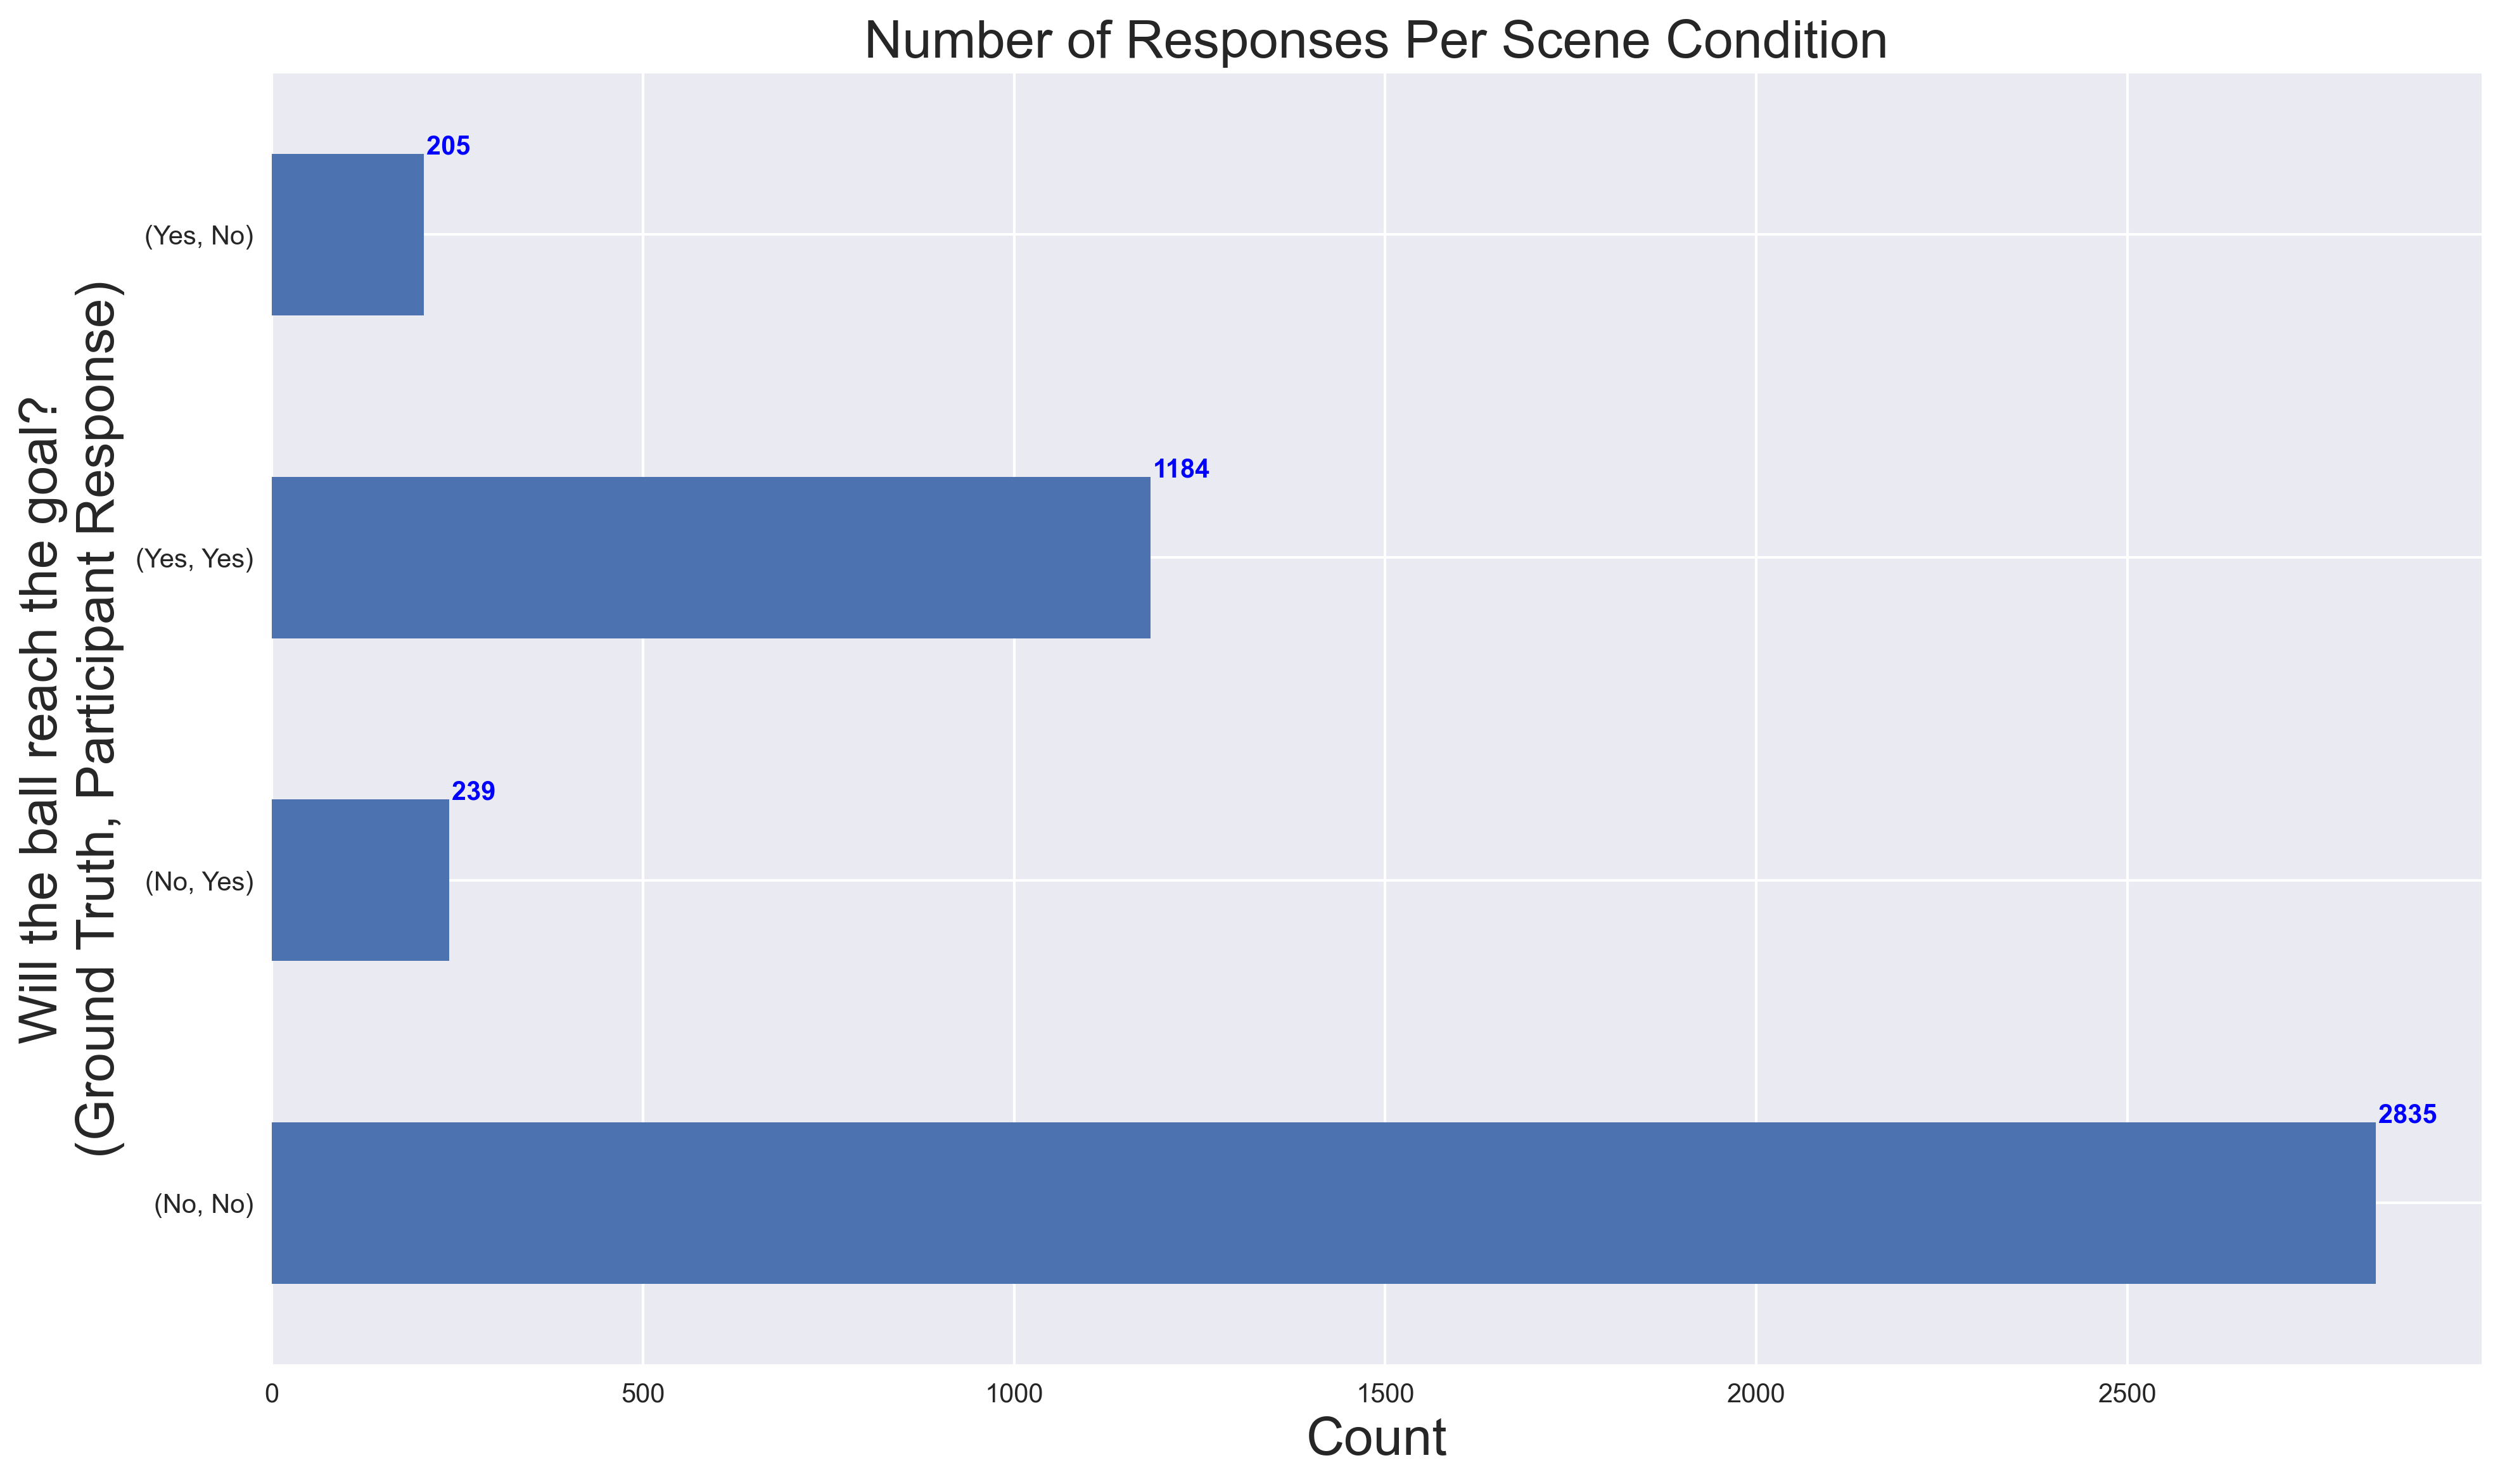

In [20]:
figure(figsize=(15, 9), dpi=300)
ax = responses.groupby("trial_condition").response.value_counts().plot.barh()
ax.set_xlabel("Count",fontsize=20);
ax.set_ylabel("Will the ball reach the goal?\n(Ground Truth, Participant Response)",fontsize=20);
ax.set_title("Number of Responses Per Scene Condition",fontsize=20)
for i, v in enumerate(responses.groupby("trial_condition").response.value_counts()):
    ax.text(v + 3, i + .25, str(v), color='blue', fontweight='bold')

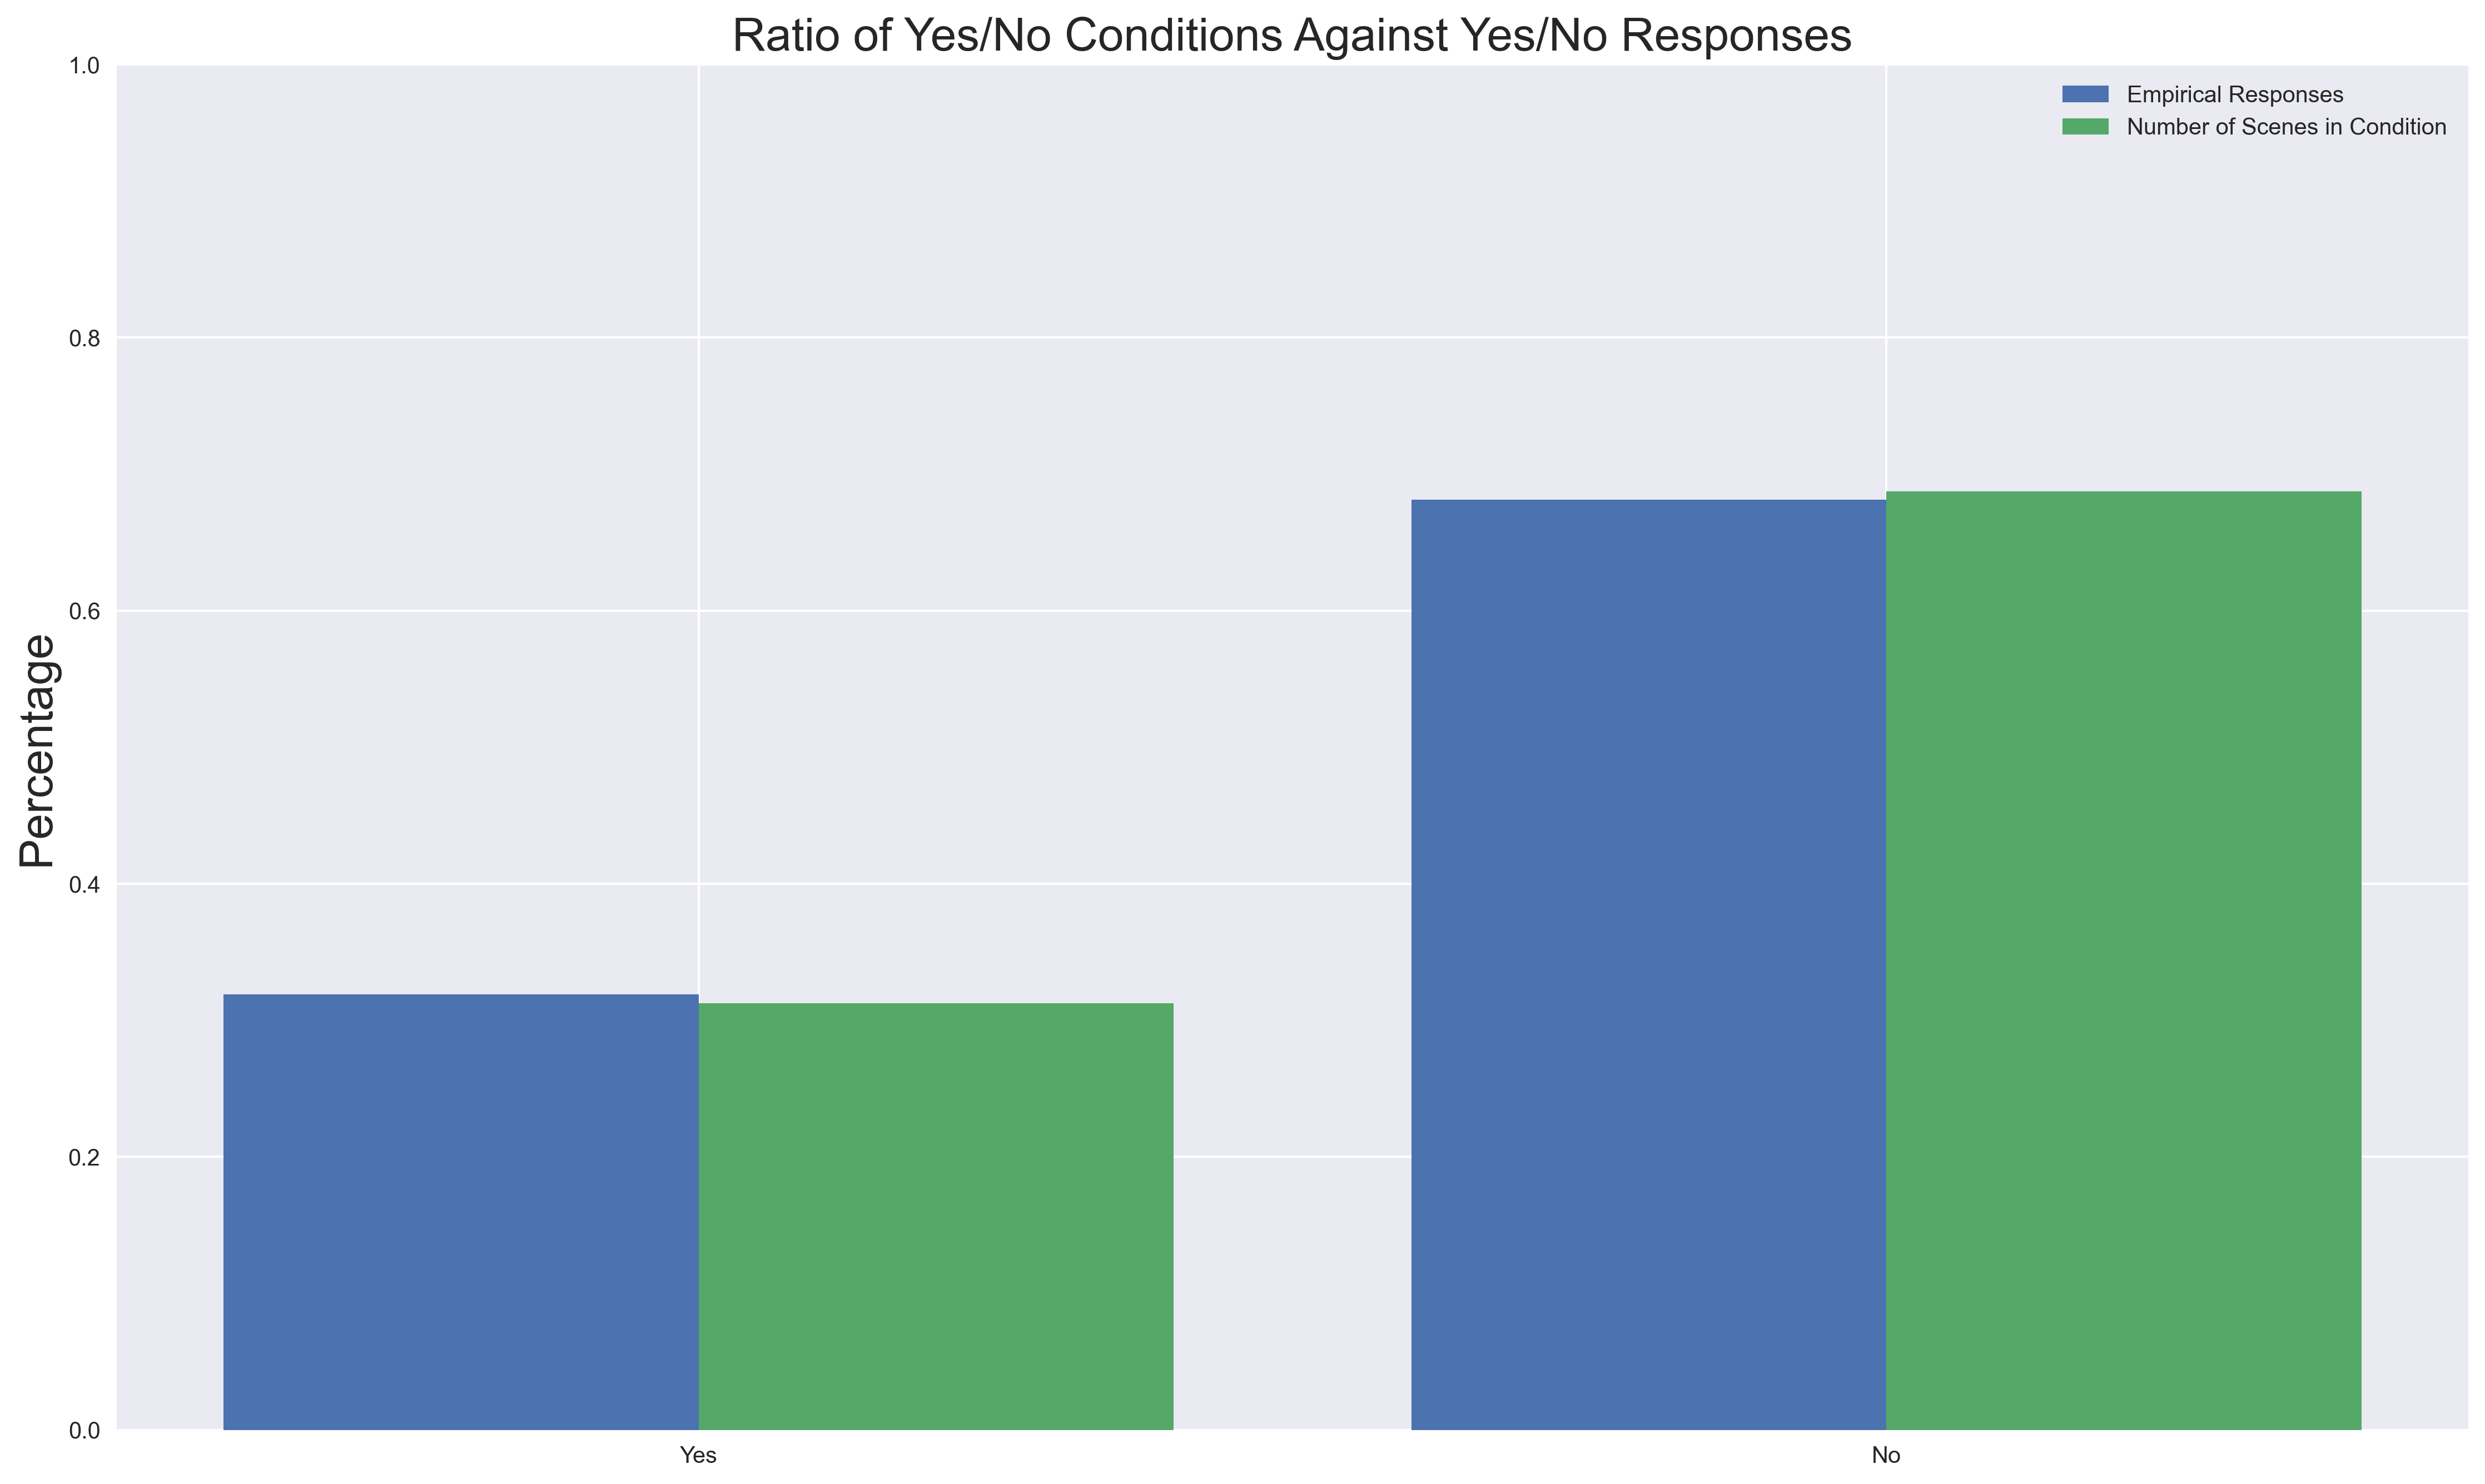

In [21]:
# What condition is each scene? (e.g. does the ball reach the goal or not)
conditions = responses.groupby("scene").trial_condition.apply(lambda x: list(x)[0])

# What did participants respond?
participants = responses.groupby("response").response.apply(list)

# Number of "Yes" scenes
yes_conditions = len(conditions[conditions == "Yes"])
# Number of "No" scenes
no_conditions = len(conditions[conditions == "No"])
total_conditions = yes_conditions+no_conditions
#Compute ratio
yes_conditions/=total_conditions
no_conditions/=total_conditions

# Number of "Yes" scenes
yes_participants = len(participants['Yes'])
# Number of "No" scenes
no_participants = len(participants['No'])
# Compute ratio
total_participants = yes_participants+no_participants
yes_participants/=total_participants
no_participants/=total_participants

labels = ["Yes","No"]
participant_counts = [yes_participants,no_participants]
condition_counts = [yes_conditions,no_conditions]

x = np.arange(len(labels))  # the label locations
width = 0.40  # the width of the bars

fig, ax = plt.subplots(figsize=(15, 9),dpi=300)
rects1 = ax.bar(x - width/2, participant_counts, width, label='Empirical Responses')
rects2 = ax.bar(x + width/2, condition_counts, width, label='Number of Scenes in Condition')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percentage',fontsize=20)
ax.set_title('Ratio of Yes/No Conditions Against Yes/No Responses',fontsize=20)
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# ax.bar_label(rects1, padding=3)
# ax.bar_label(rects2, padding=3)
plt.ylim(0,1)
fig.tight_layout()
plt.show()

#### Number of scenes in each condition

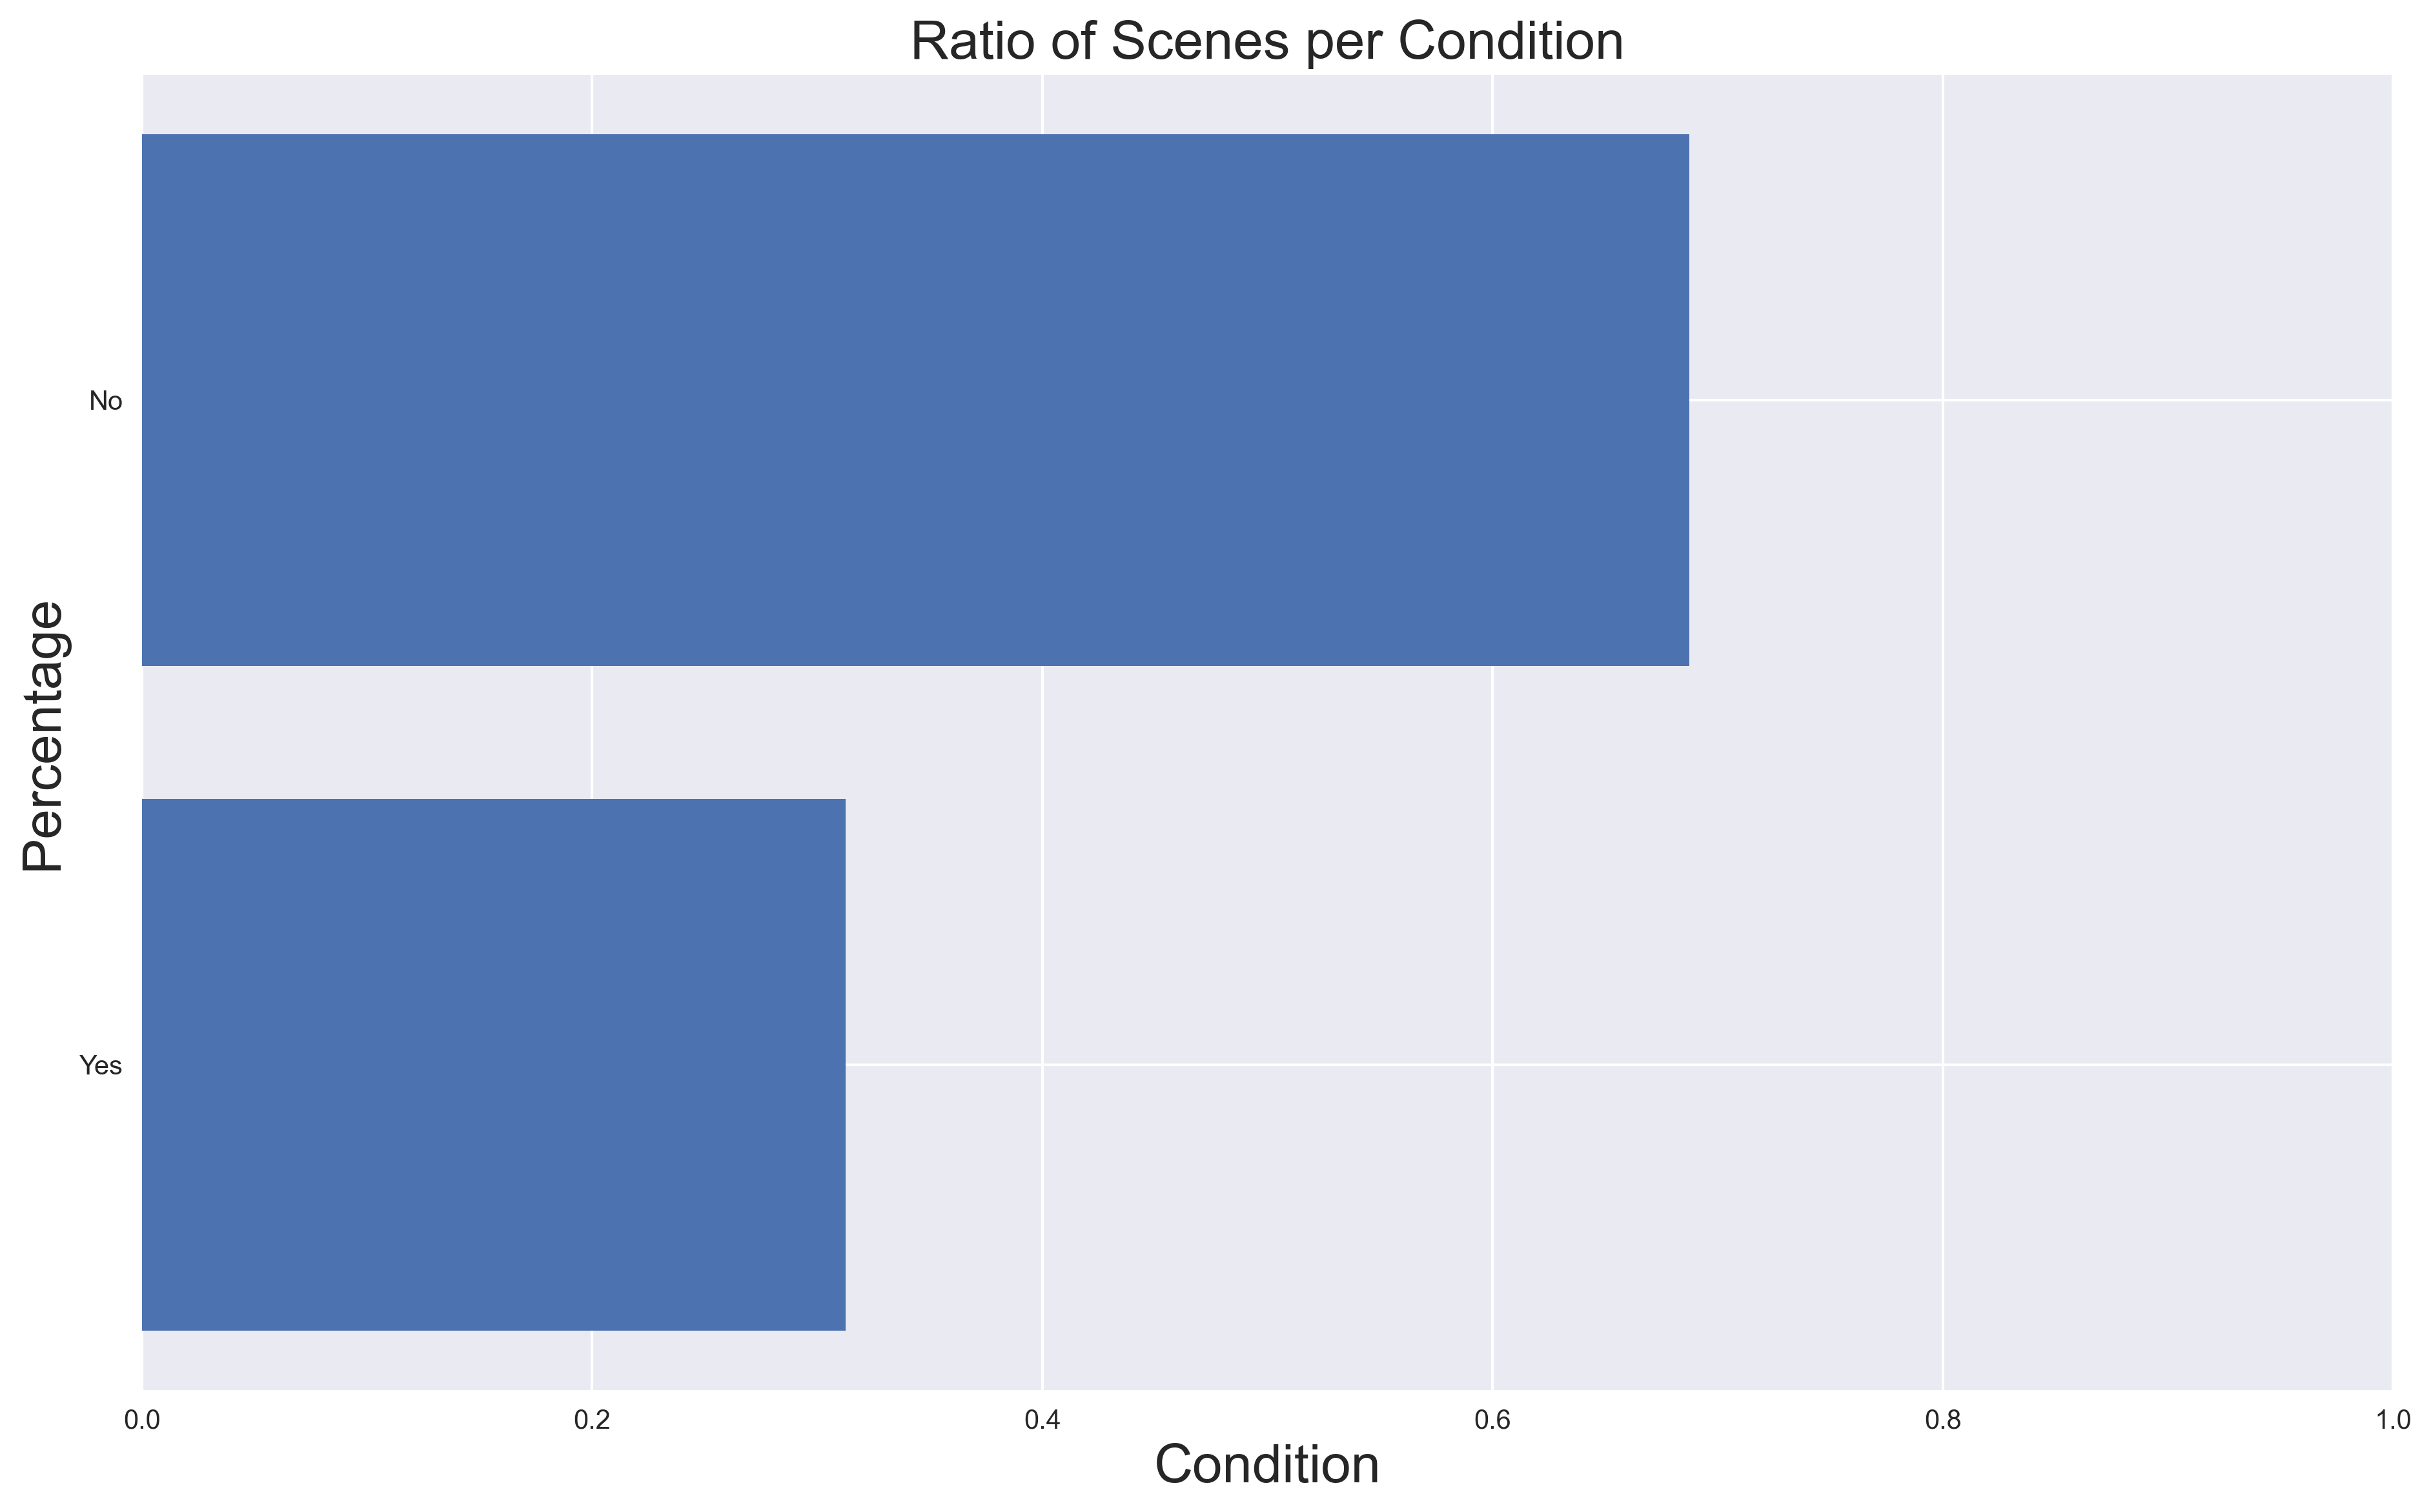

In [22]:
# What condition is each scene? (e.g. does the ball reach the goal or not)
y = responses.groupby("scene").trial_condition.apply(lambda x: list(x)[0])
# Number of "Yes" scenes
yes = len(y[y == "Yes"])
# # Number of "No" scenes
no = len(y[y == "No"])
total = yes+no

yes/=total
no/=total
figure(figsize=(15, 9), dpi=300)
plt.barh(["Yes","No"], [yes,no])
plt.xlim(0,1)
plt.title("Ratio of Scenes per Condition",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xlabel("Condition",fontsize=20);

#### Number of responses across conditions

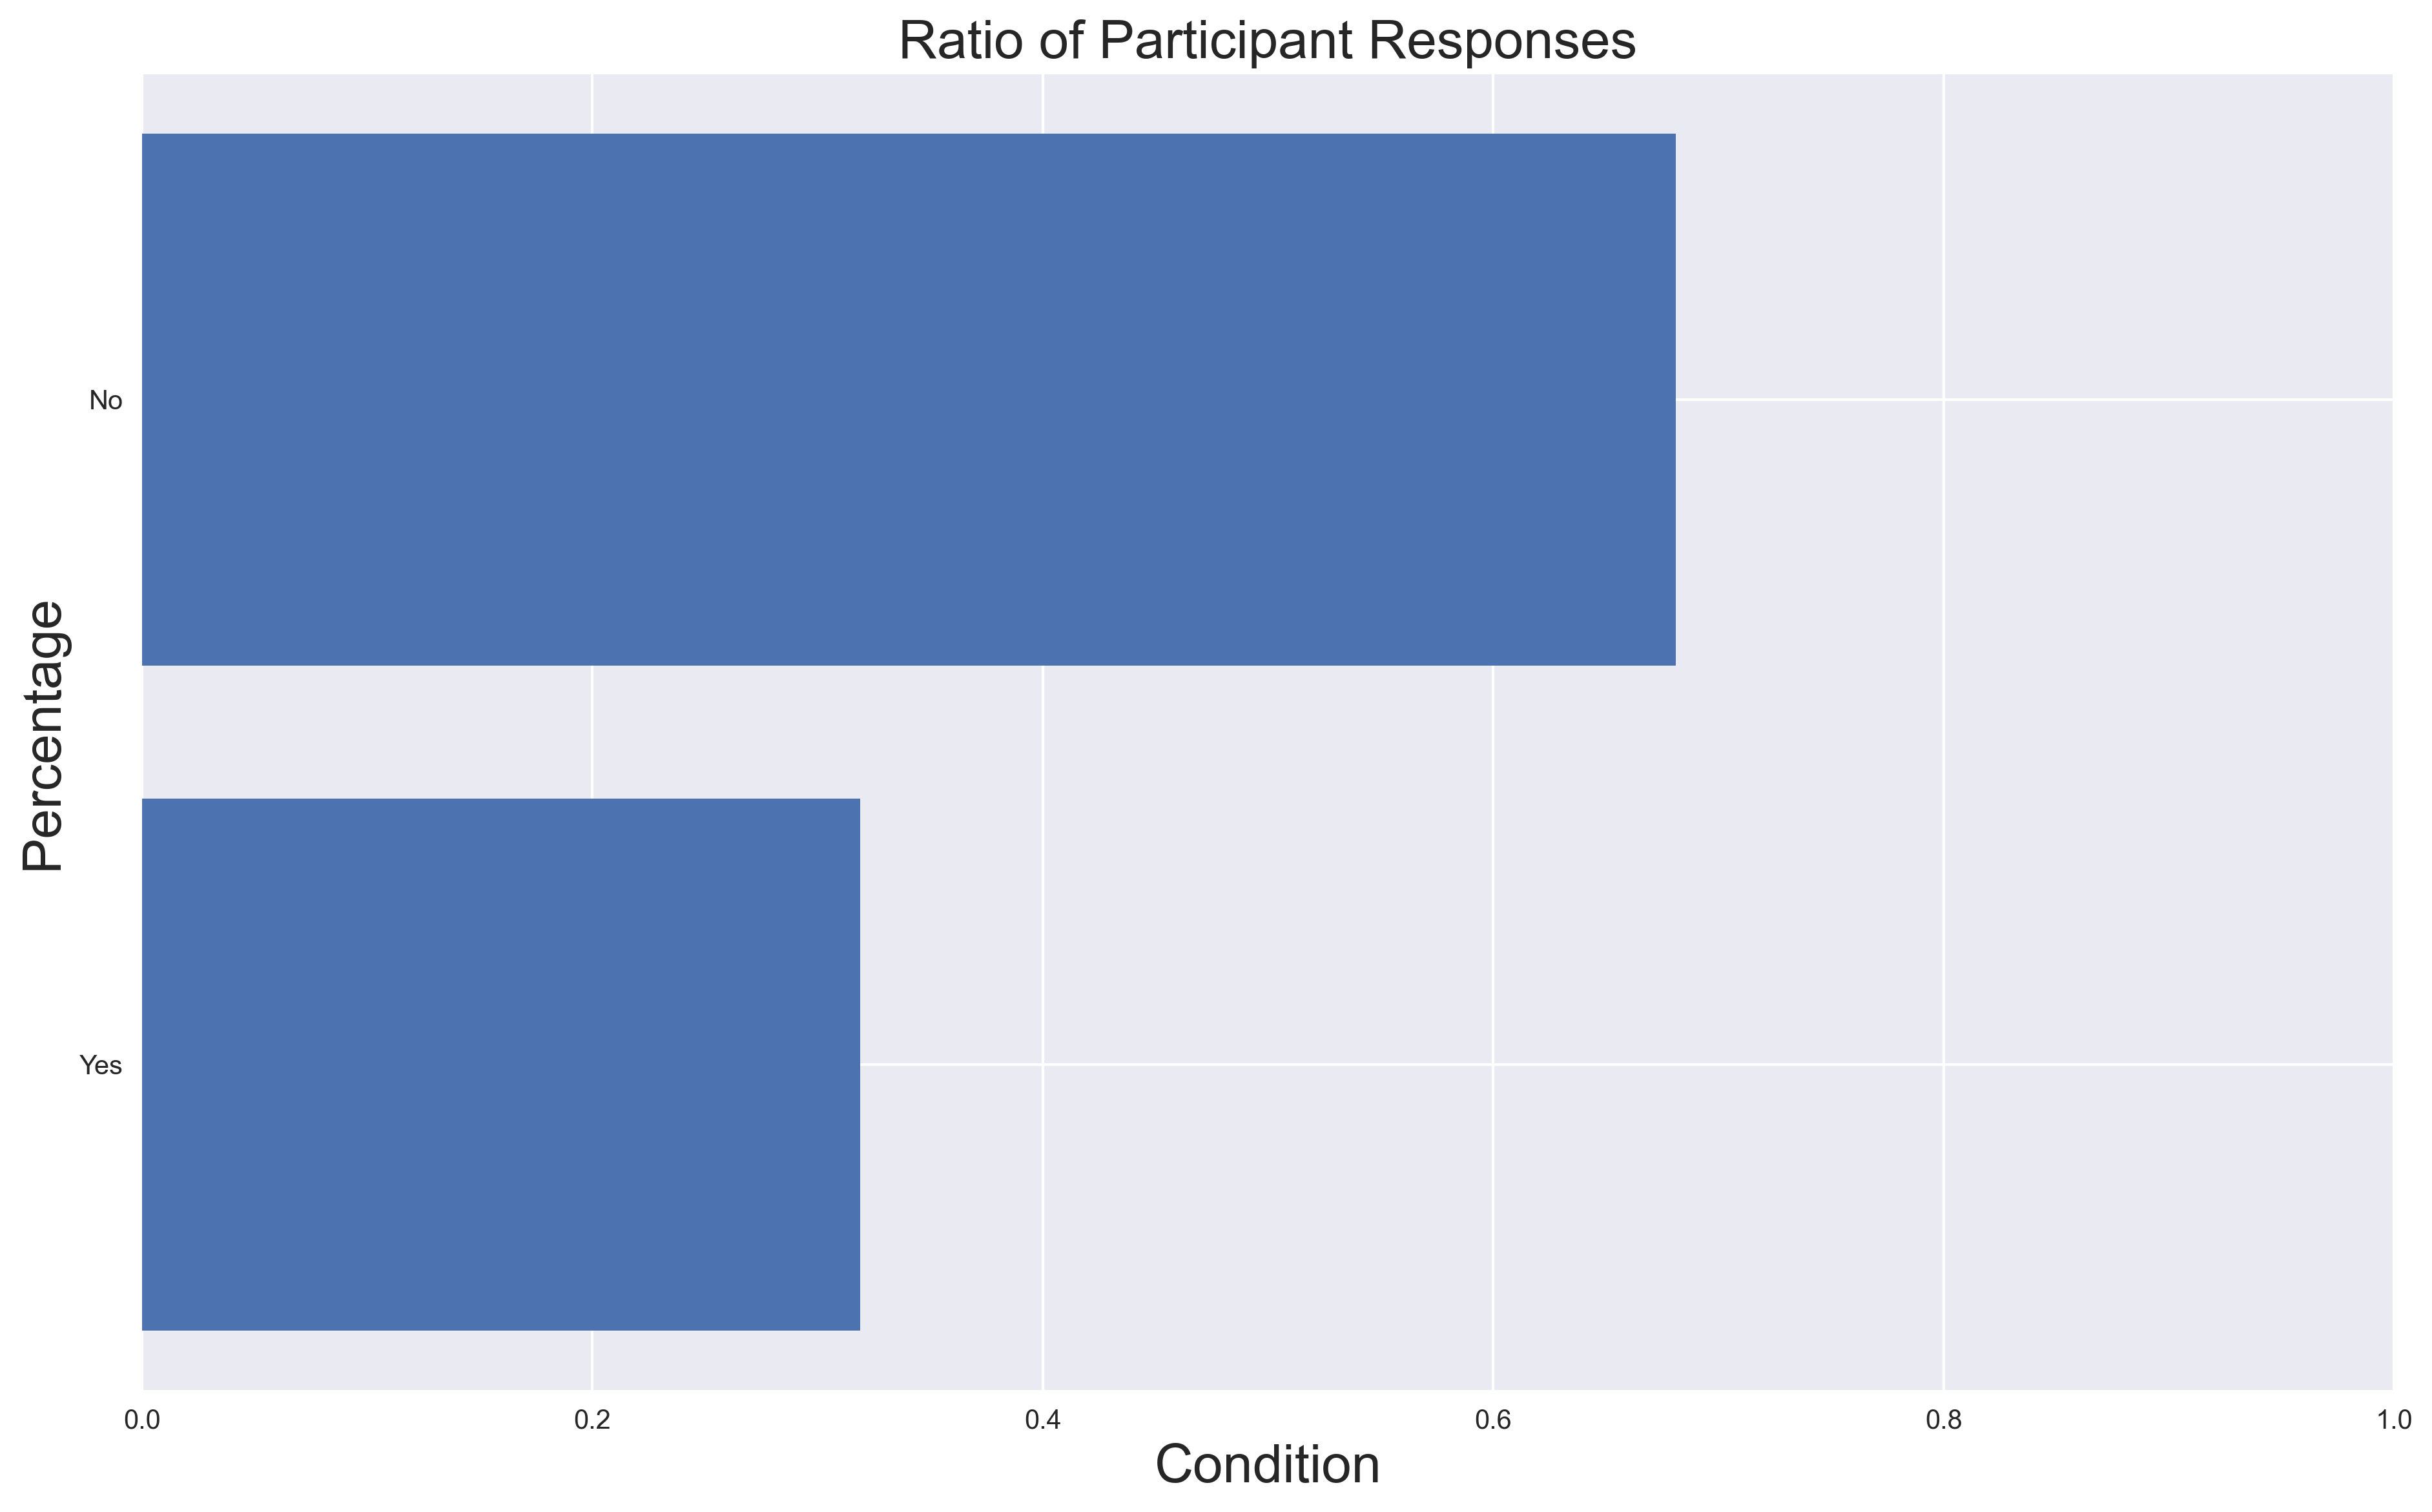

In [23]:
# What condition is each scene? (e.g. does the ball reach the goal or not)
y = responses.groupby("response").response.apply(list)

# Number of "Yes" scenes
yes = len(y['Yes'])
# Number of "No" scenes
no = len(y['No'])
total = yes+no

yes/=total
no/=total
figure(figsize=(15, 9), dpi=300)
plt.barh(["Yes","No"], [yes,no])
plt.xlim(0,1)
plt.title("Ratio of Participant Responses",fontsize=20)
plt.ylabel("Percentage",fontsize=20)
plt.xlabel("Condition",fontsize=20);

#### Overall accuracy per condition across participants

#### Accuracy per trial across participants

In [24]:
responses.participant_accuracy.describe()

count    4463.000000
mean        0.874164
std         0.067098
min         0.614583
25%         0.833333
50%         0.885417
75%         0.927083
max         0.947917
Name: participant_accuracy, dtype: float64

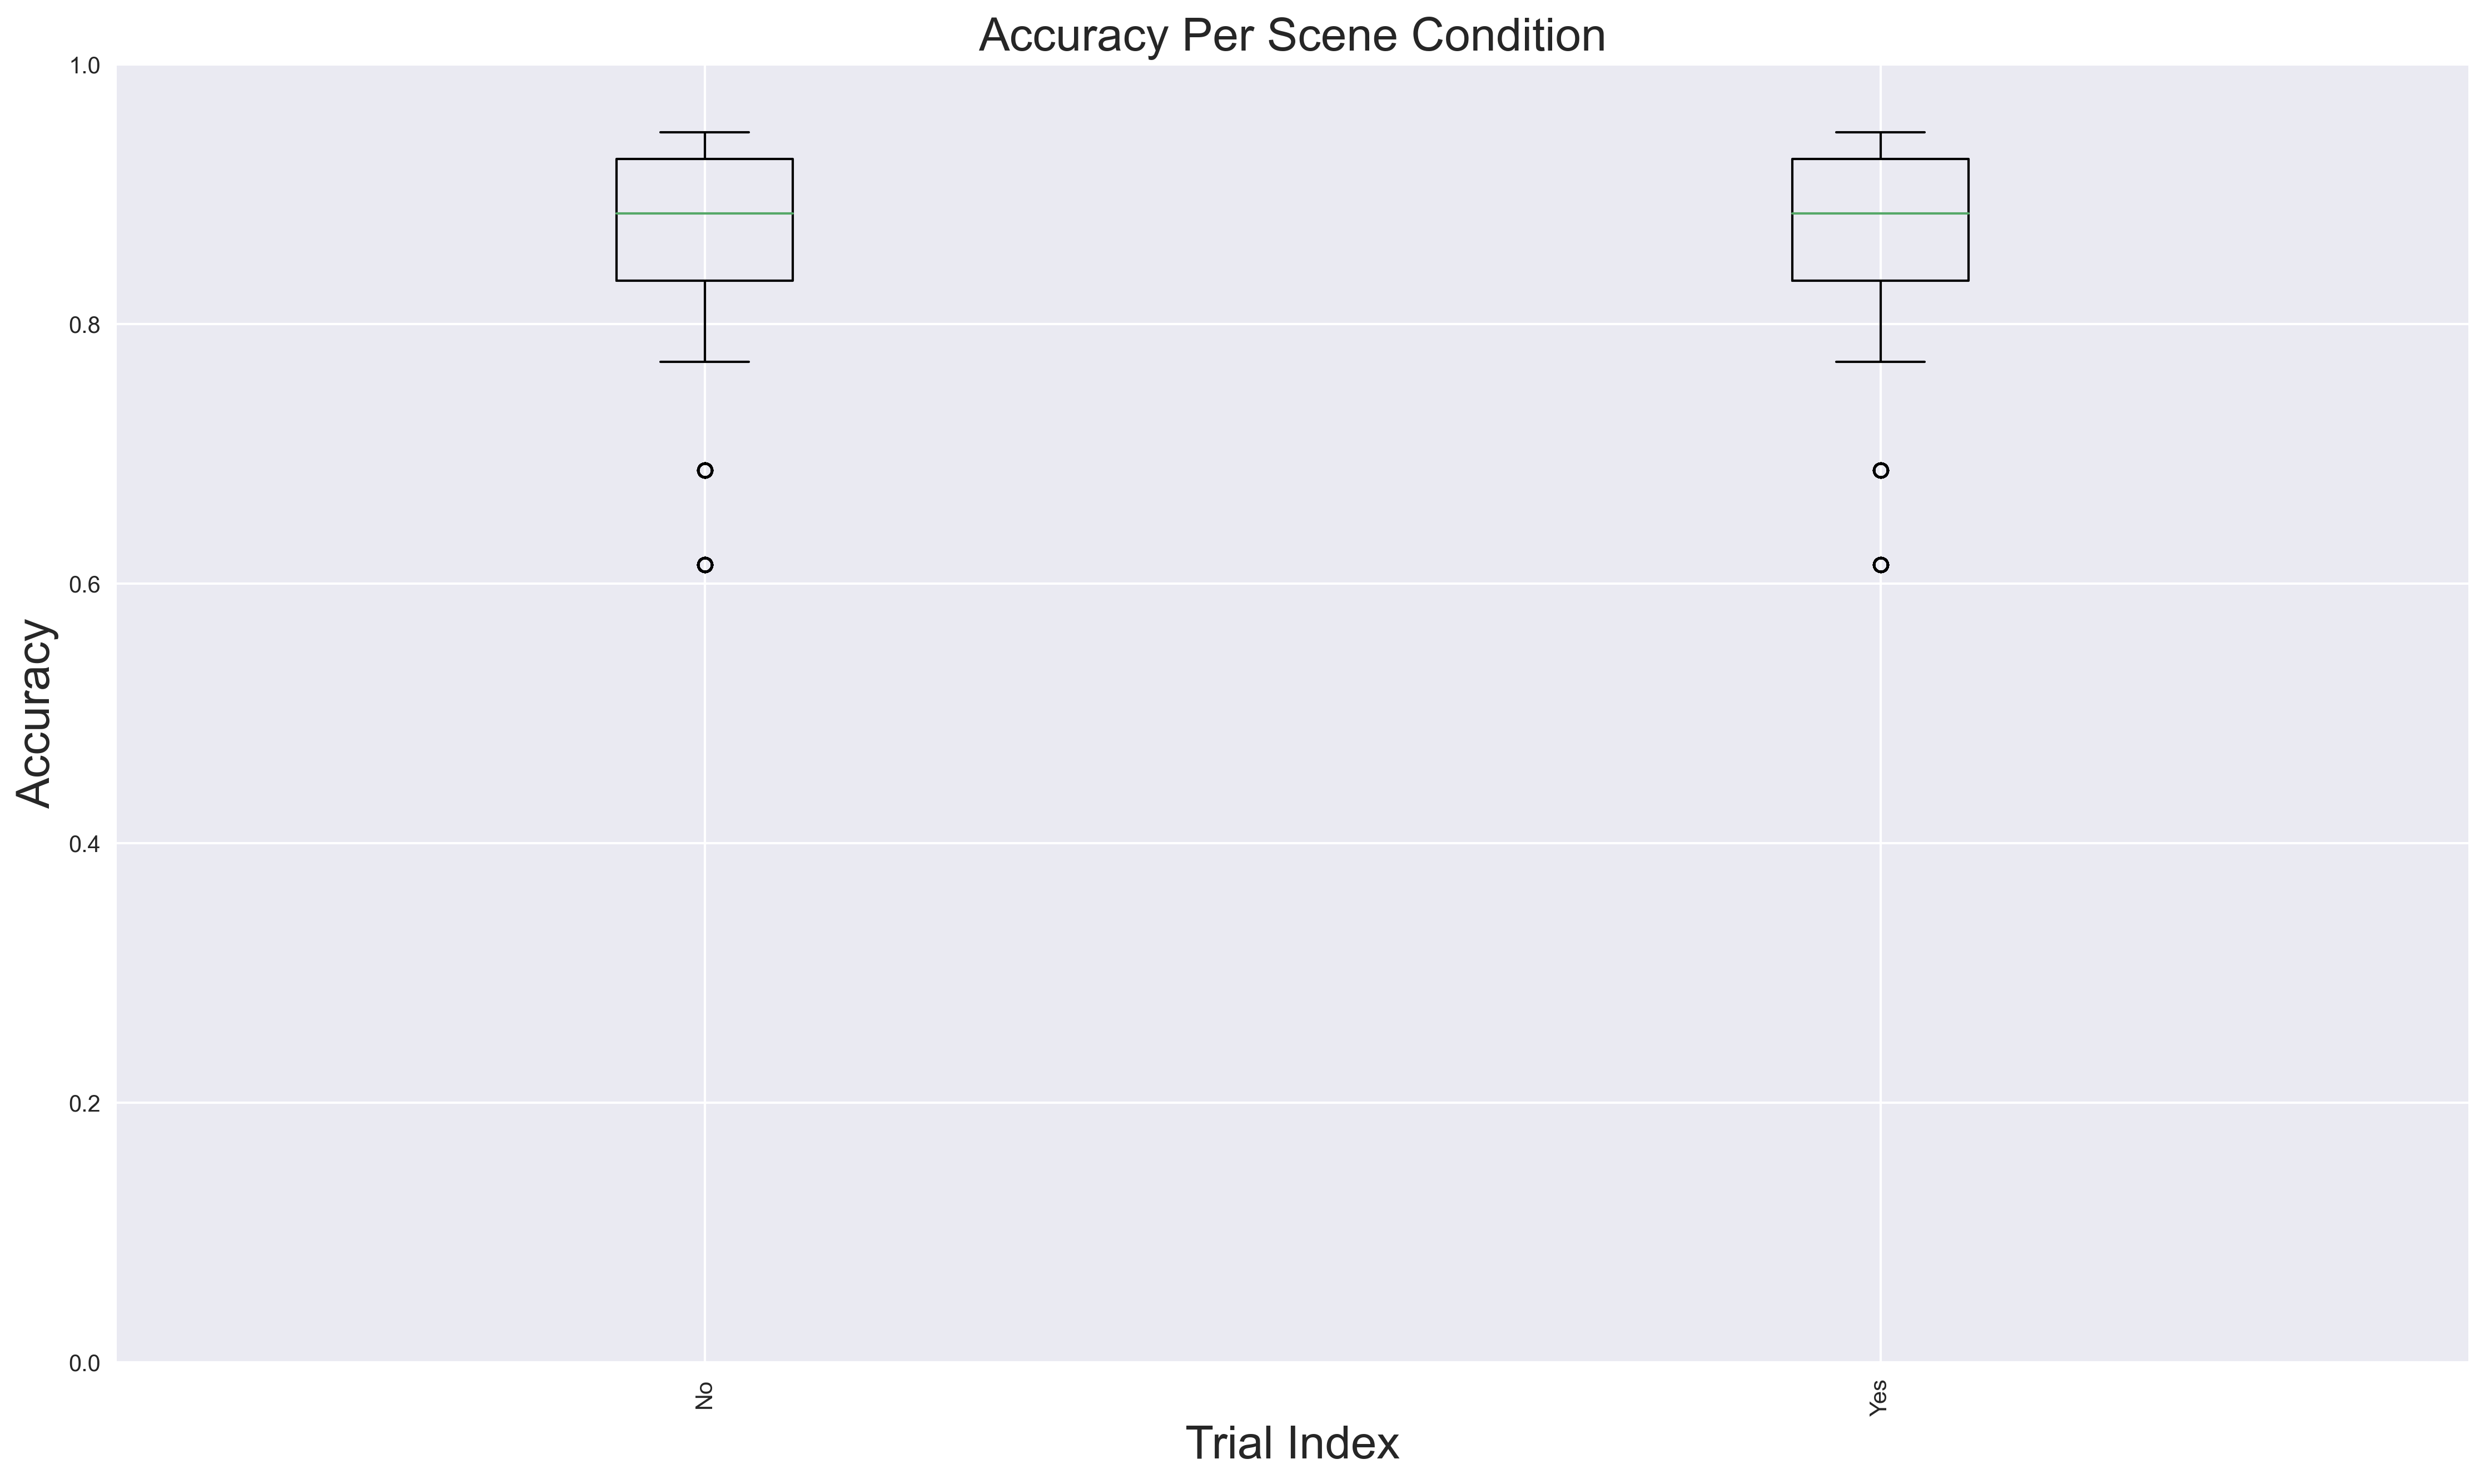

In [25]:
trial=responses.groupby("trial_condition").participant_accuracy.apply(list)
figure(figsize=(15, 9), dpi=300)

plt.boxplot(trial)
plt.xticks(rotation = 90)
plt.title("Accuracy Per Scene Condition",fontsize=20)
plt.ylim(0,1)
plt.xticks([1,2],["No","Yes"])
plt.xlabel("Trial Index",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

#### Accuracy per trial

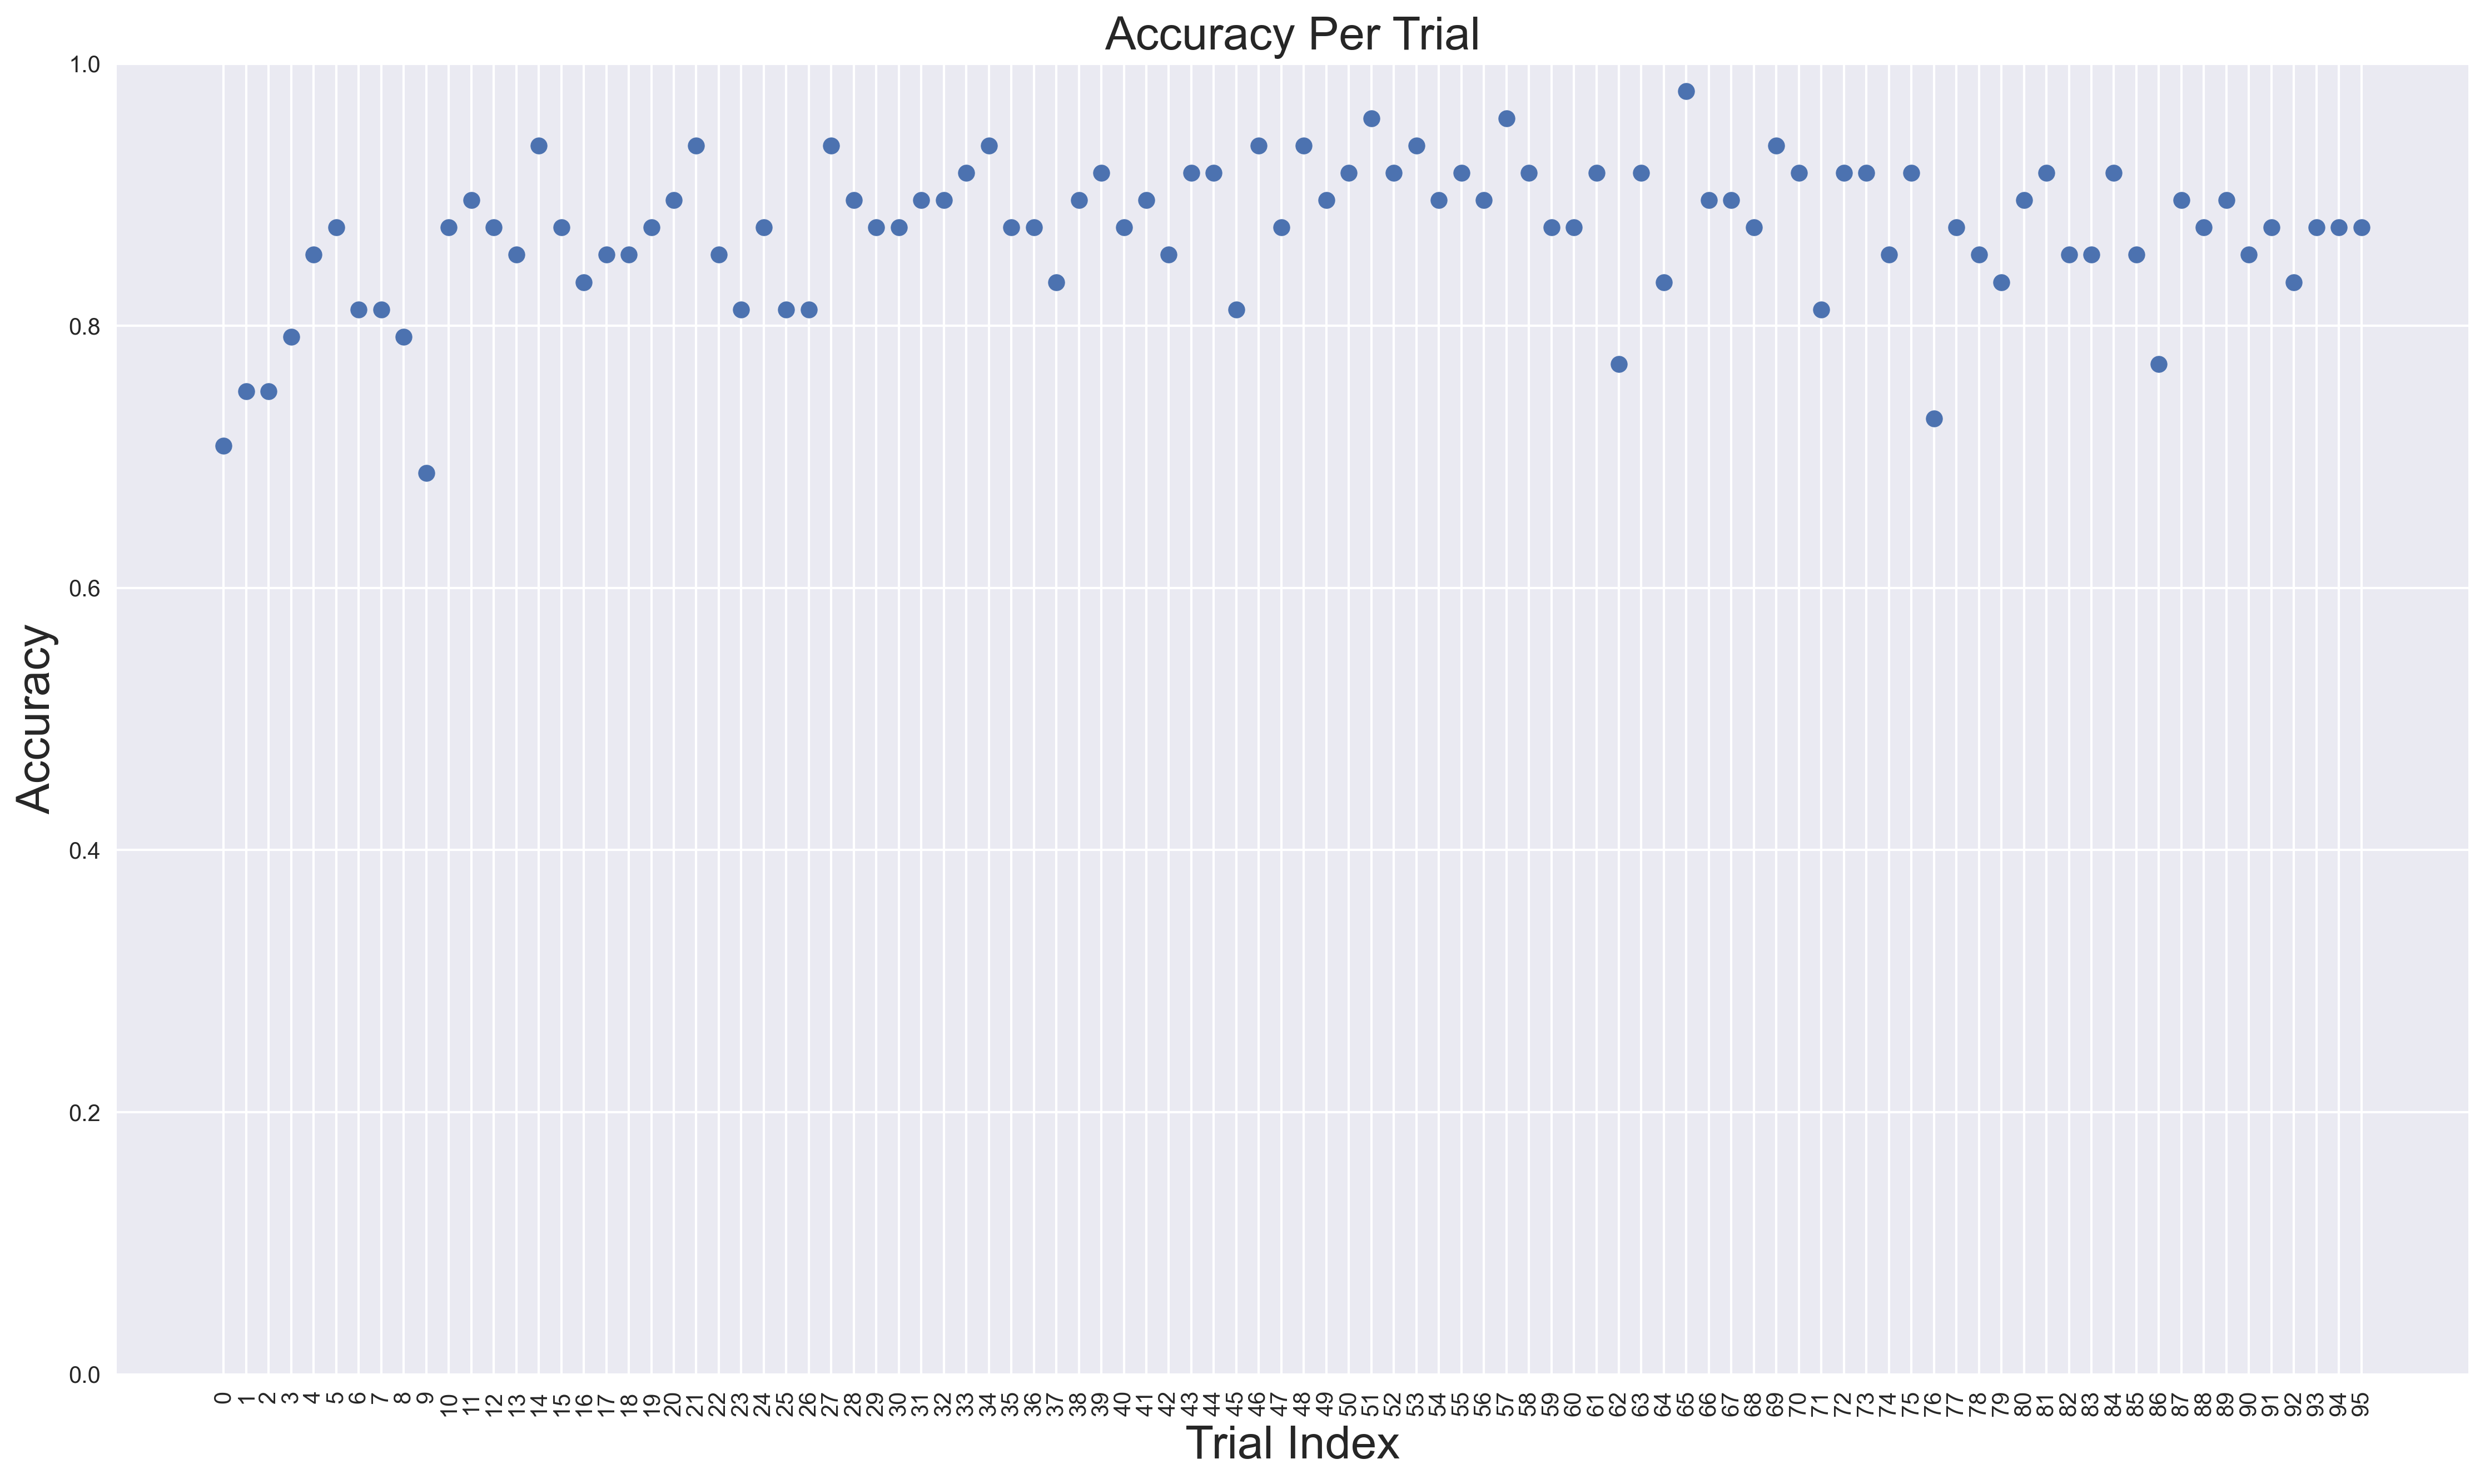

In [26]:
trial_y=responses.groupby("trial_index").trial_accuracy.mean()
trial_x=list(range(len(trial_y)))
figure(figsize=(15, 9), dpi=300)

plt.scatter(trial_x,trial_y)
plt.xticks(rotation = 90)
plt.title("Accuracy Per Trial",fontsize=20)
plt.ylim(0,1)
plt.xticks(trial_x,trial_x)
plt.xlabel("Trial Index",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

#### Accuracy per scene

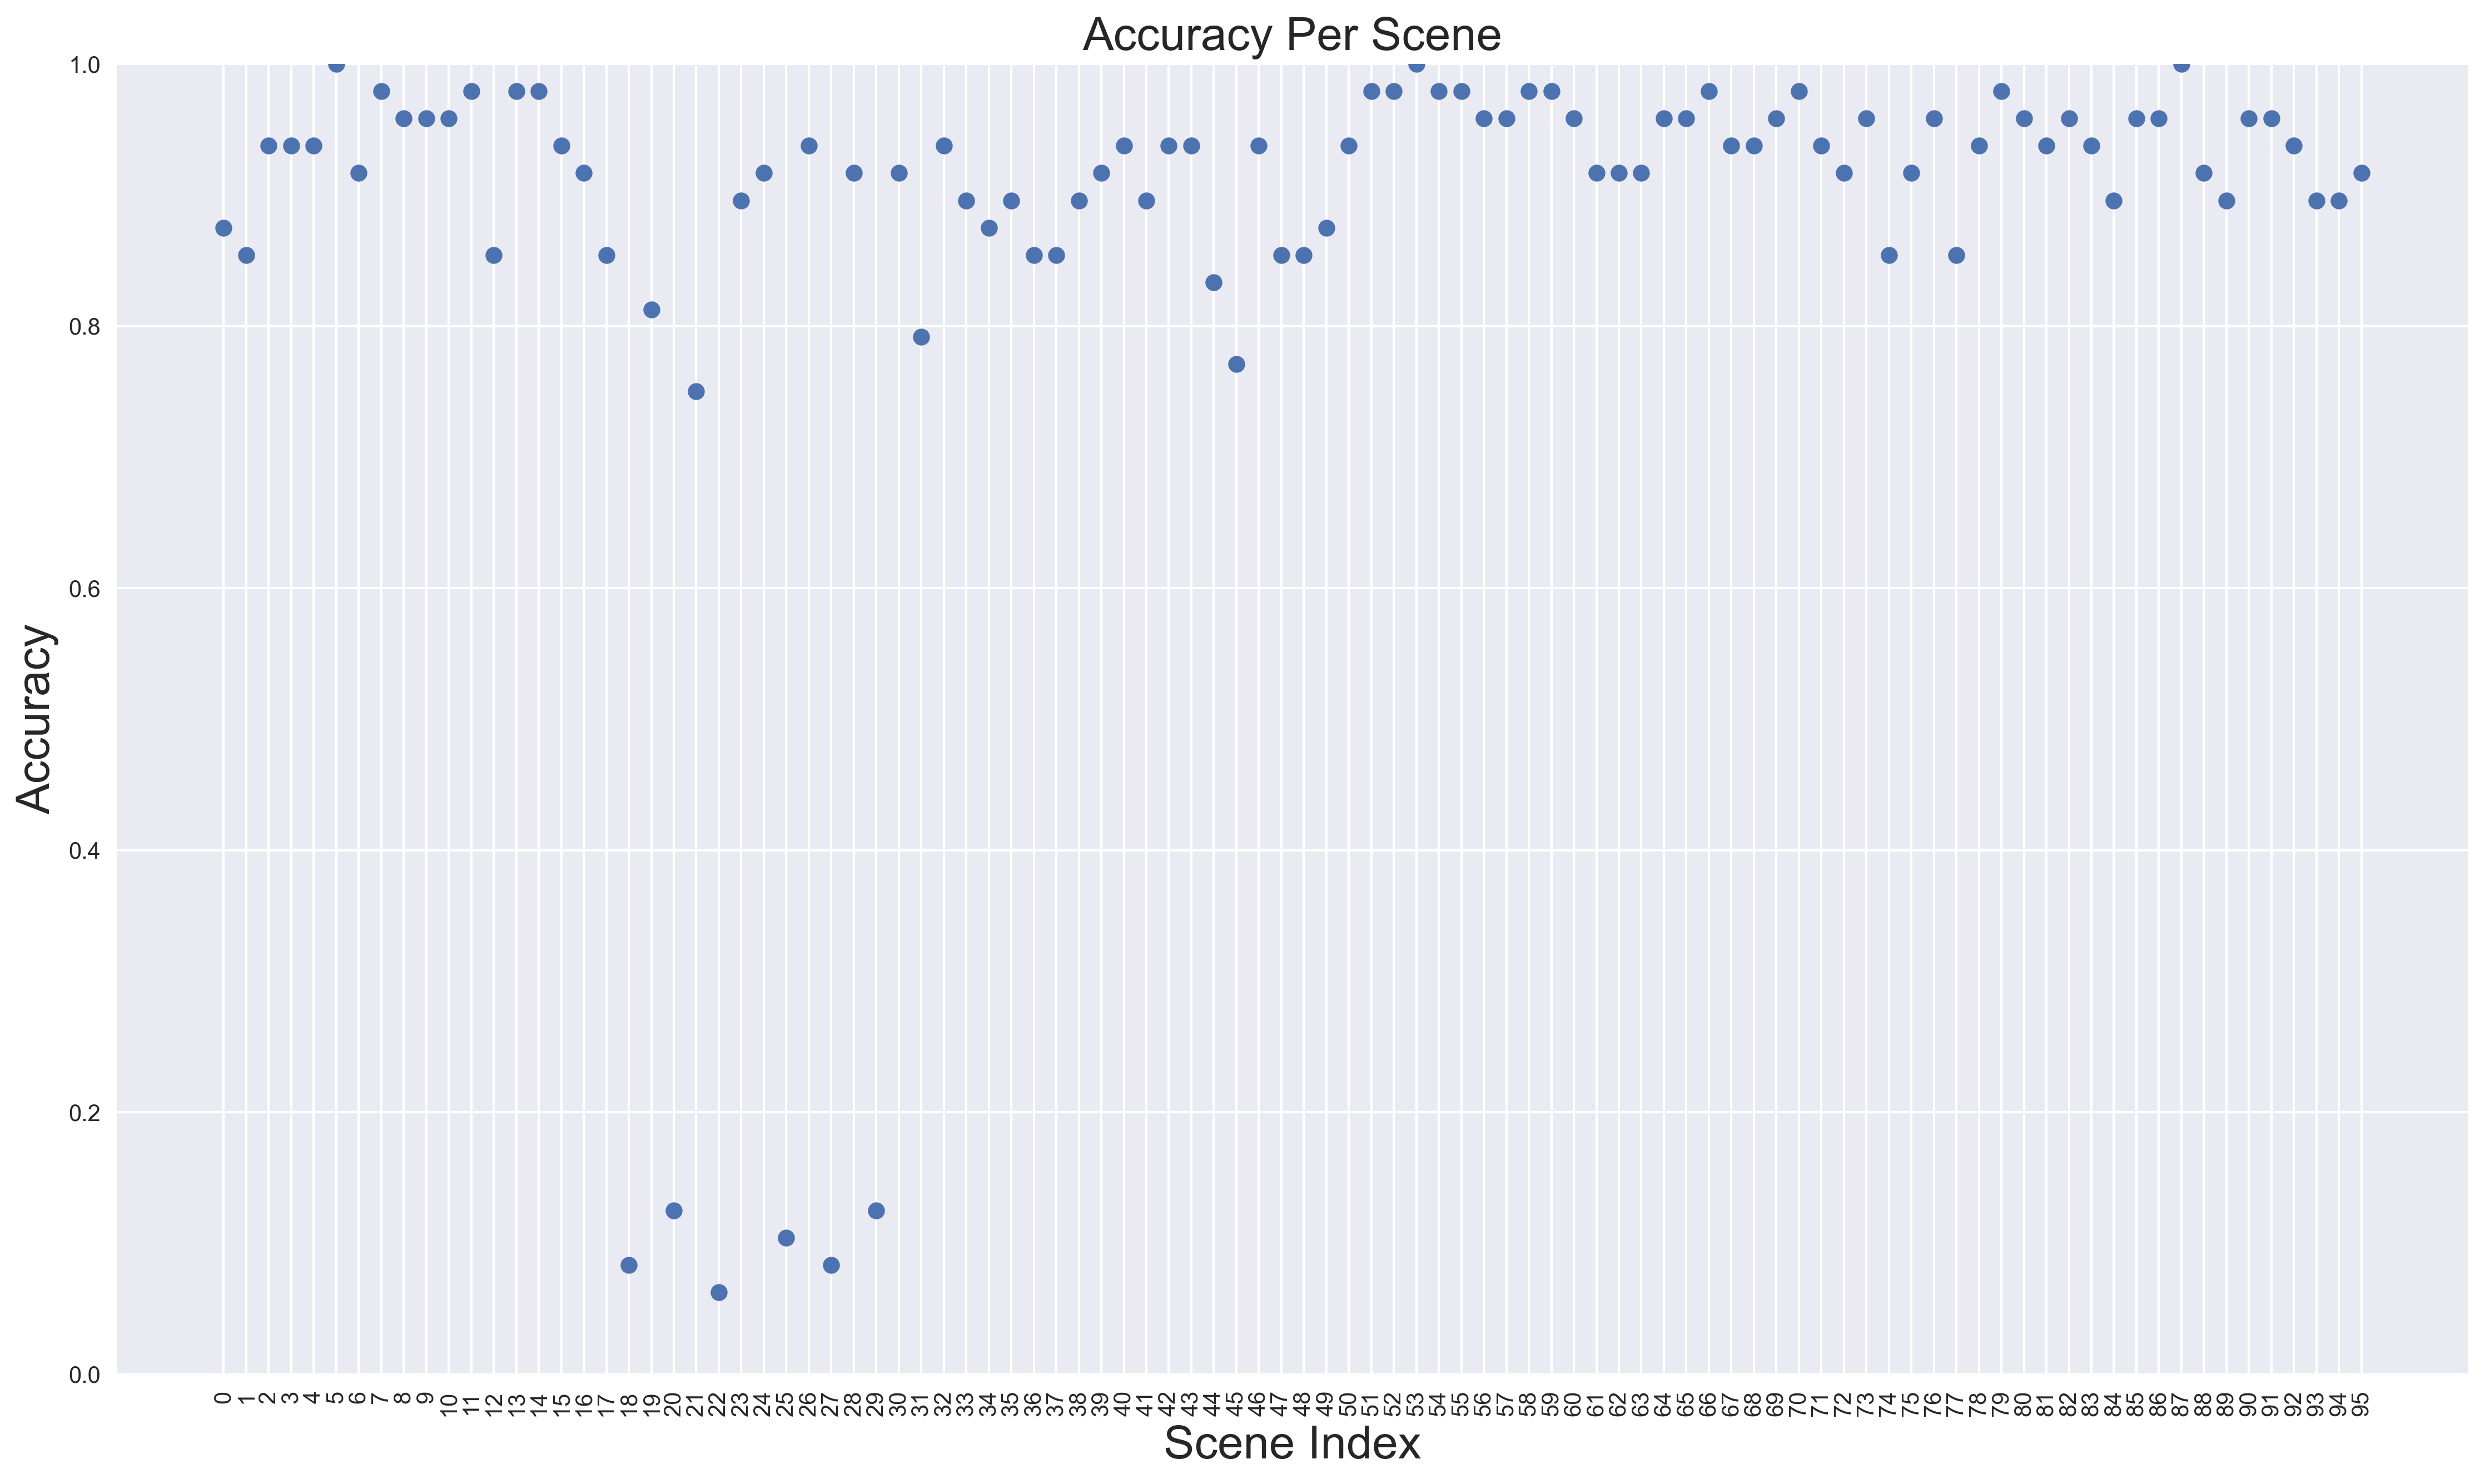

In [27]:
trial_y=responses.groupby("scene").scene_accuracy.mean()
trial_x=list(range(len(trial_y)))
figure(figsize=(15, 9), dpi=300)

plt.scatter(trial_x,trial_y)
plt.xticks(rotation = 90)
plt.title("Accuracy Per Scene",fontsize=20)
plt.ylim(0,1)
plt.xticks(trial_x,trial_x)
plt.xlabel("Scene Index",fontsize=20)
plt.ylabel("Accuracy",fontsize=20)
plt.tight_layout()
plt.show()

#### Where were some scenes shown?

In [311]:
responses.groupby("scene").trial_index.value_counts()['scene_22']
# trial_x=list(range(len(trial_y)))
# figure(figsize=(15, 9), dpi=300)

# plt.scatter(trial_x,trial_y)
# plt.xticks(rotation = 90)
# plt.title("Accuracy Per Scene")
# plt.ylim(0,1)
# plt.xticks(trial_x,trial_x)
# plt.xlabel("Scene Index")
# plt.ylabel("Accuracy")
# plt.tight_layout()
# plt.show()

trial_index
4     3
7     2
12    2
22    2
23    2
31    2
72    2
74    2
80    2
81    2
83    2
0     1
6     1
8     1
10    1
11    1
15    1
19    1
21    1
33    1
35    1
41    1
44    1
47    1
54    1
59    1
60    1
64    1
67    1
69    1
70    1
73    1
77    1
88    1
90    1
92    1
Name: trial_index, dtype: int64

#### Log-RT per participant

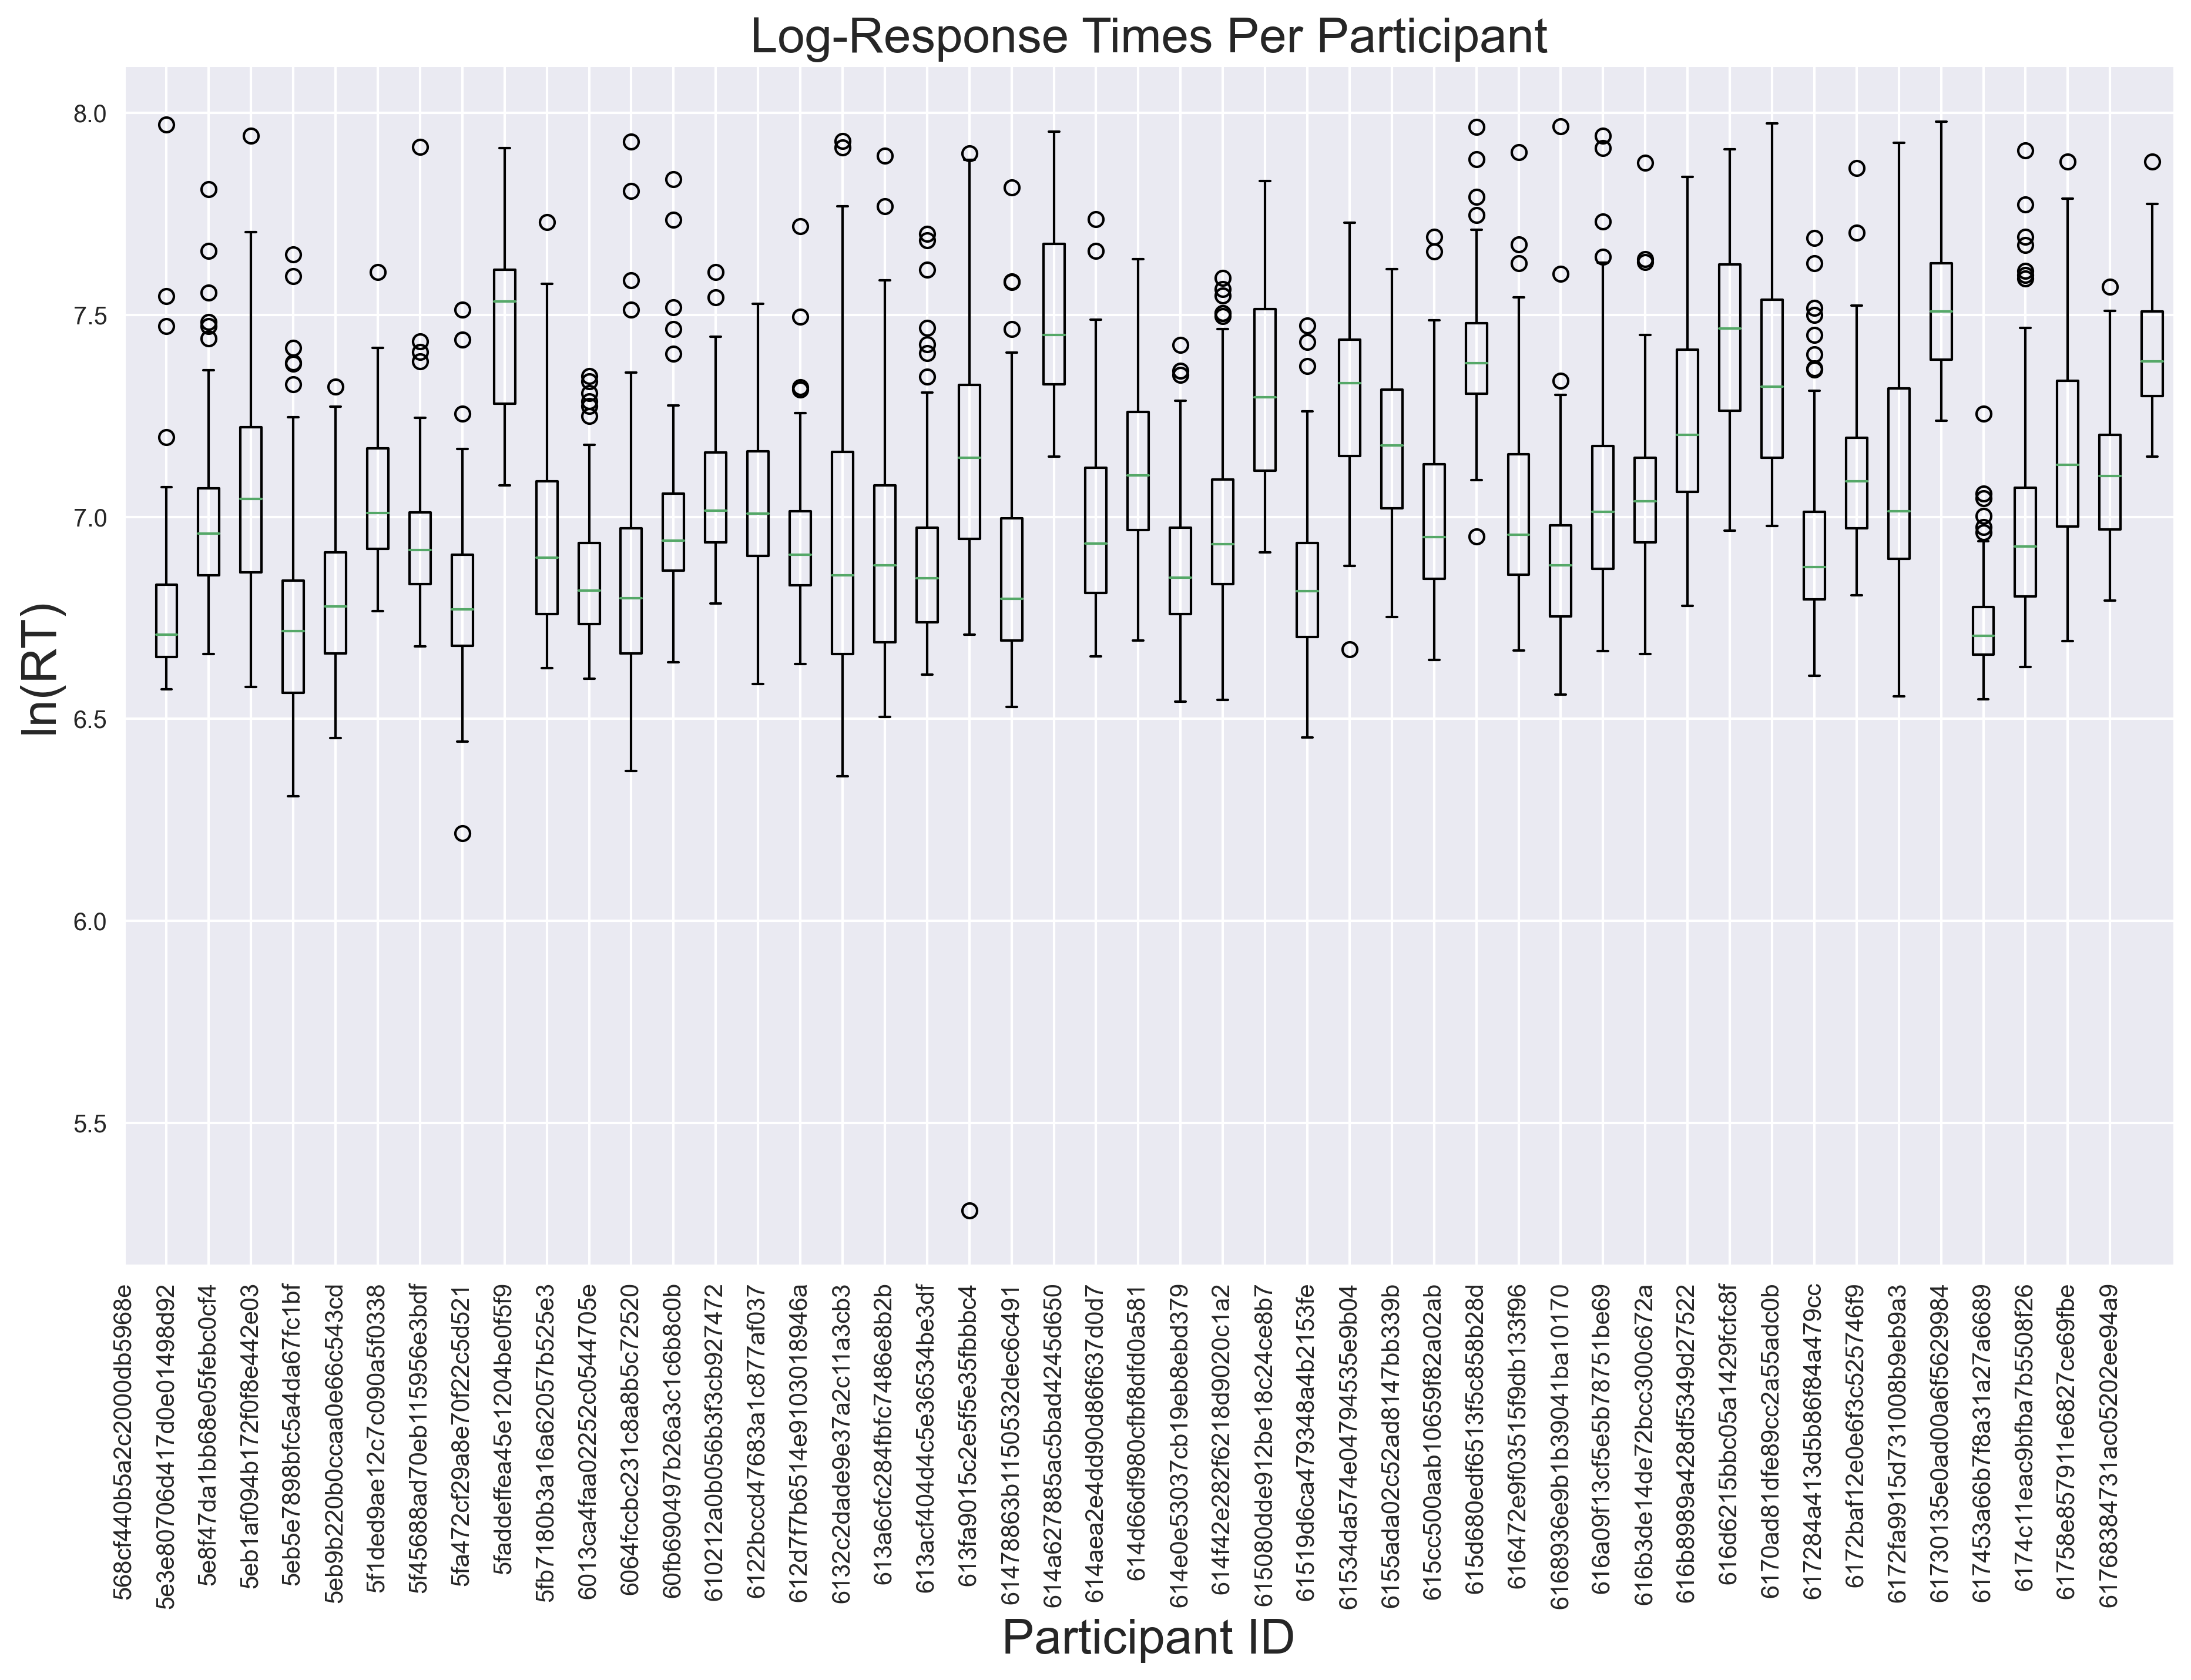

In [29]:
figure(figsize=(15, 9), dpi=300)
plt.boxplot(responses.groupby('subject_id').log_rt.apply(list))
plt.title("Log-Response Times Per Participant",fontsize=20)
plt.xlabel("Participant ID",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xticks(list(range(len(responses.groupby('subject_id').log_rt.apply(list)))), 
           responses.groupby('subject_id').log_rt.apply(list).index,
           rotation=90);

In [69]:
# Mean RT
rt_mean = responses.groupby(["scene"]).rt.mean()

# Mean RT for trials where ball is blocked or unable to reach goal
rt_mean_b = responses[responses["blocked"]==True].groupby(["scene"]).rt.mean()

# Mean RT for trials where ball is not blocked or able to reach goal
rt_mean_nb = responses[responses["blocked"]==False].groupby(["scene"]).rt.mean()

# RT and log(RT) grouped into lists for plotting
rt = responses.groupby(["scene"]).rt.apply(list)
log_rt = responses.groupby(["scene"]).log_rt.apply(list)

# RT and log(RT) for blocked trials grouped into lists for plotting
rt_b = responses[responses["blocked"]==True].groupby(["scene"]).rt.apply(list)
log_rt_b = responses[responses["blocked"]==True].groupby(["scene"]).log_rt.apply(list)

# RT and log(RT) for unblocked trials grouped into lists for plotting
rt_nb = responses[responses["blocked"]==False].groupby(["scene"]).rt.apply(list)
log_rt_nb = responses[responses["blocked"]==False].groupby(["scene"]).log_rt.apply(list)

## Normality tests

### Histograms

#### Cumulative Log RT

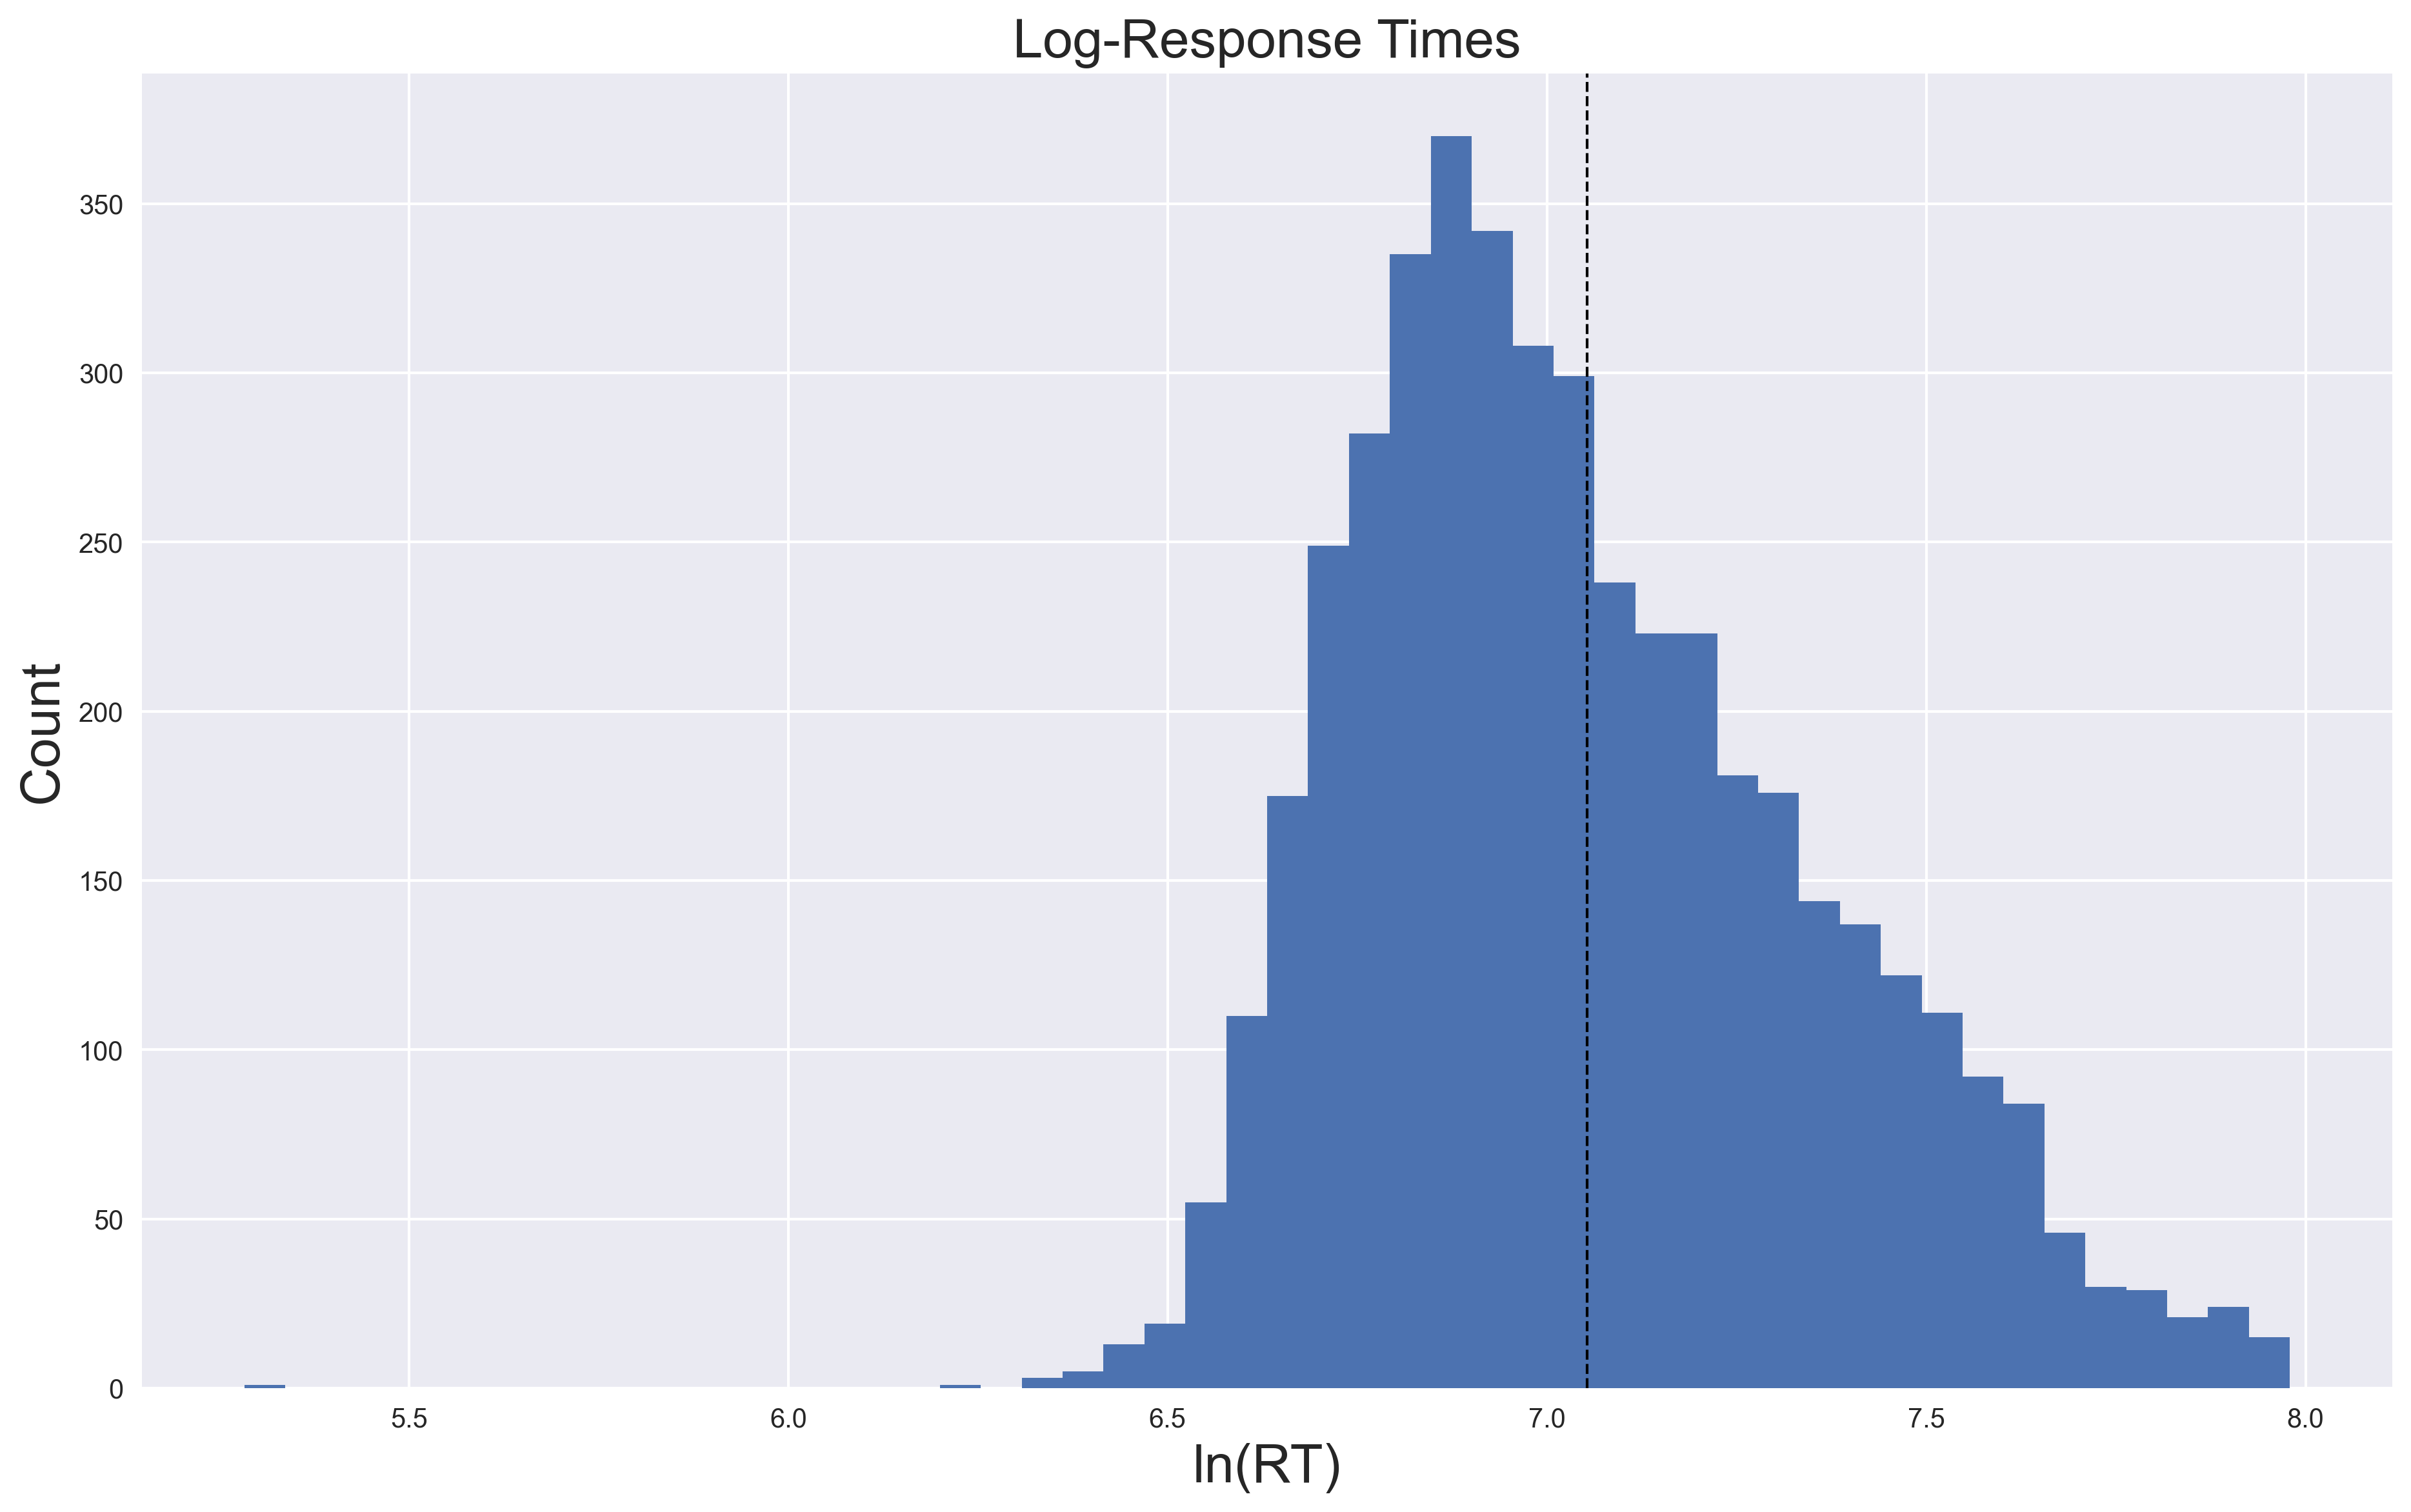

In [30]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses.log_rt, bins=50)
plt.axvline(responses.log_rt.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Log-Response Times",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.show()

#### Cumulative RT

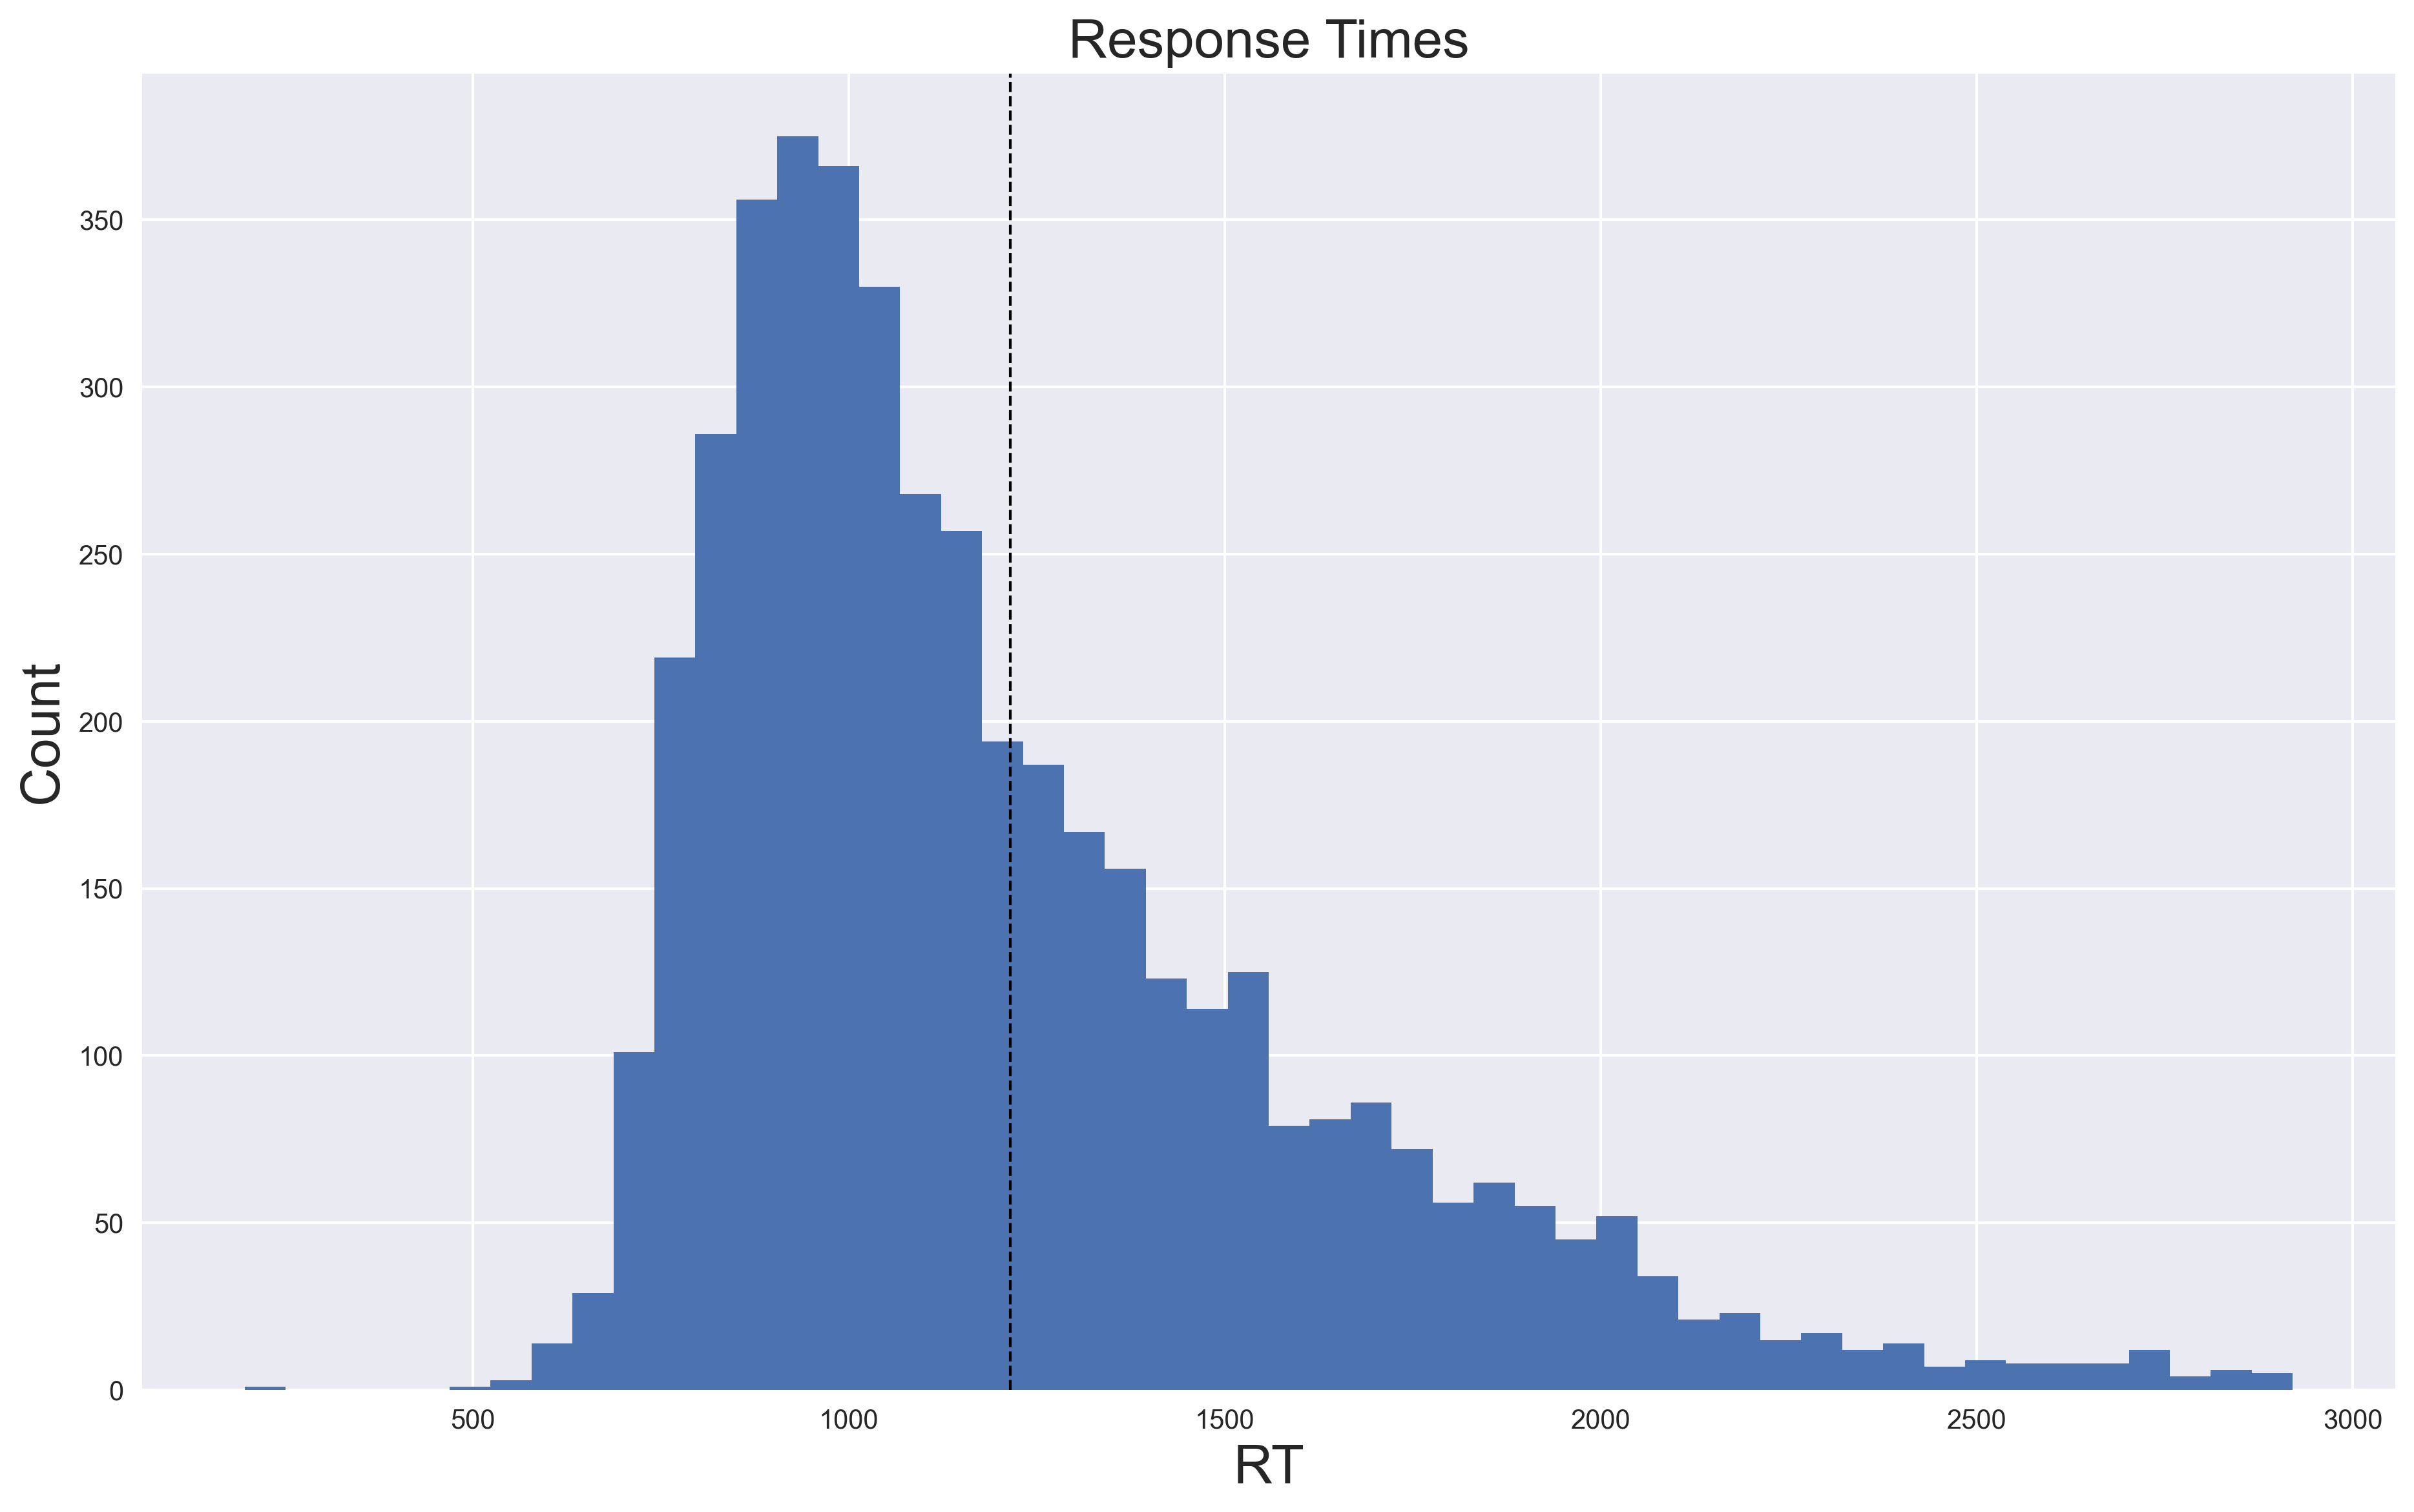

In [31]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses.rt, bins=50)
plt.axvline(responses.rt.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Response Times",fontsize=20)
plt.xlabel("RT",fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.show()

### QQ Plots

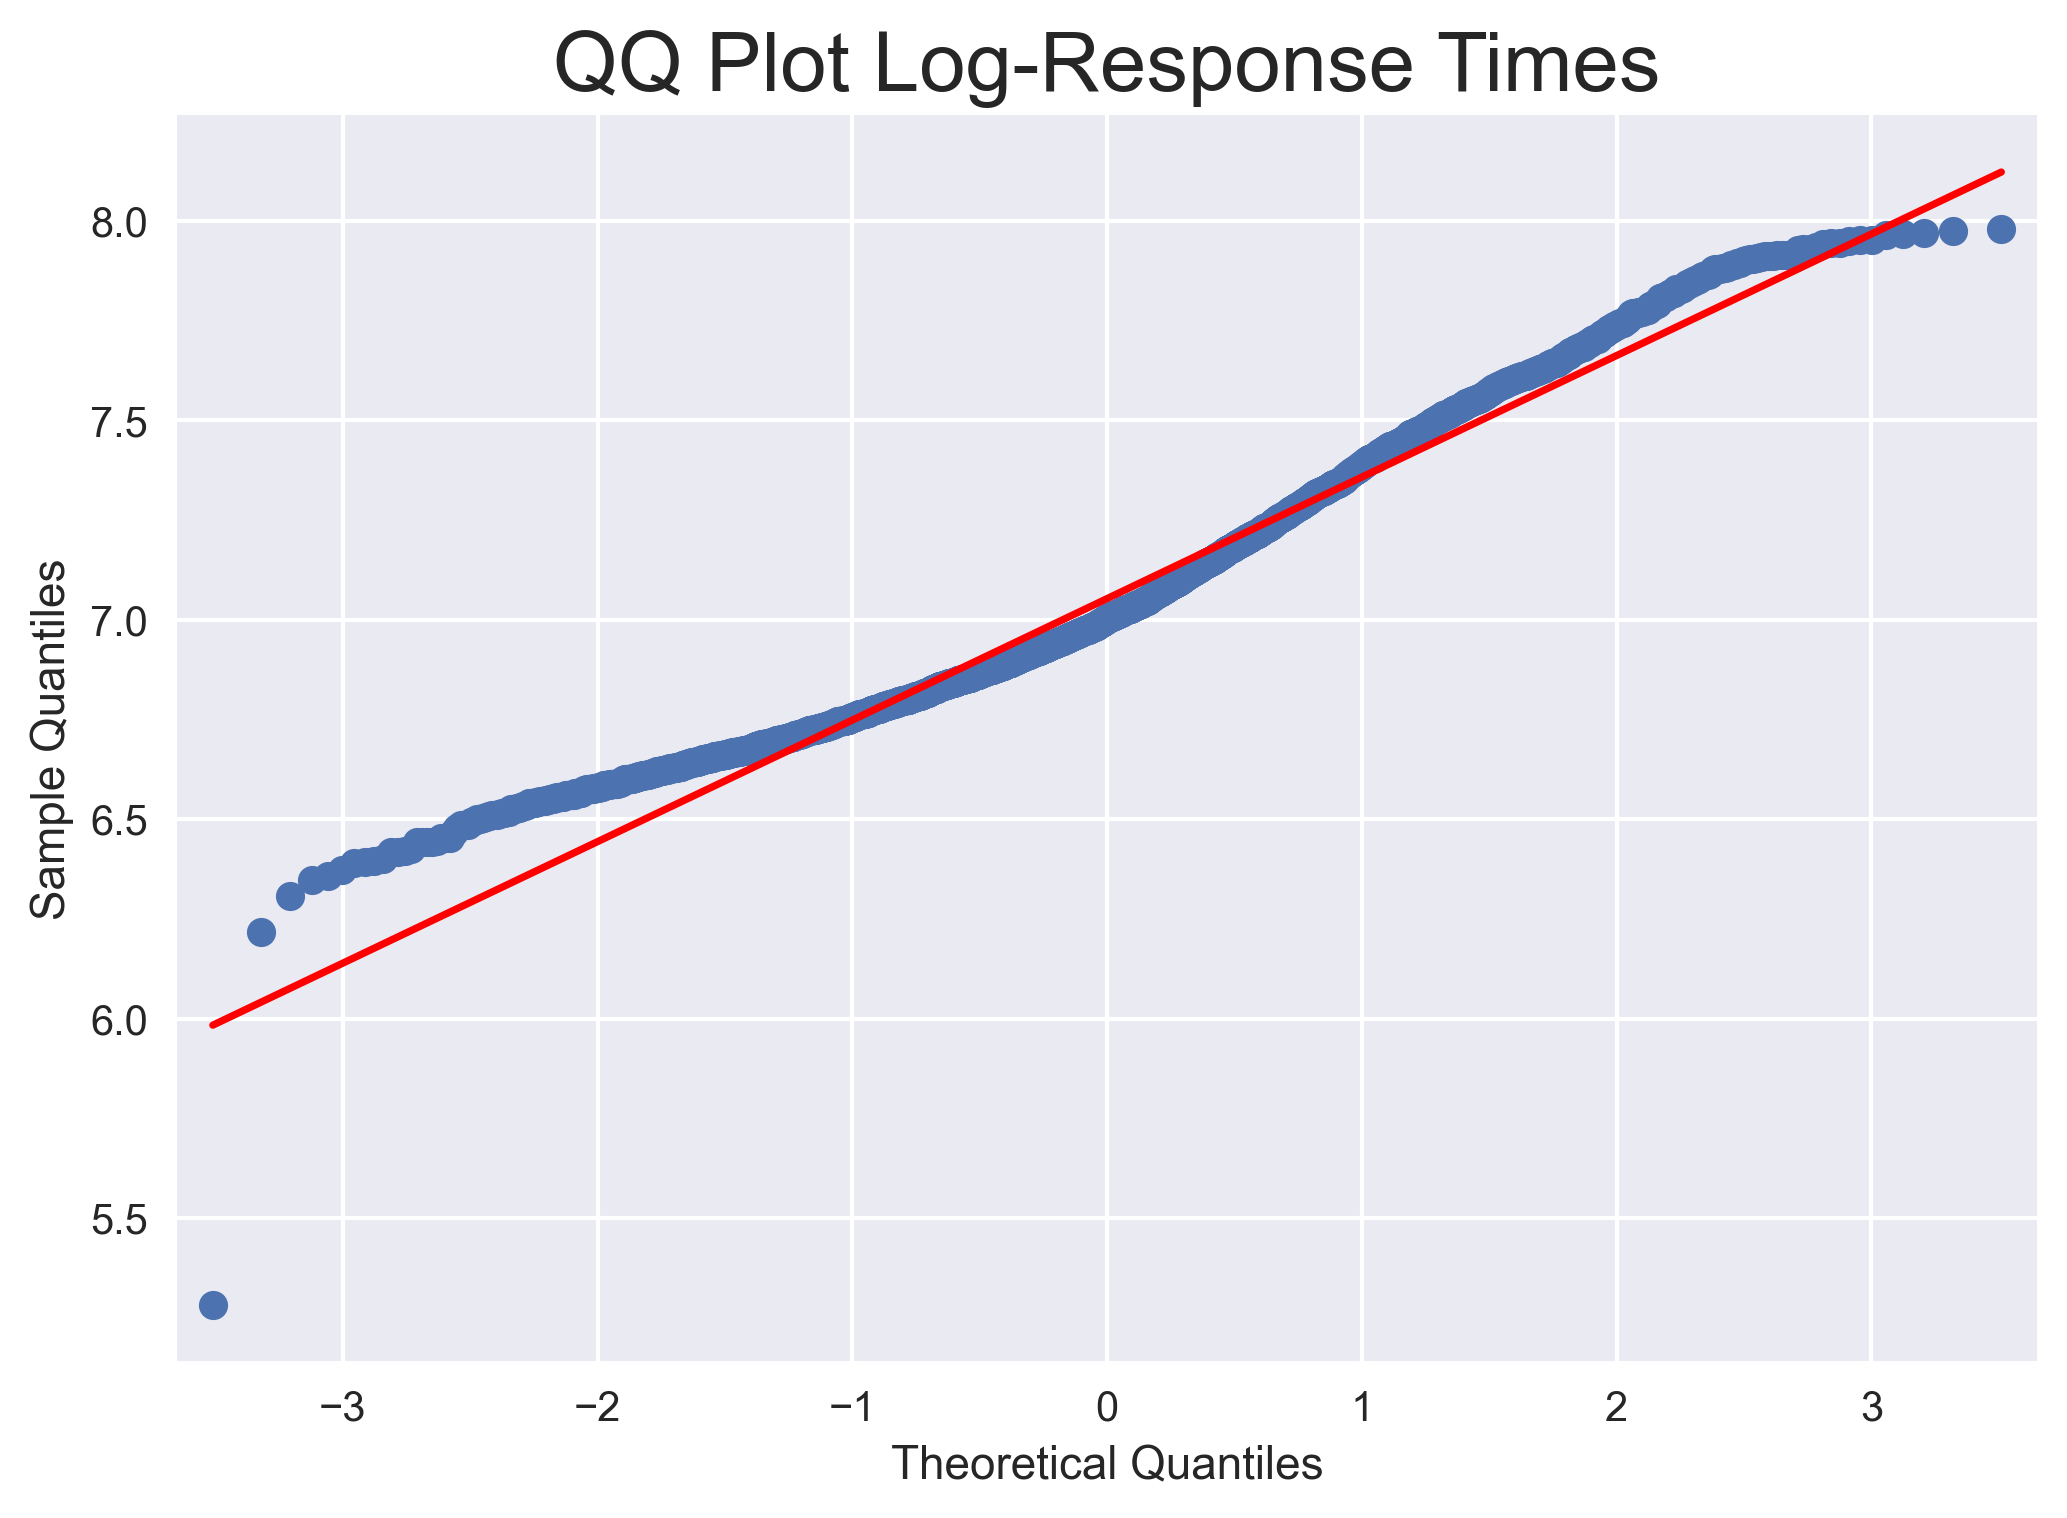

In [32]:
fig = qqplot(responses.log_rt, line='s');
fig.figsize = (15, 9)
fig.dpi = 300
plt.title("QQ Plot Log-Response Times",fontsize=20)
plt.show()

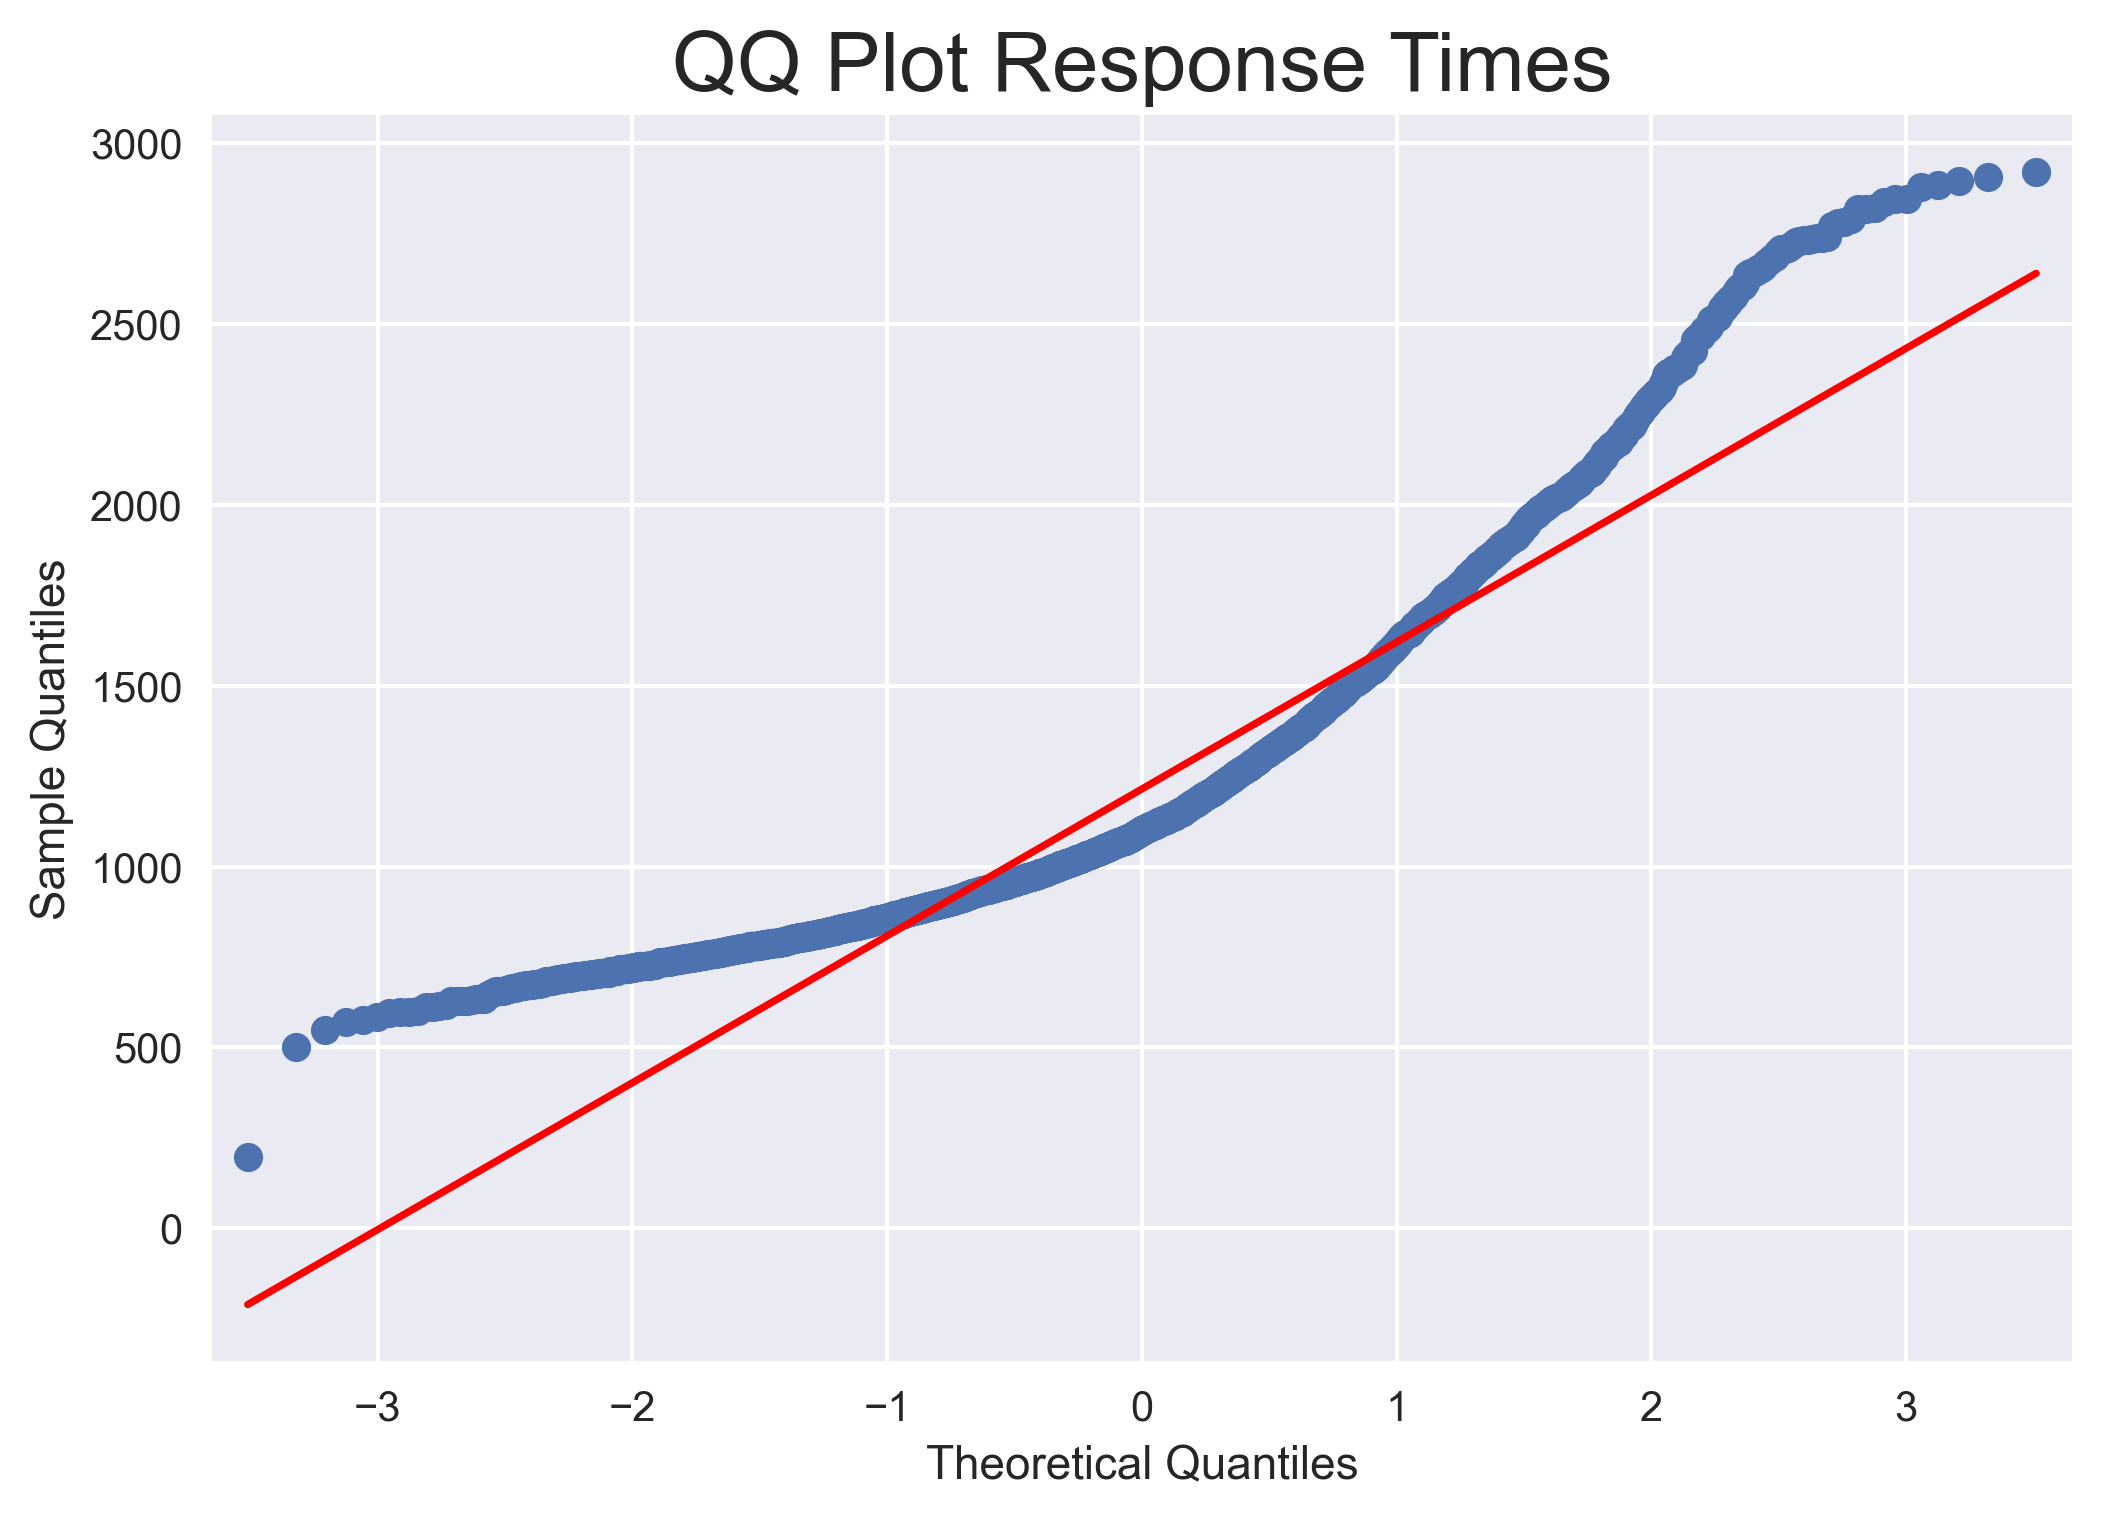

In [33]:
fig = qqplot(responses.rt, line='s');
fig.figsize = (15, 9)
fig.dpi = 300
plt.title("QQ Plot Response Times",fontsize=20)
plt.show()

## Analysis

### Boxplots

#### Log RT Per Participant

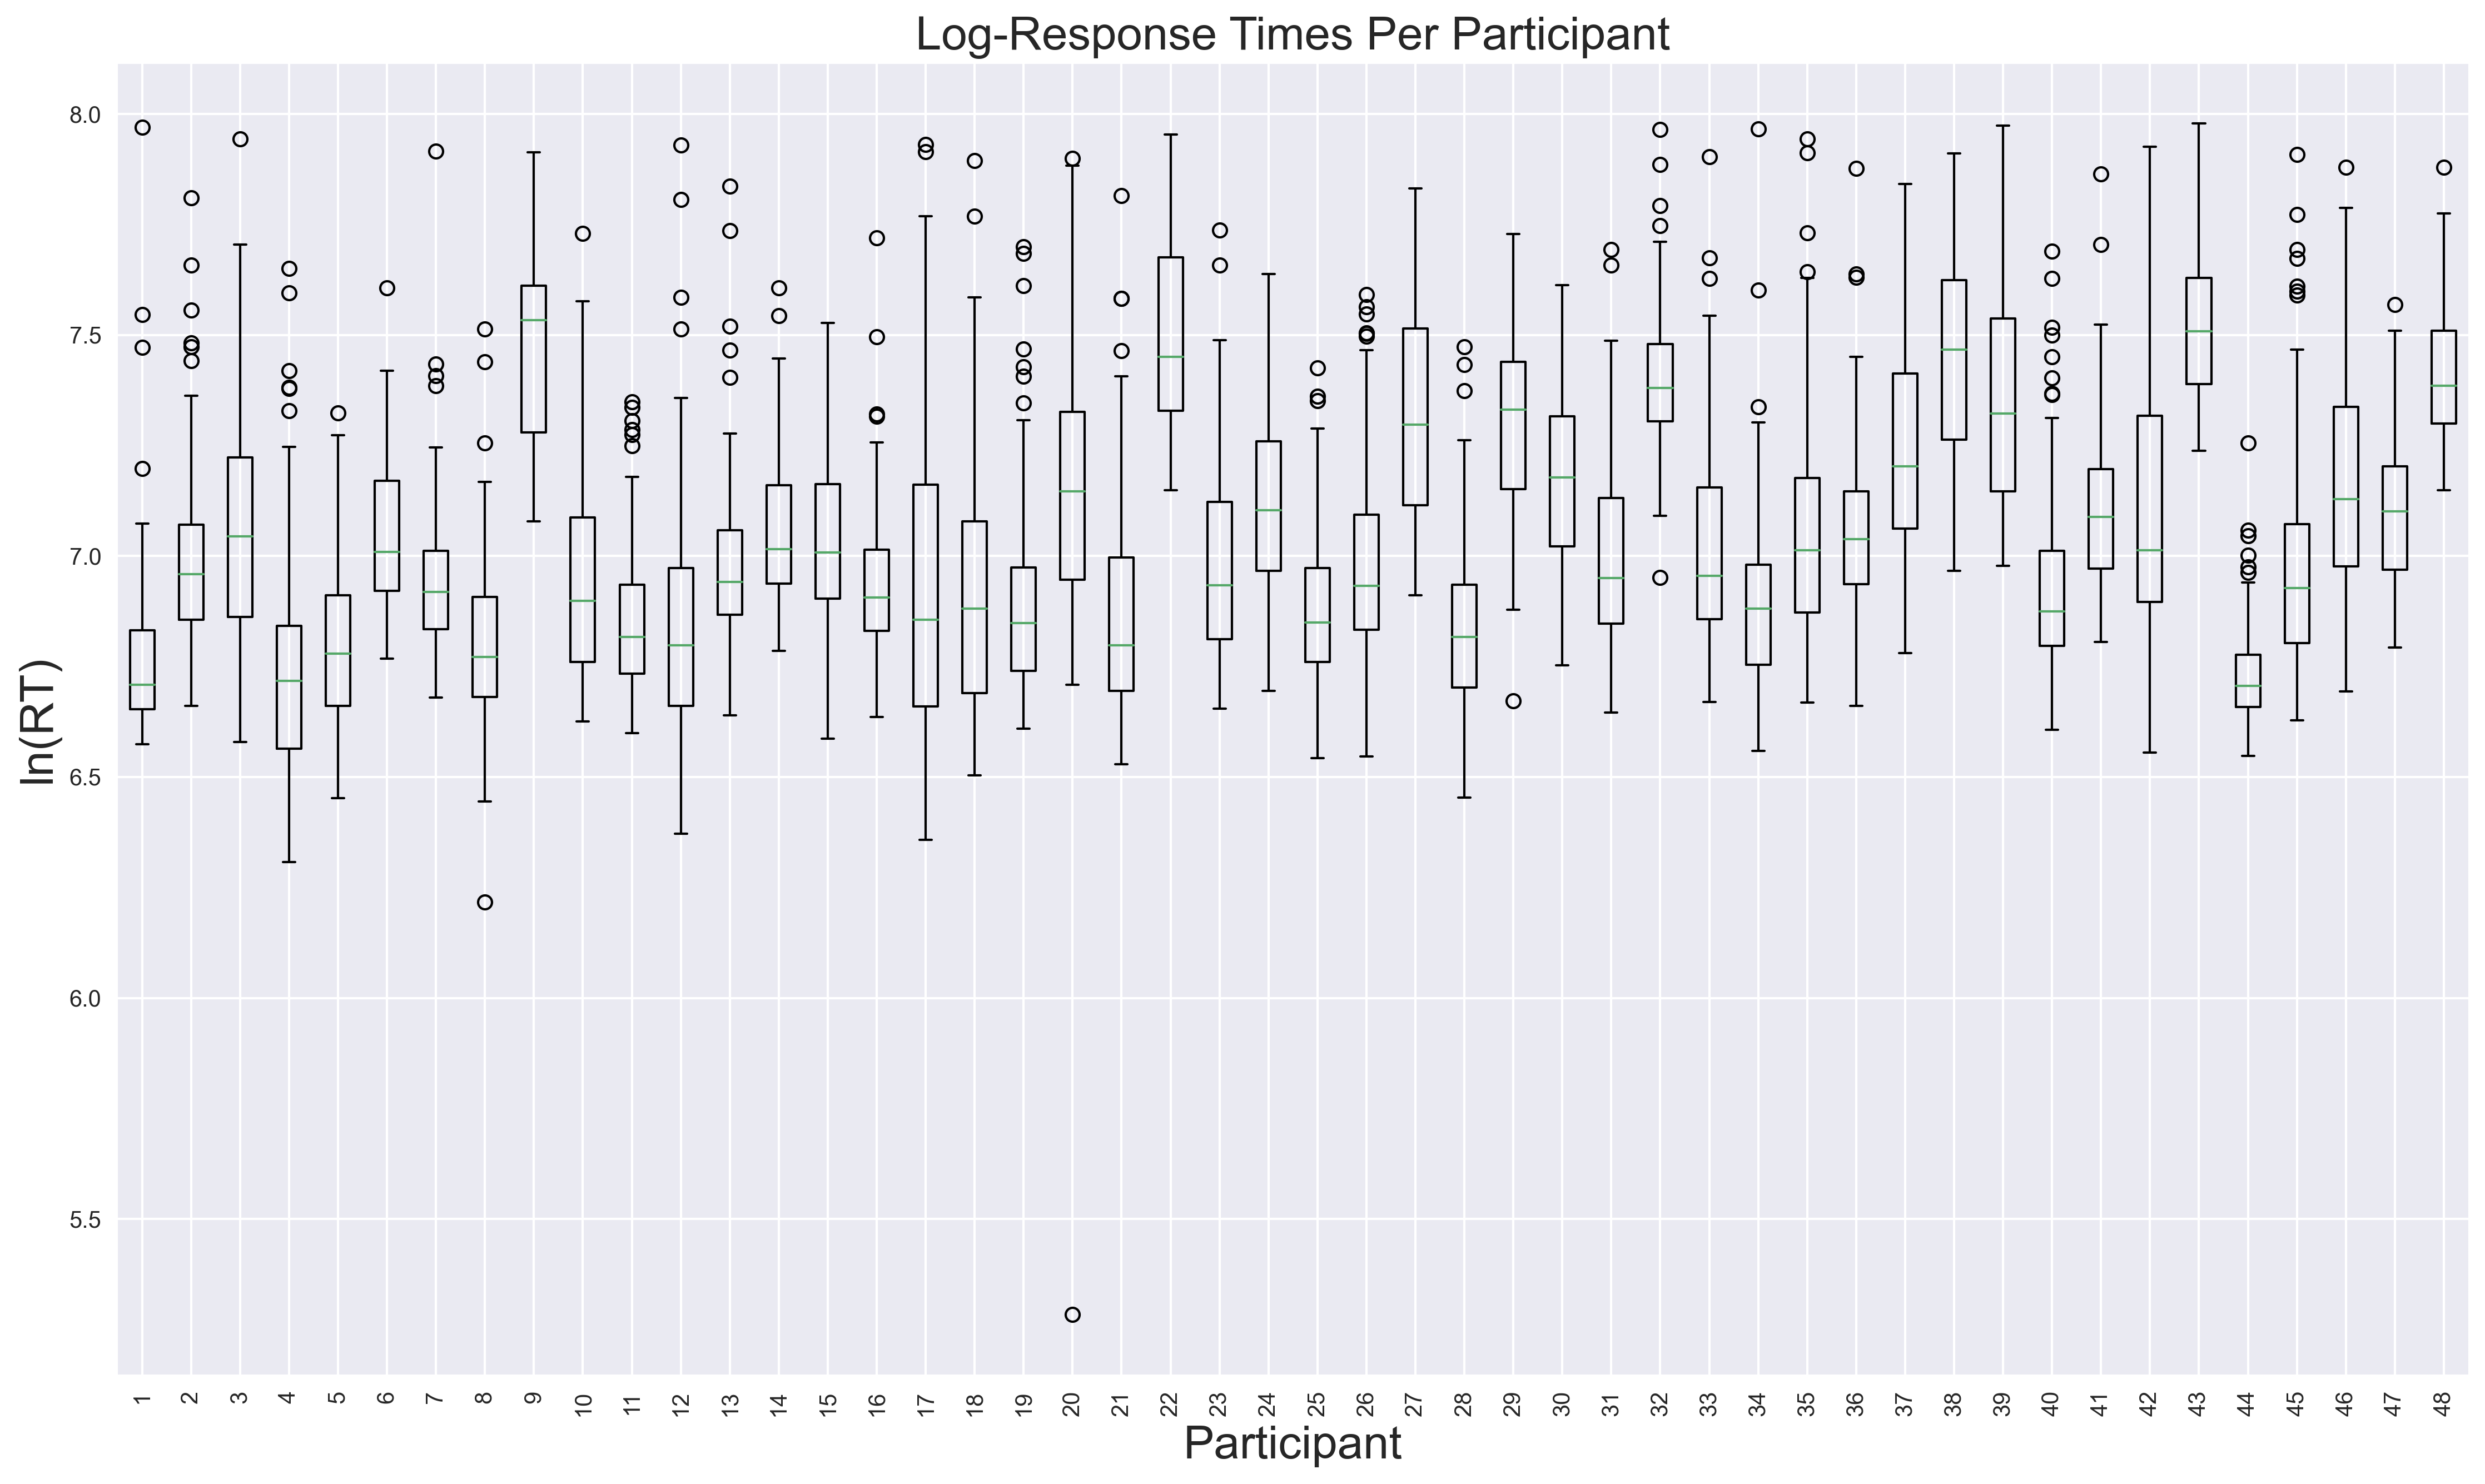

In [34]:
figure(figsize=(15, 9), dpi=300)
plt.boxplot(responses.groupby(["subject_id"]).log_rt.apply(list))
plt.title("Log-Response Times Per Participant",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Participant",fontsize=20)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### Log RT Per Scene

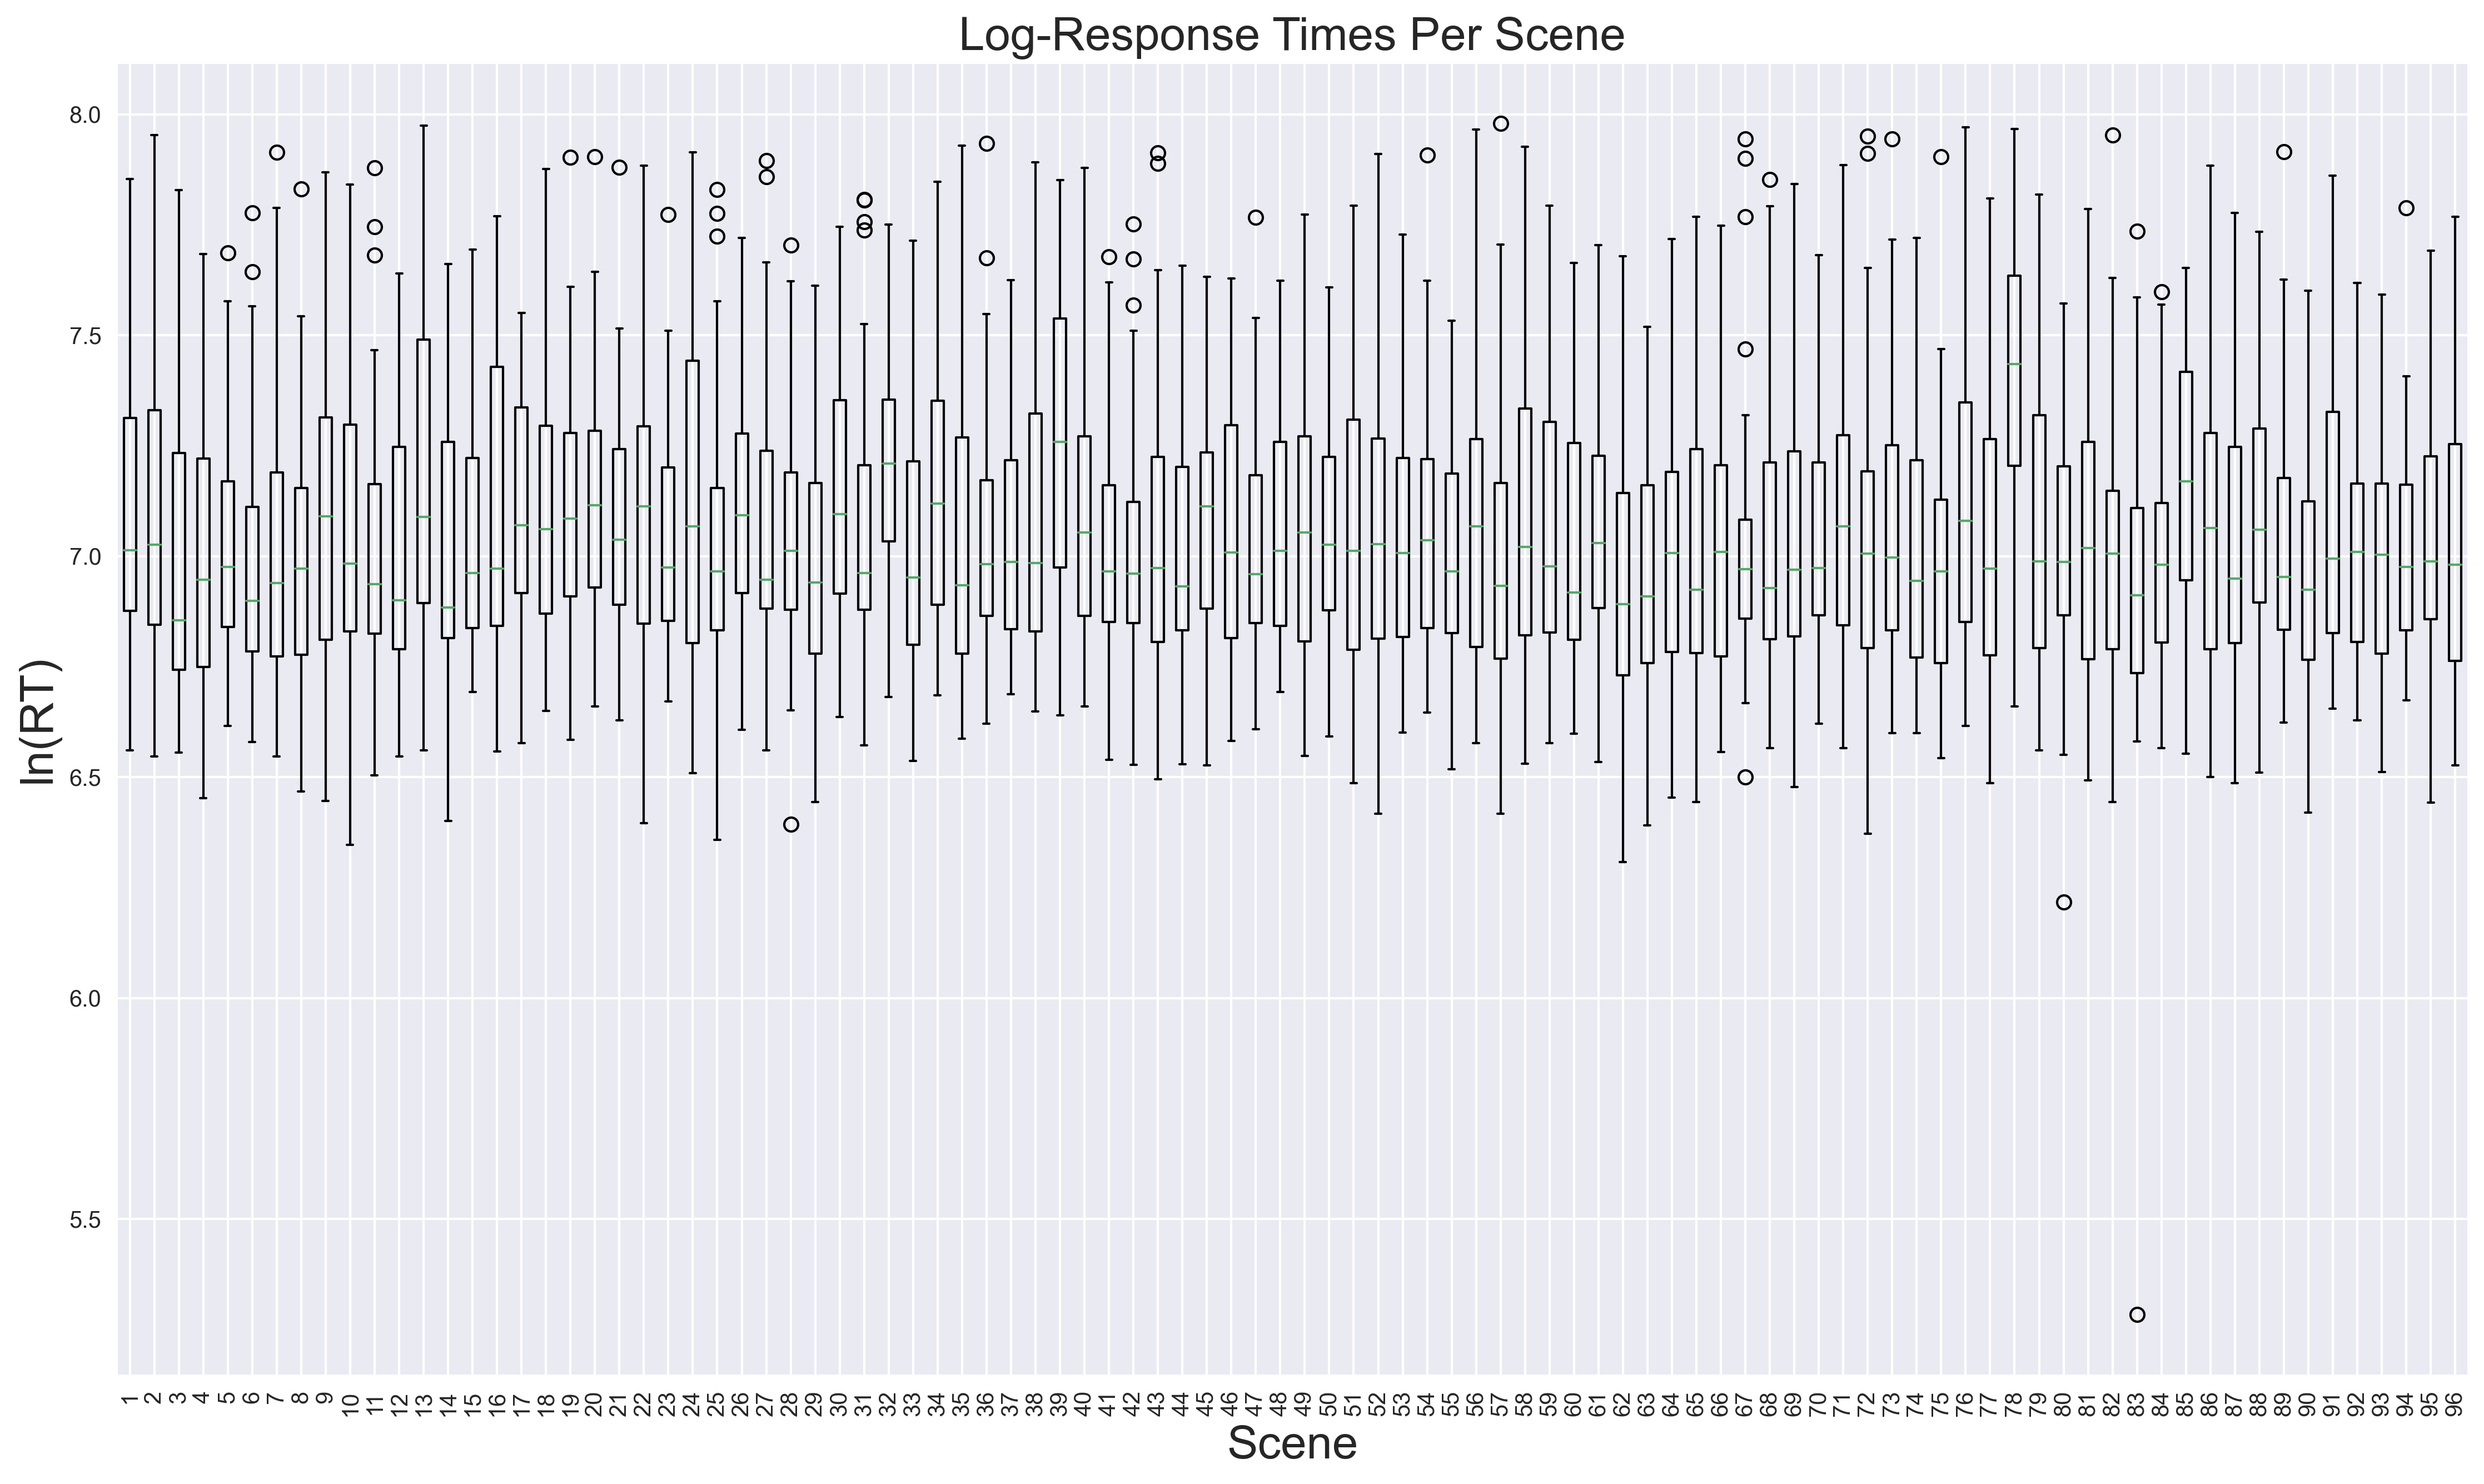

In [35]:
figure(figsize=(15, 9), dpi=300)
plt.boxplot(responses.groupby(["scene"]).log_rt.apply(list))
plt.title("Log-Response Times Per Scene",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

#### Log RT for No Condition

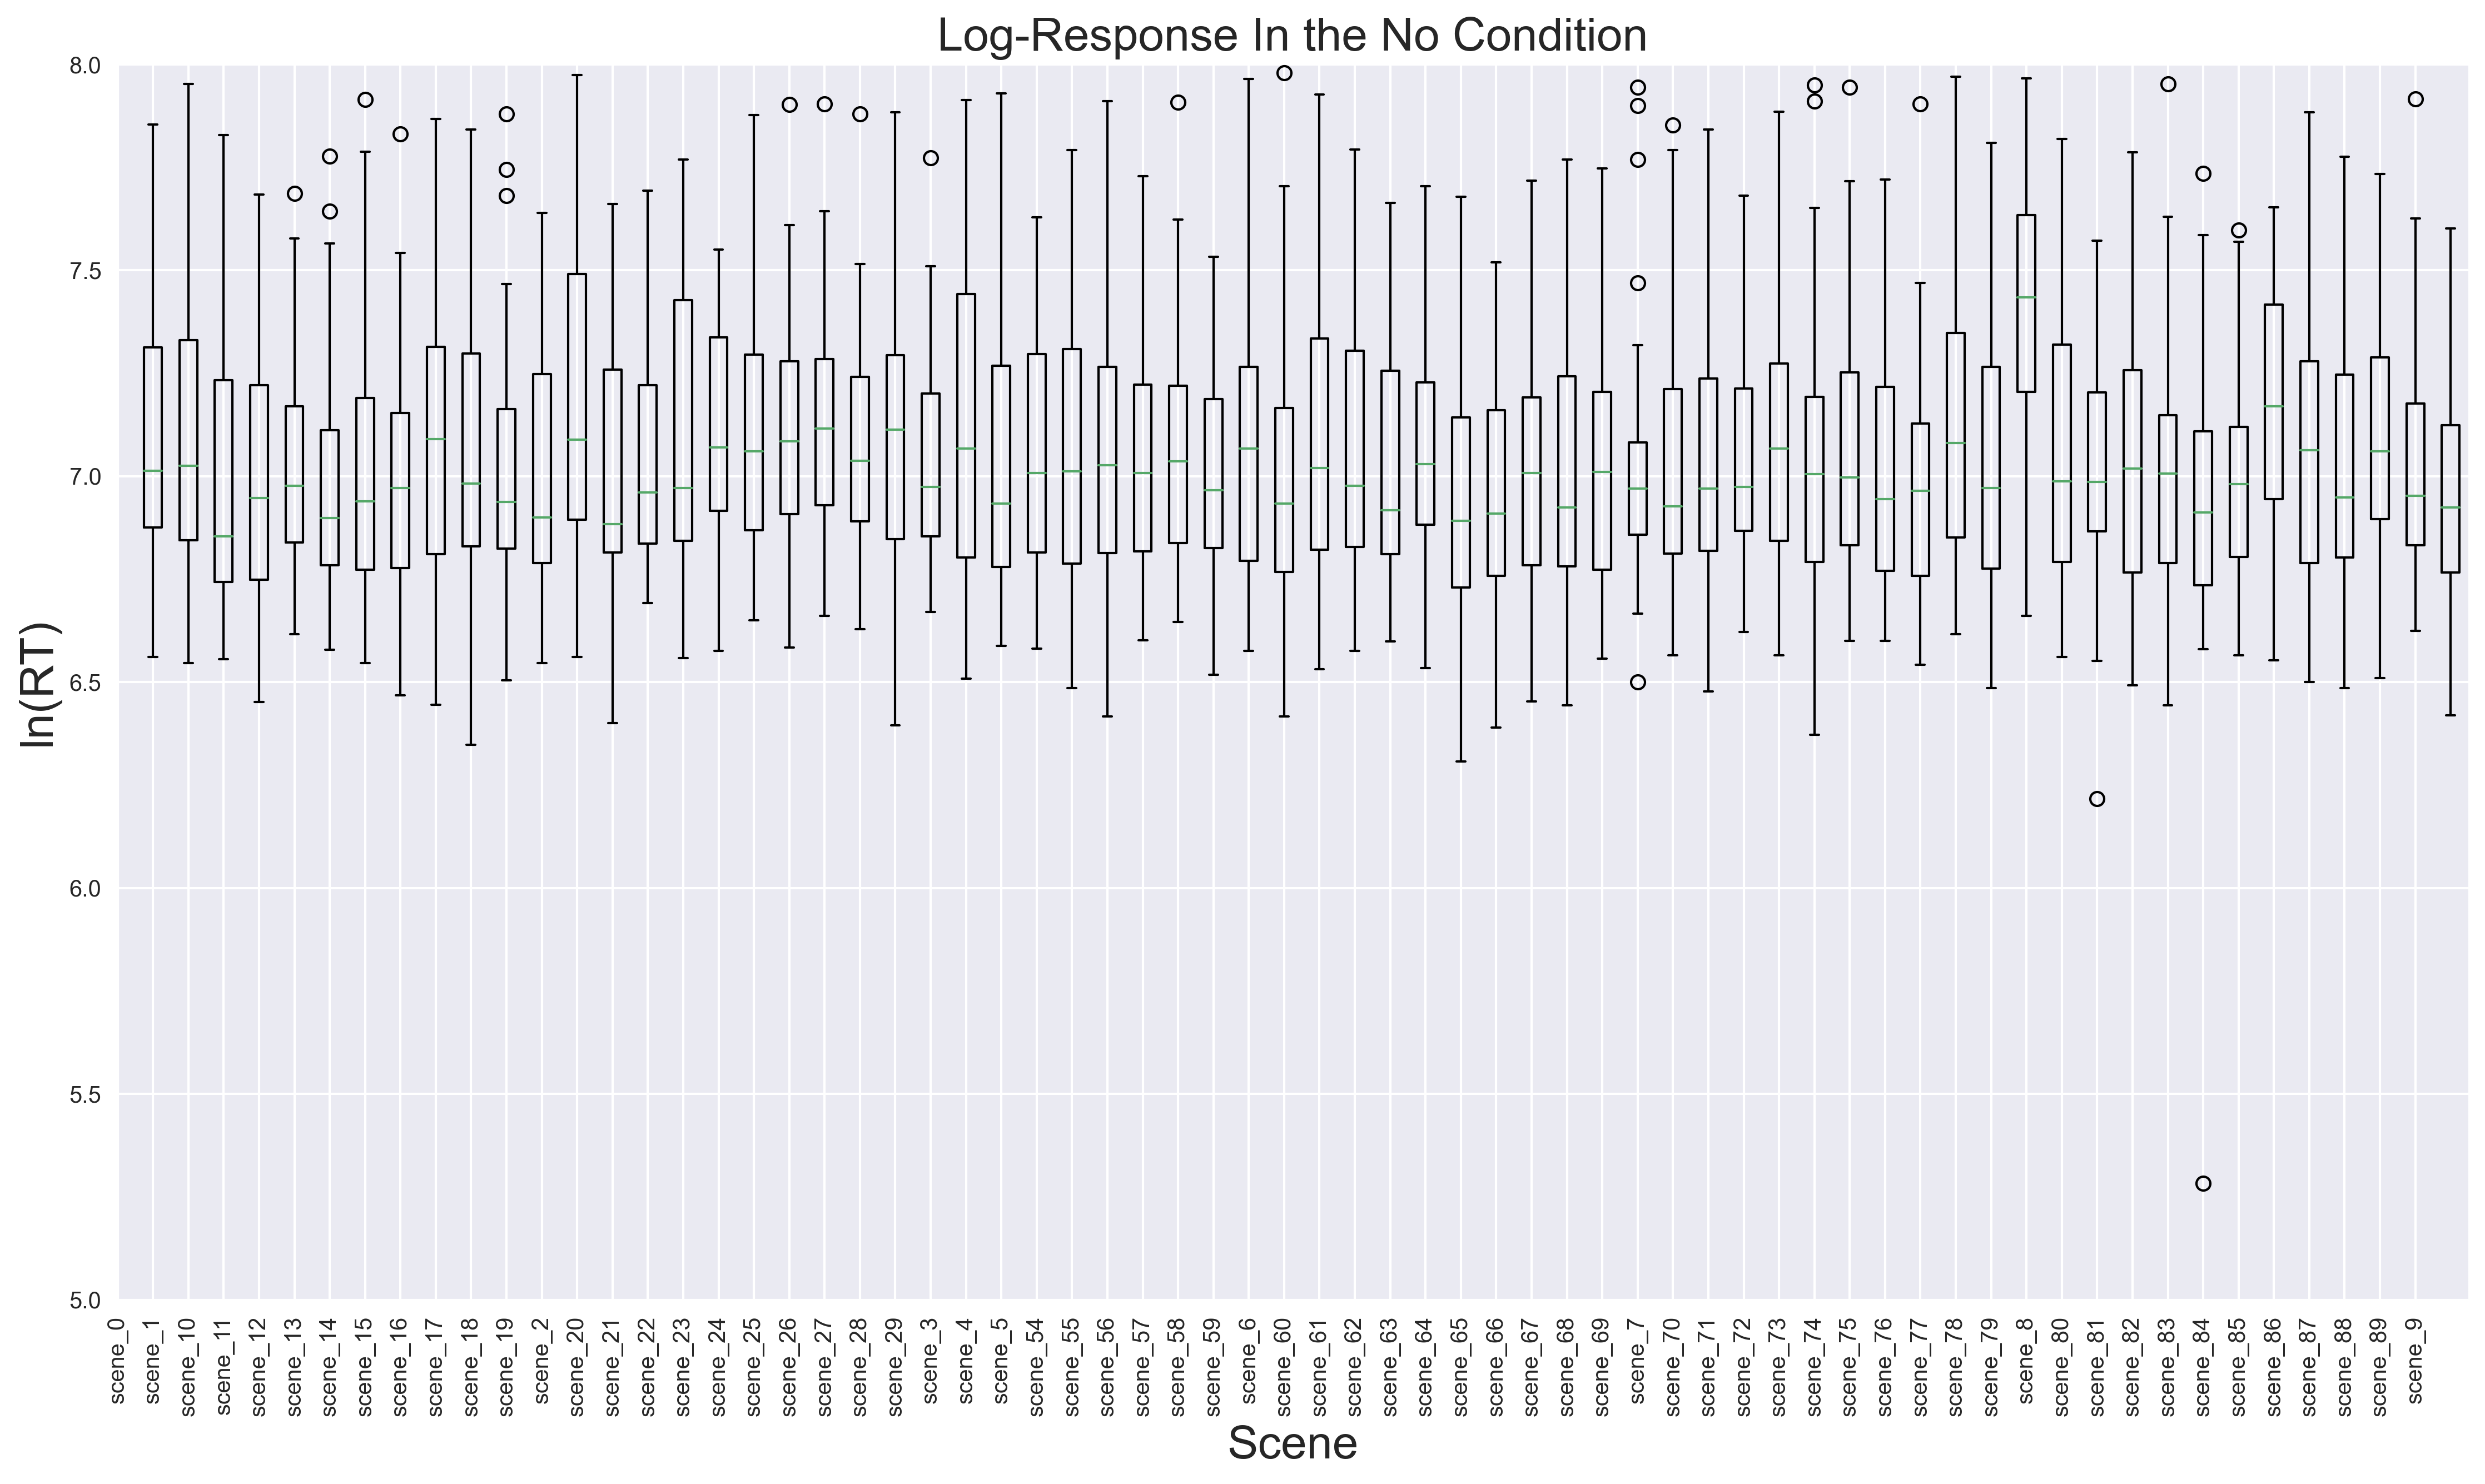

In [36]:
figure(figsize=(15, 9), dpi=300)
no_trials=responses[responses["trial_condition"]=="No"]

plt.boxplot(no_trials.groupby("scene").log_rt.apply(list))
# plt.scatter(no_trials.scene, 
#             no_trials.log_rt, 
#             s=4)
plt.title("Log-Response In the No Condition",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(list(range(len(list(no_trials.groupby(["scene"]).log_rt.apply(list).index)))), 
           list(no_trials.groupby(["scene"]).log_rt.apply(list).index), 
           rotation = 90)
plt.ylim(5,8)
plt.tight_layout()
plt.show()

#### Log RT for Yes Condition

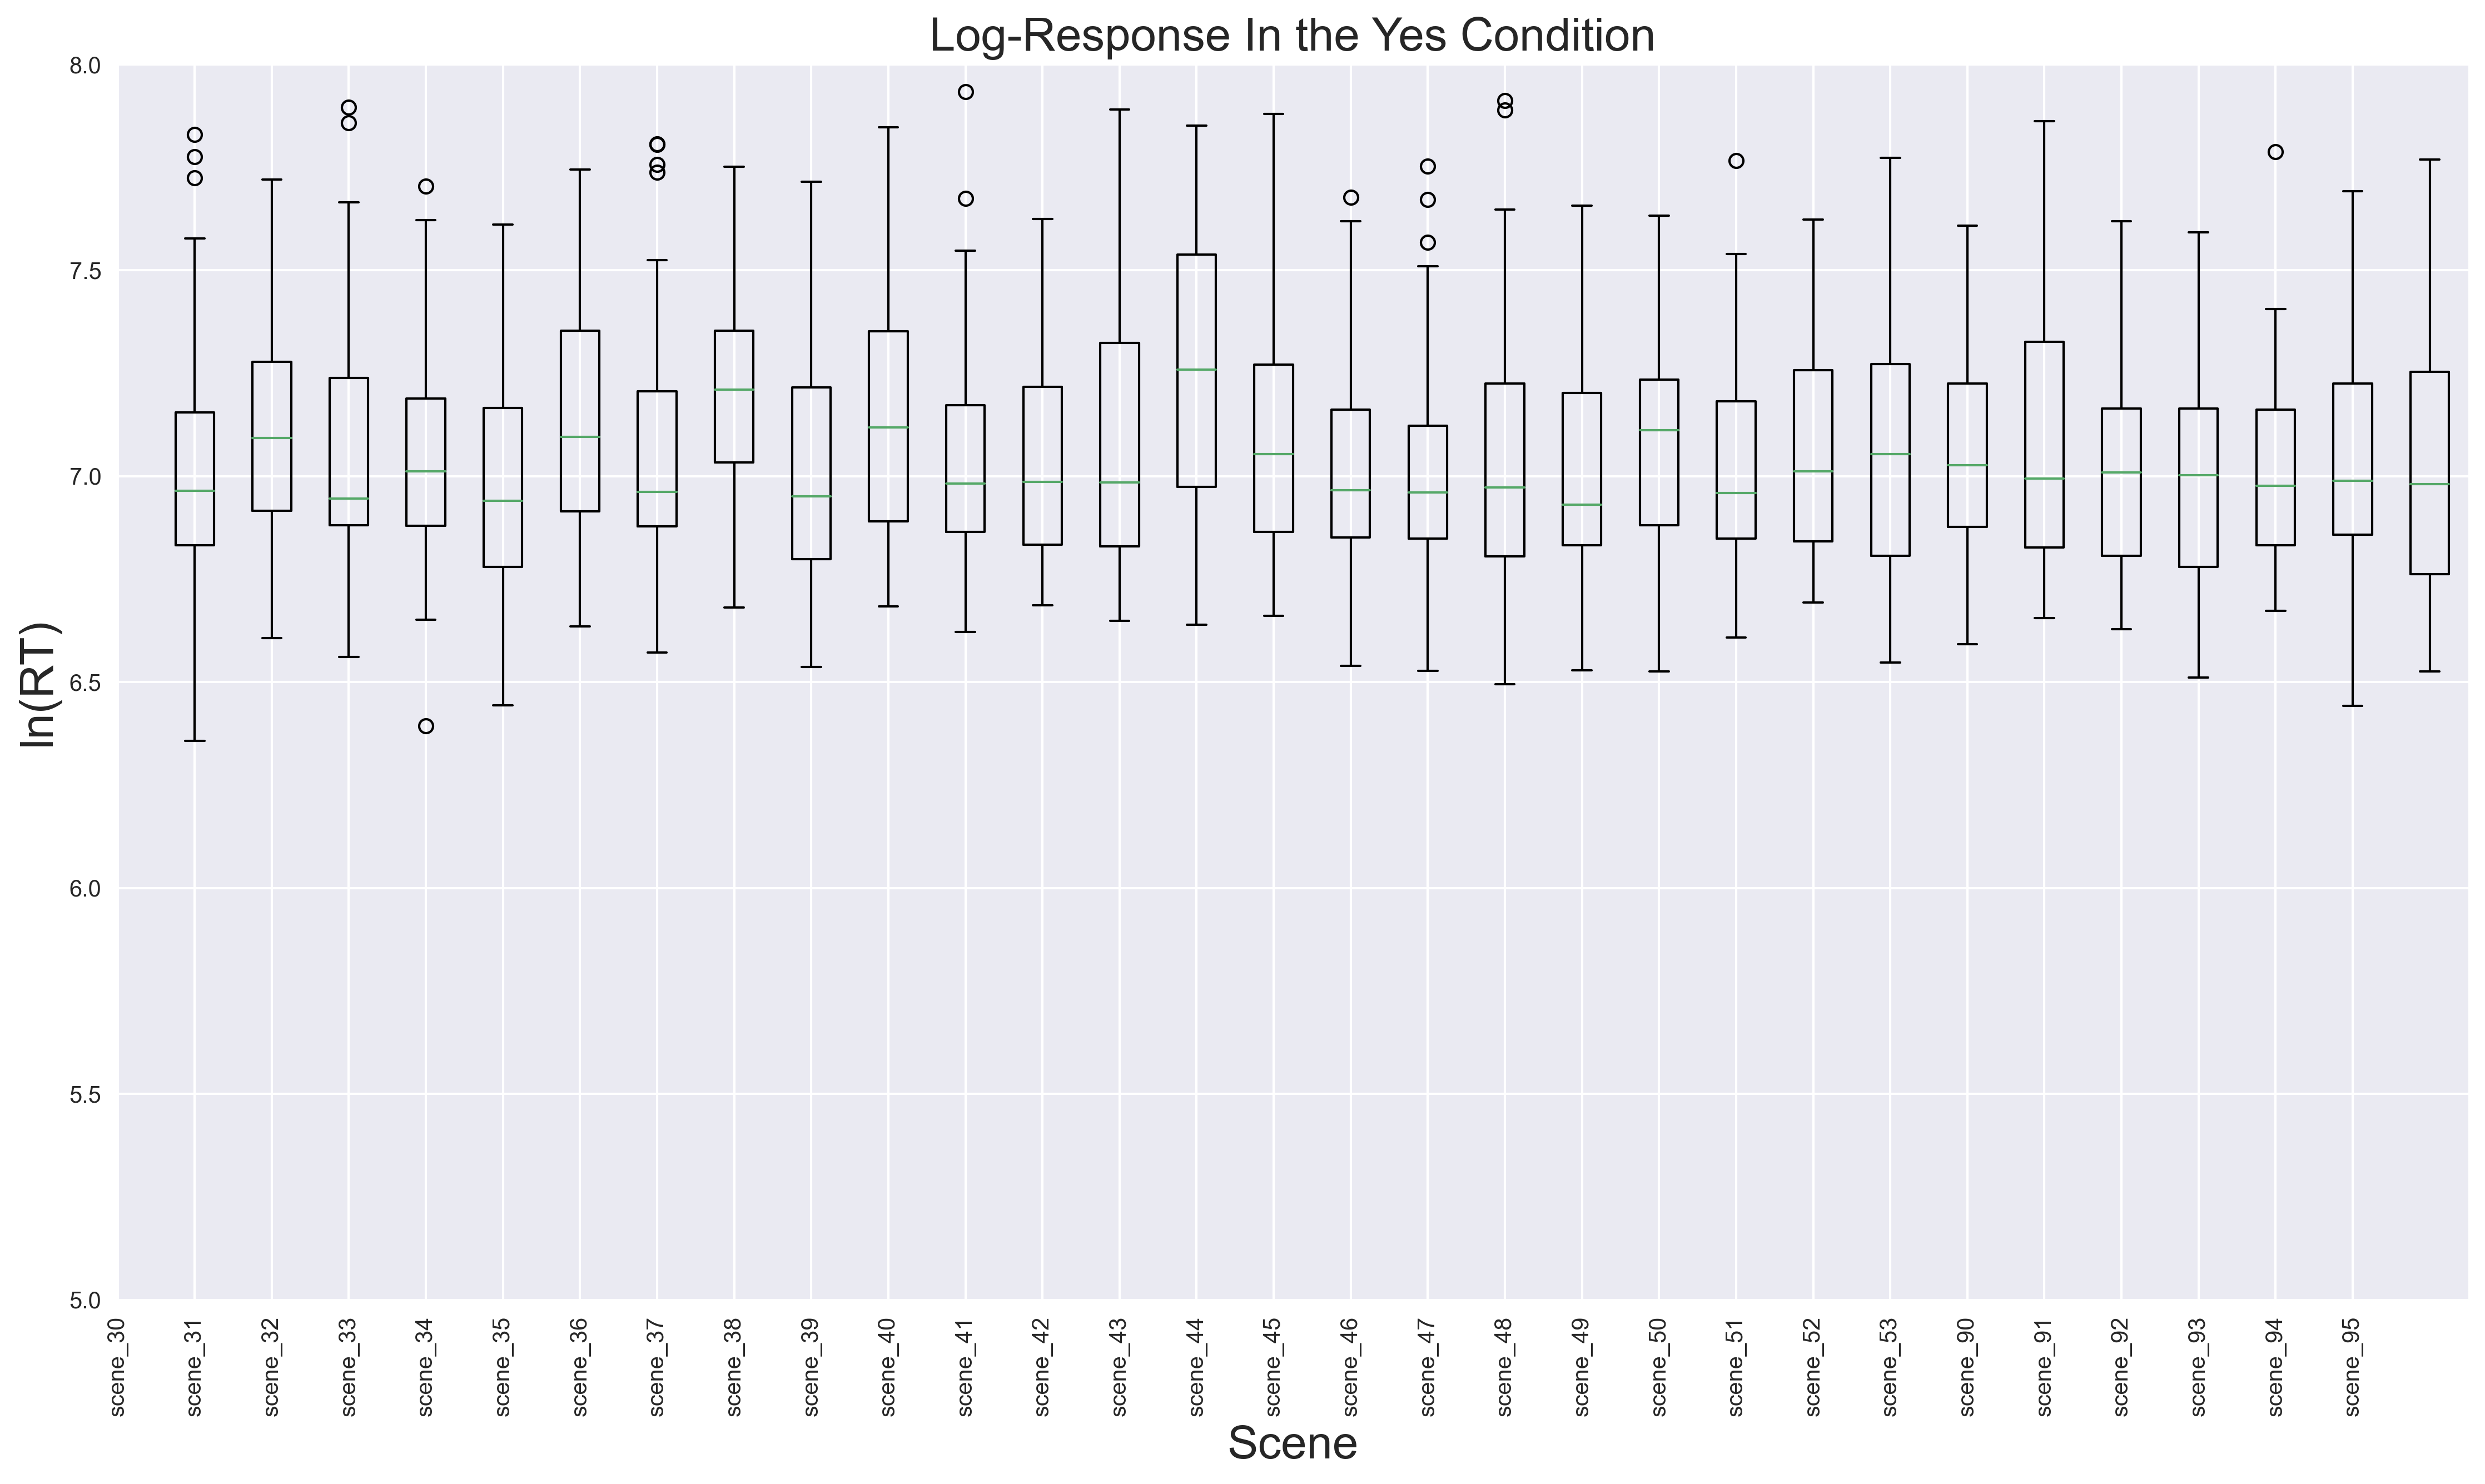

In [37]:
figure(figsize=(15, 9), dpi=300)
yes_trials=responses[responses["trial_condition"]=="Yes"]

plt.boxplot(yes_trials.groupby("scene").log_rt.apply(list))
plt.title("Log-Response In the Yes Condition",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.xlabel("Scene",fontsize=20)
plt.xticks(list(range(len(list(yes_trials.groupby("scene").log_rt.apply(list).index)))), 
           list(yes_trials.groupby("scene").log_rt.apply(list).index), 
           rotation = 90)
plt.ylim(5,8)
plt.tight_layout()
plt.show()

#### Z-Test on No/Yes Means

In [55]:
from statsmodels.stats.weightstats import ztest


no = list(responses[responses["trial_condition"]=="No"].groupby('subject_id').log_rt.mean())
yes = list(responses[responses["trial_condition"]=="Yes"].groupby('subject_id').log_rt.mean())
yes_mean = sum(yes)/len(yes)

print('mean=%.2f stdv=%.2f' % (np.mean(no), np.std(no)))
print('mean=%.2f stdv=%.2f' % (np.mean(yes), np.std(yes)))

ztest_score, p_value= ztest(no,value = yes_mean, alternative='two-sided')
print(p_value)
print(ztest_score)

mean=7.05 stdv=0.21
mean=7.06 stdv=0.21
0.7474985462778692
-0.3219394761644074


#### Cumulative Log RT Per Trial

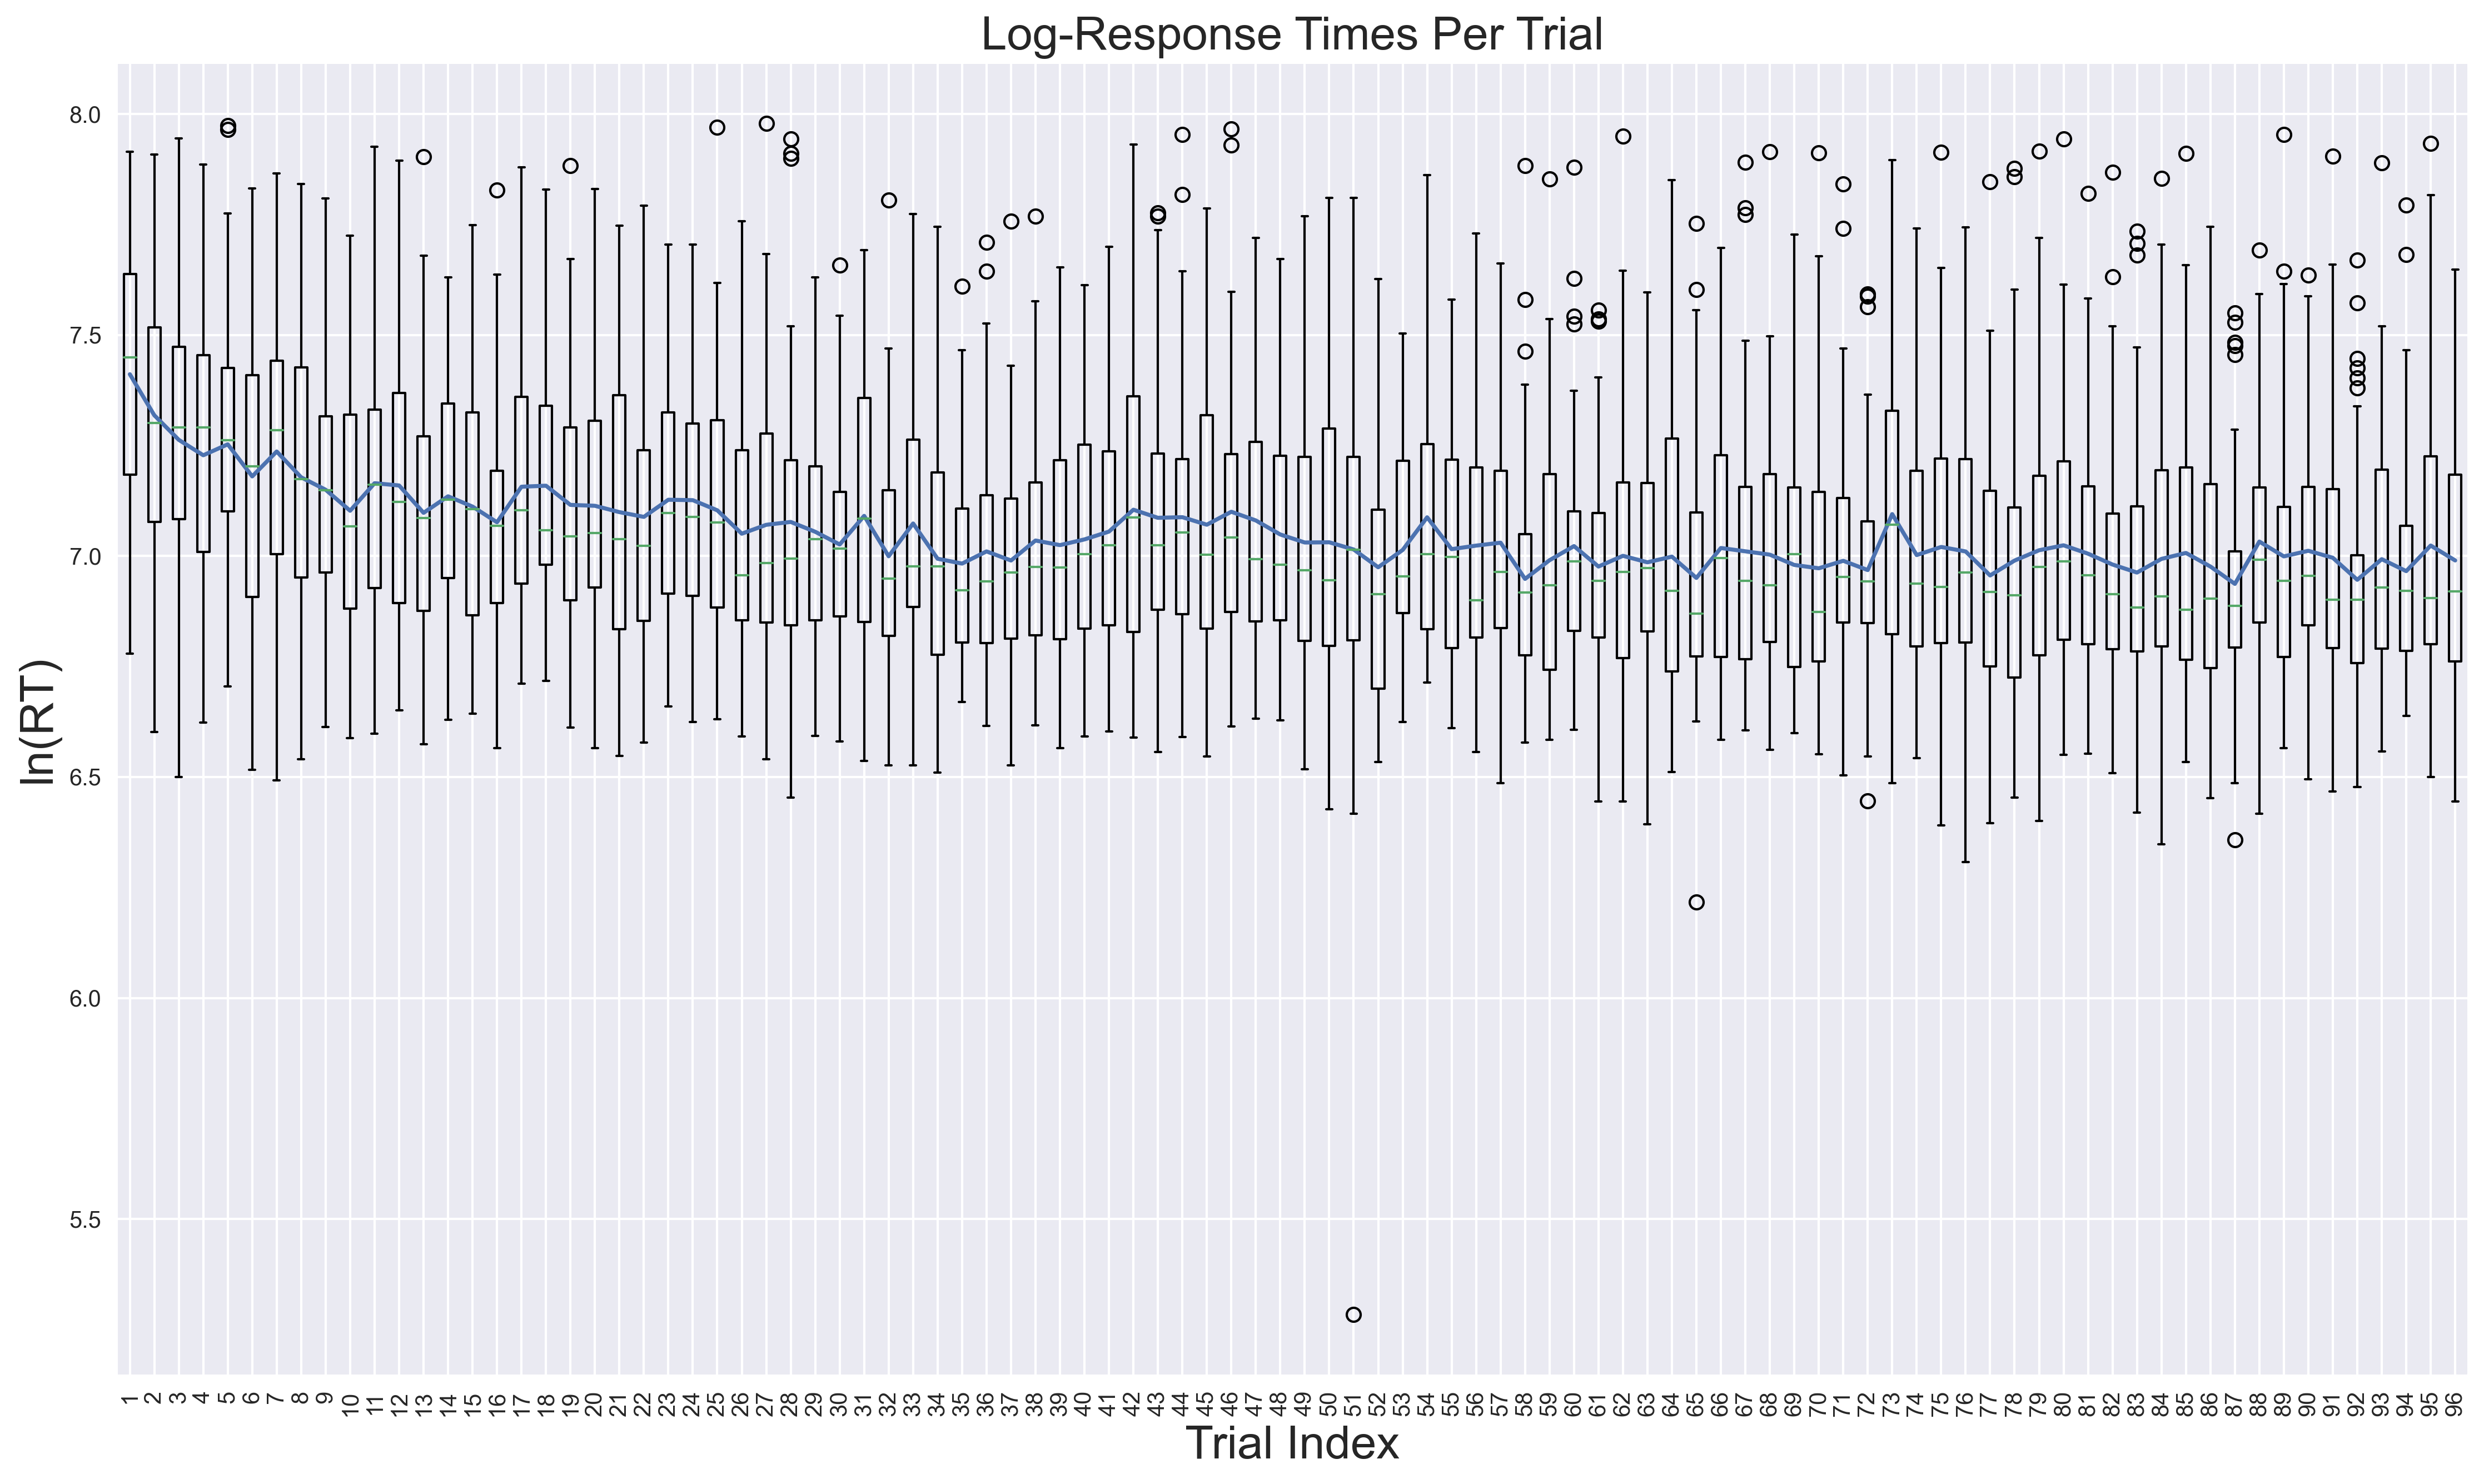

In [56]:
trial = responses.groupby("trial_index").log_rt.apply(list)
rtt=responses.groupby(["trial_index"]).log_rt.describe()["mean"]
rtt.index = list(range(1,len(rtt.index)+1))
figure(figsize=(15, 9), dpi=300)

plt.boxplot(trial)
plt.plot(rtt)
plt.xticks(rotation = 90)
plt.title("Log-Response Times Per Trial",fontsize=20)
plt.xlabel("Trial Index",fontsize=20)
plt.ylabel("ln(RT)",fontsize=20)
plt.tight_layout()
plt.show()

### Histograms

trial_condition  correct
No               True       2835
                 False       239
Yes              True       1184
                 False       205
Name: correct, dtype: int64


Text(0.5, 0, 'Response')

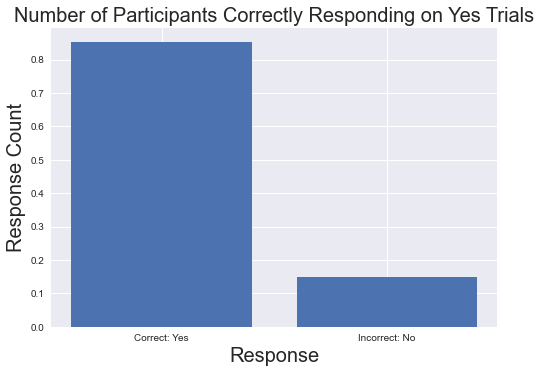

In [60]:
# How many people got the "Yes" trials correct?
y=responses.groupby("trial_condition").correct.value_counts()
print(y)
no = y['No']
yes = y['Yes']

no_correct = no[True] / (no[True]+no[False])
no_wrong = no[False] / (no[True]+no[False])

yes_correct = yes[True] / (yes[True]+yes[False])
yes_wrong = yes[False] / (yes[True]+yes[False])

plt.bar(["Correct: Yes","Incorrect: No"], [yes_correct,yes_wrong])
plt.title("Number of Participants Correctly Responding on Yes Trials",fontsize=20)
plt.ylabel("Response Count",fontsize=20)
plt.xlabel("Response",fontsize=20)

Text(0, 0.5, 'Response Count')

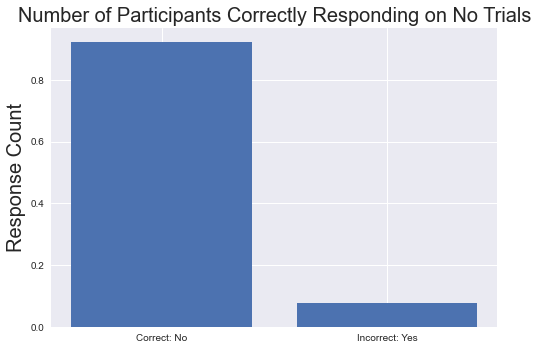

In [62]:
plt.bar(["Correct: No","Incorrect: Yes"], [no_correct,no_wrong])
plt.title("Number of Participants Correctly Responding on No Trials",fontsize=20)
plt.ylabel("Response Count",fontsize=20)

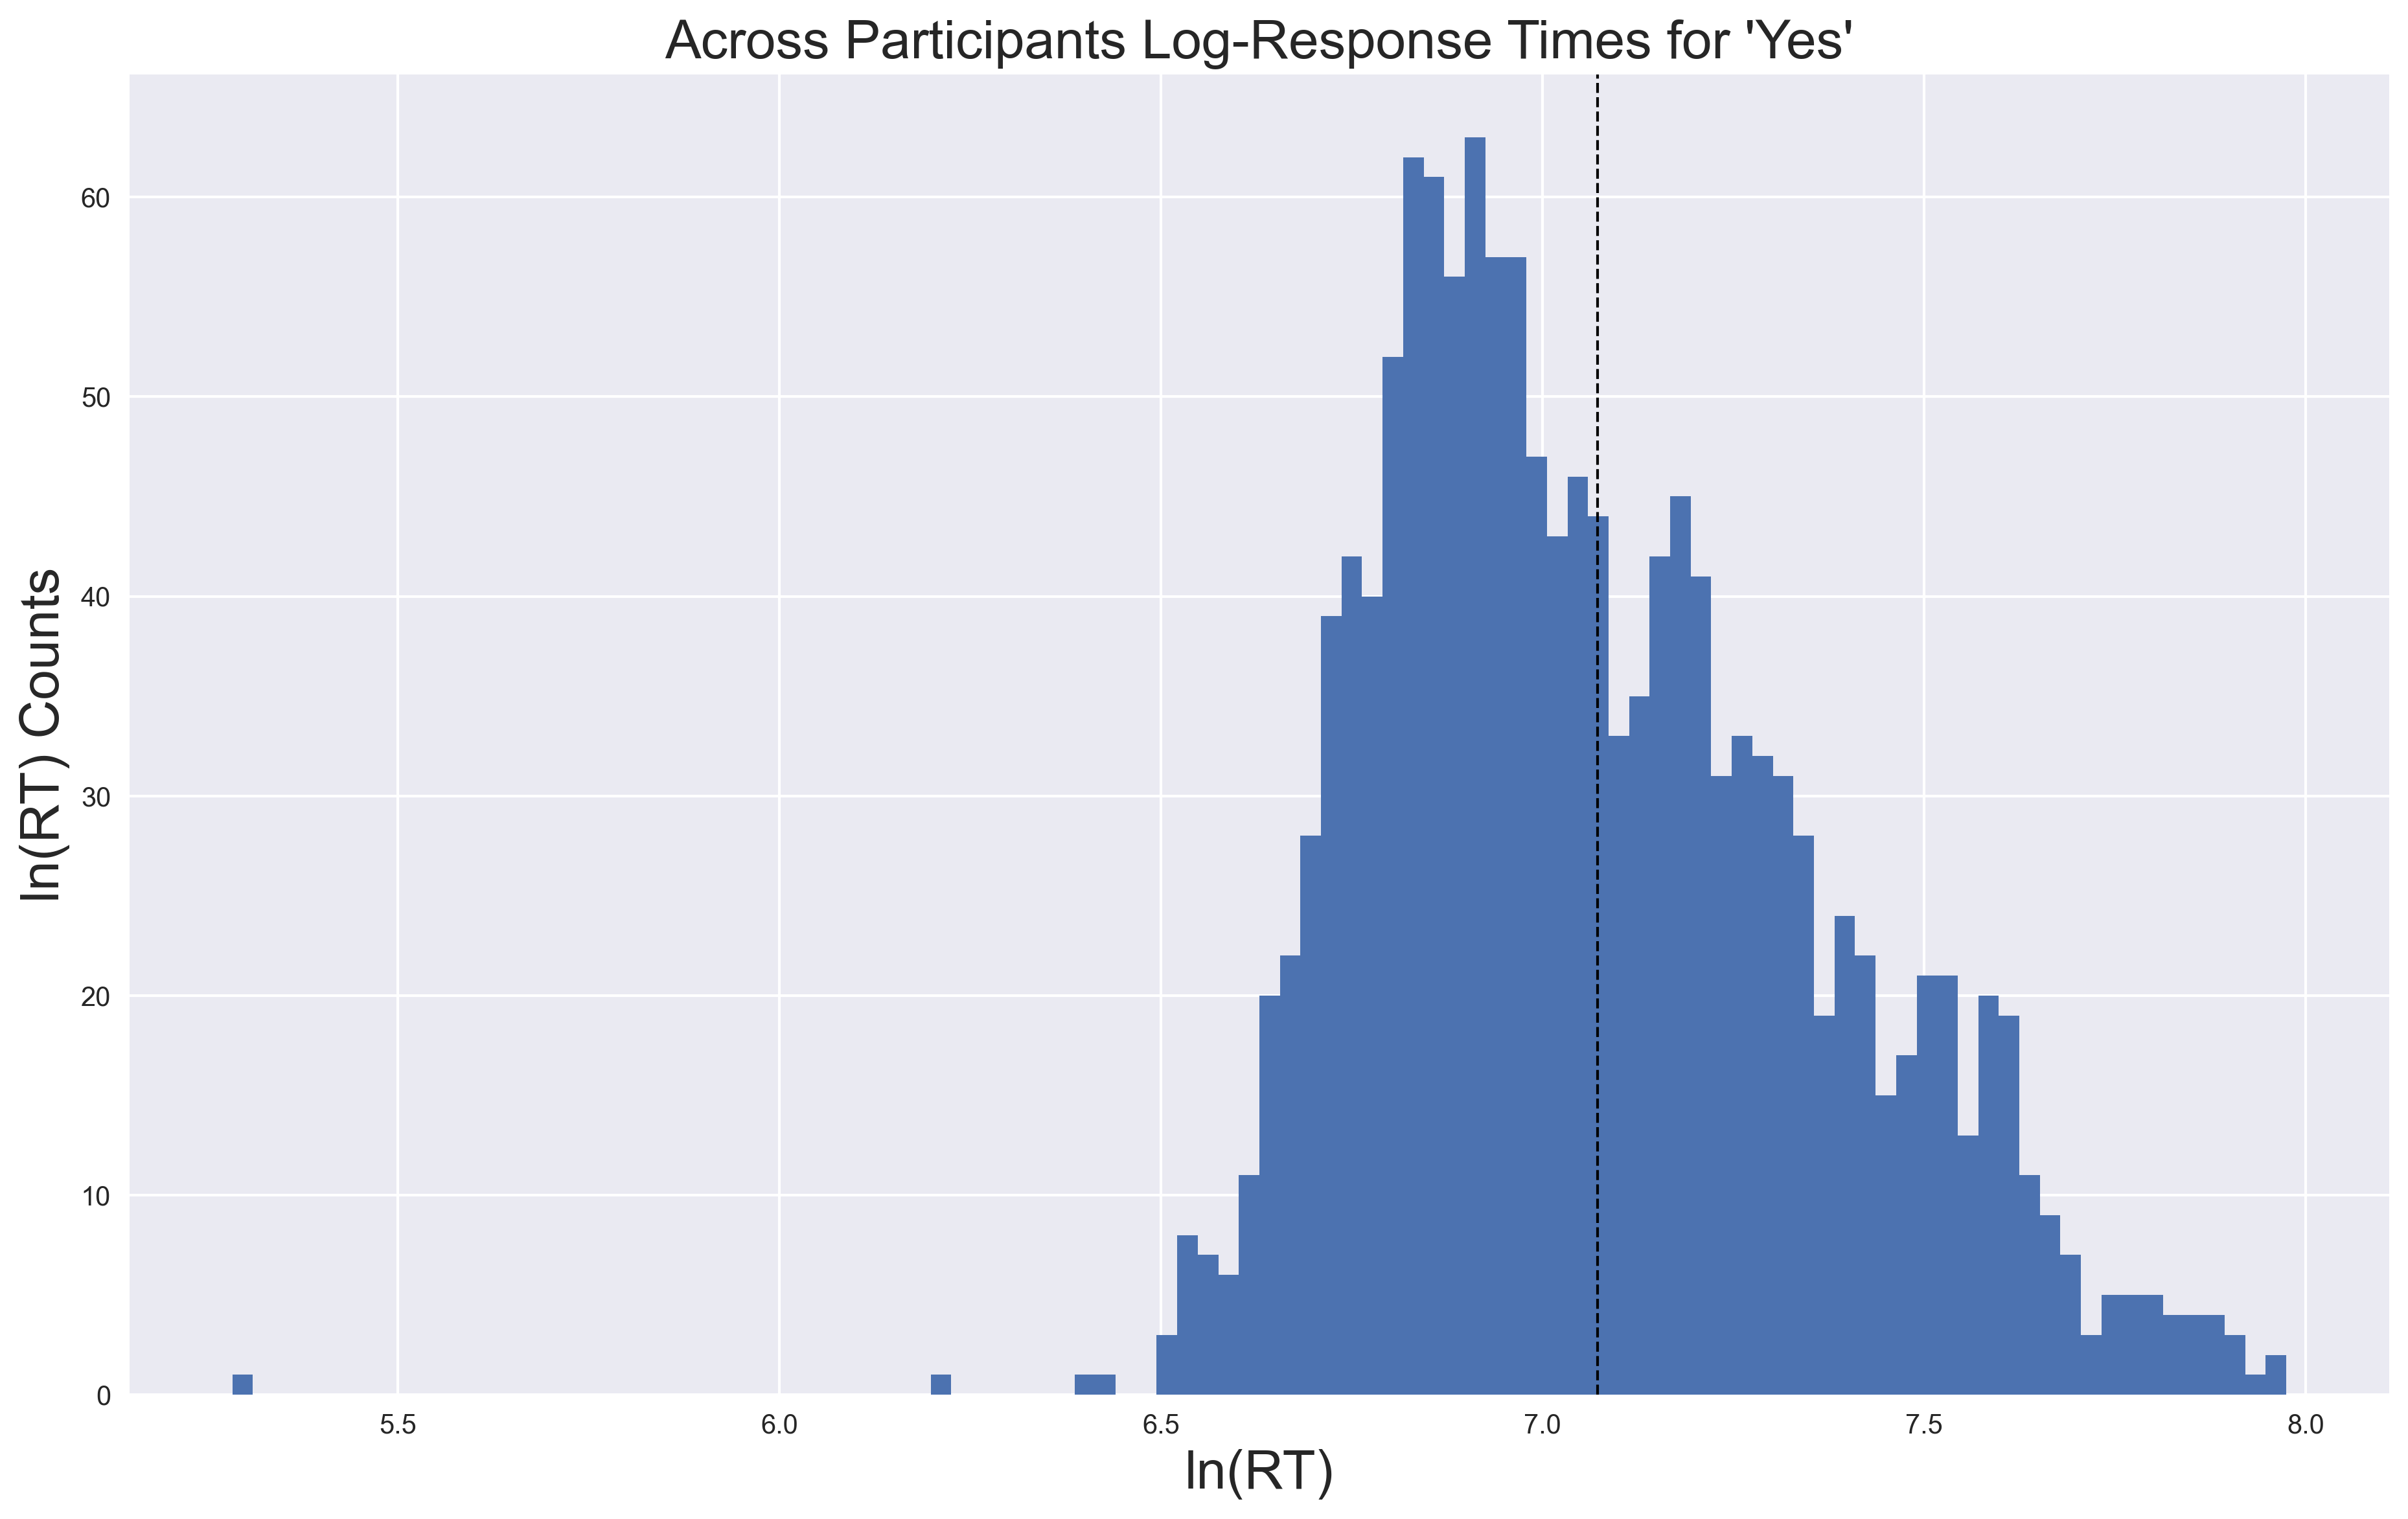

In [68]:
figure(figsize=(15, 9), dpi=300)
h, _, _ = plt.hist(responses[responses.response=="Yes"].log_rt, bins=100);
plt.axvline(responses[responses.response=="Yes"].log_rt.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Across Participants Log-Response Times for 'Yes'",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("ln(RT) Counts",fontsize=20);

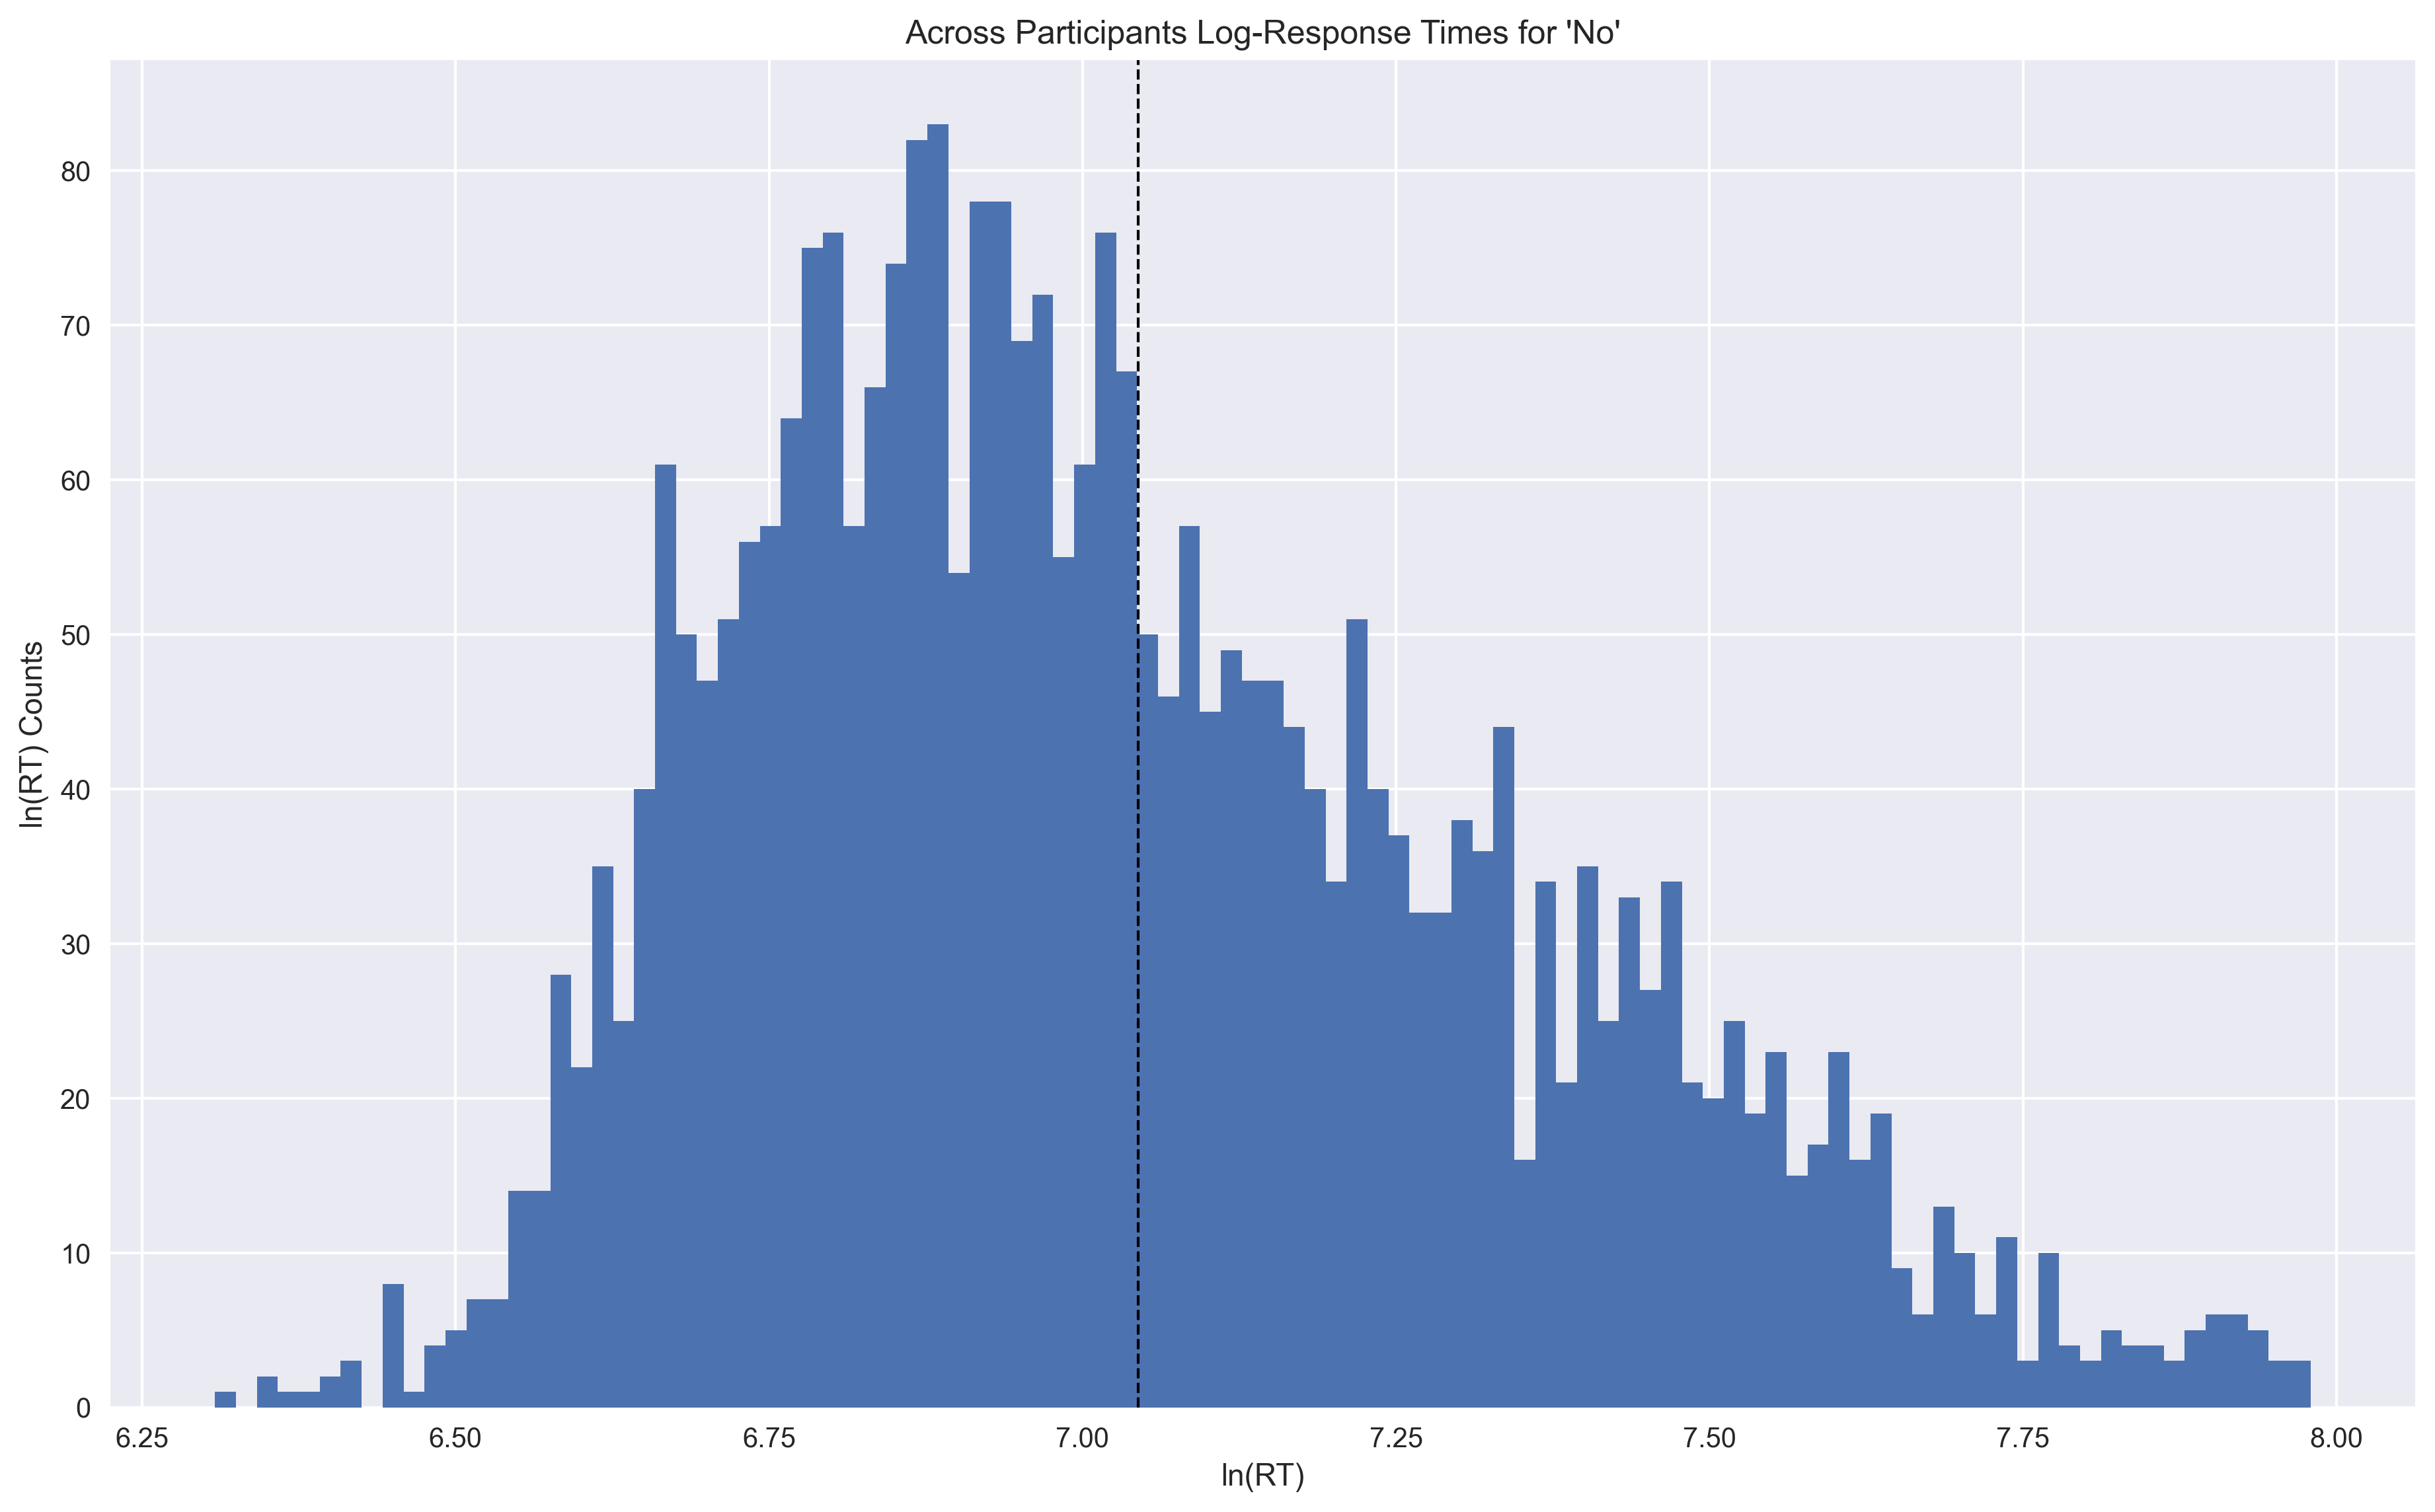

In [69]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses[responses.response=="No"].log_rt, bins=100);
plt.axvline(responses[responses.response=="No"].log_rt.mean(), color='k', linestyle='dashed', linewidth=1)
plt.title("Across Participants Log-Response Times for 'No'")
plt.xlabel("ln(RT)")
plt.ylabel("ln(RT) Counts");

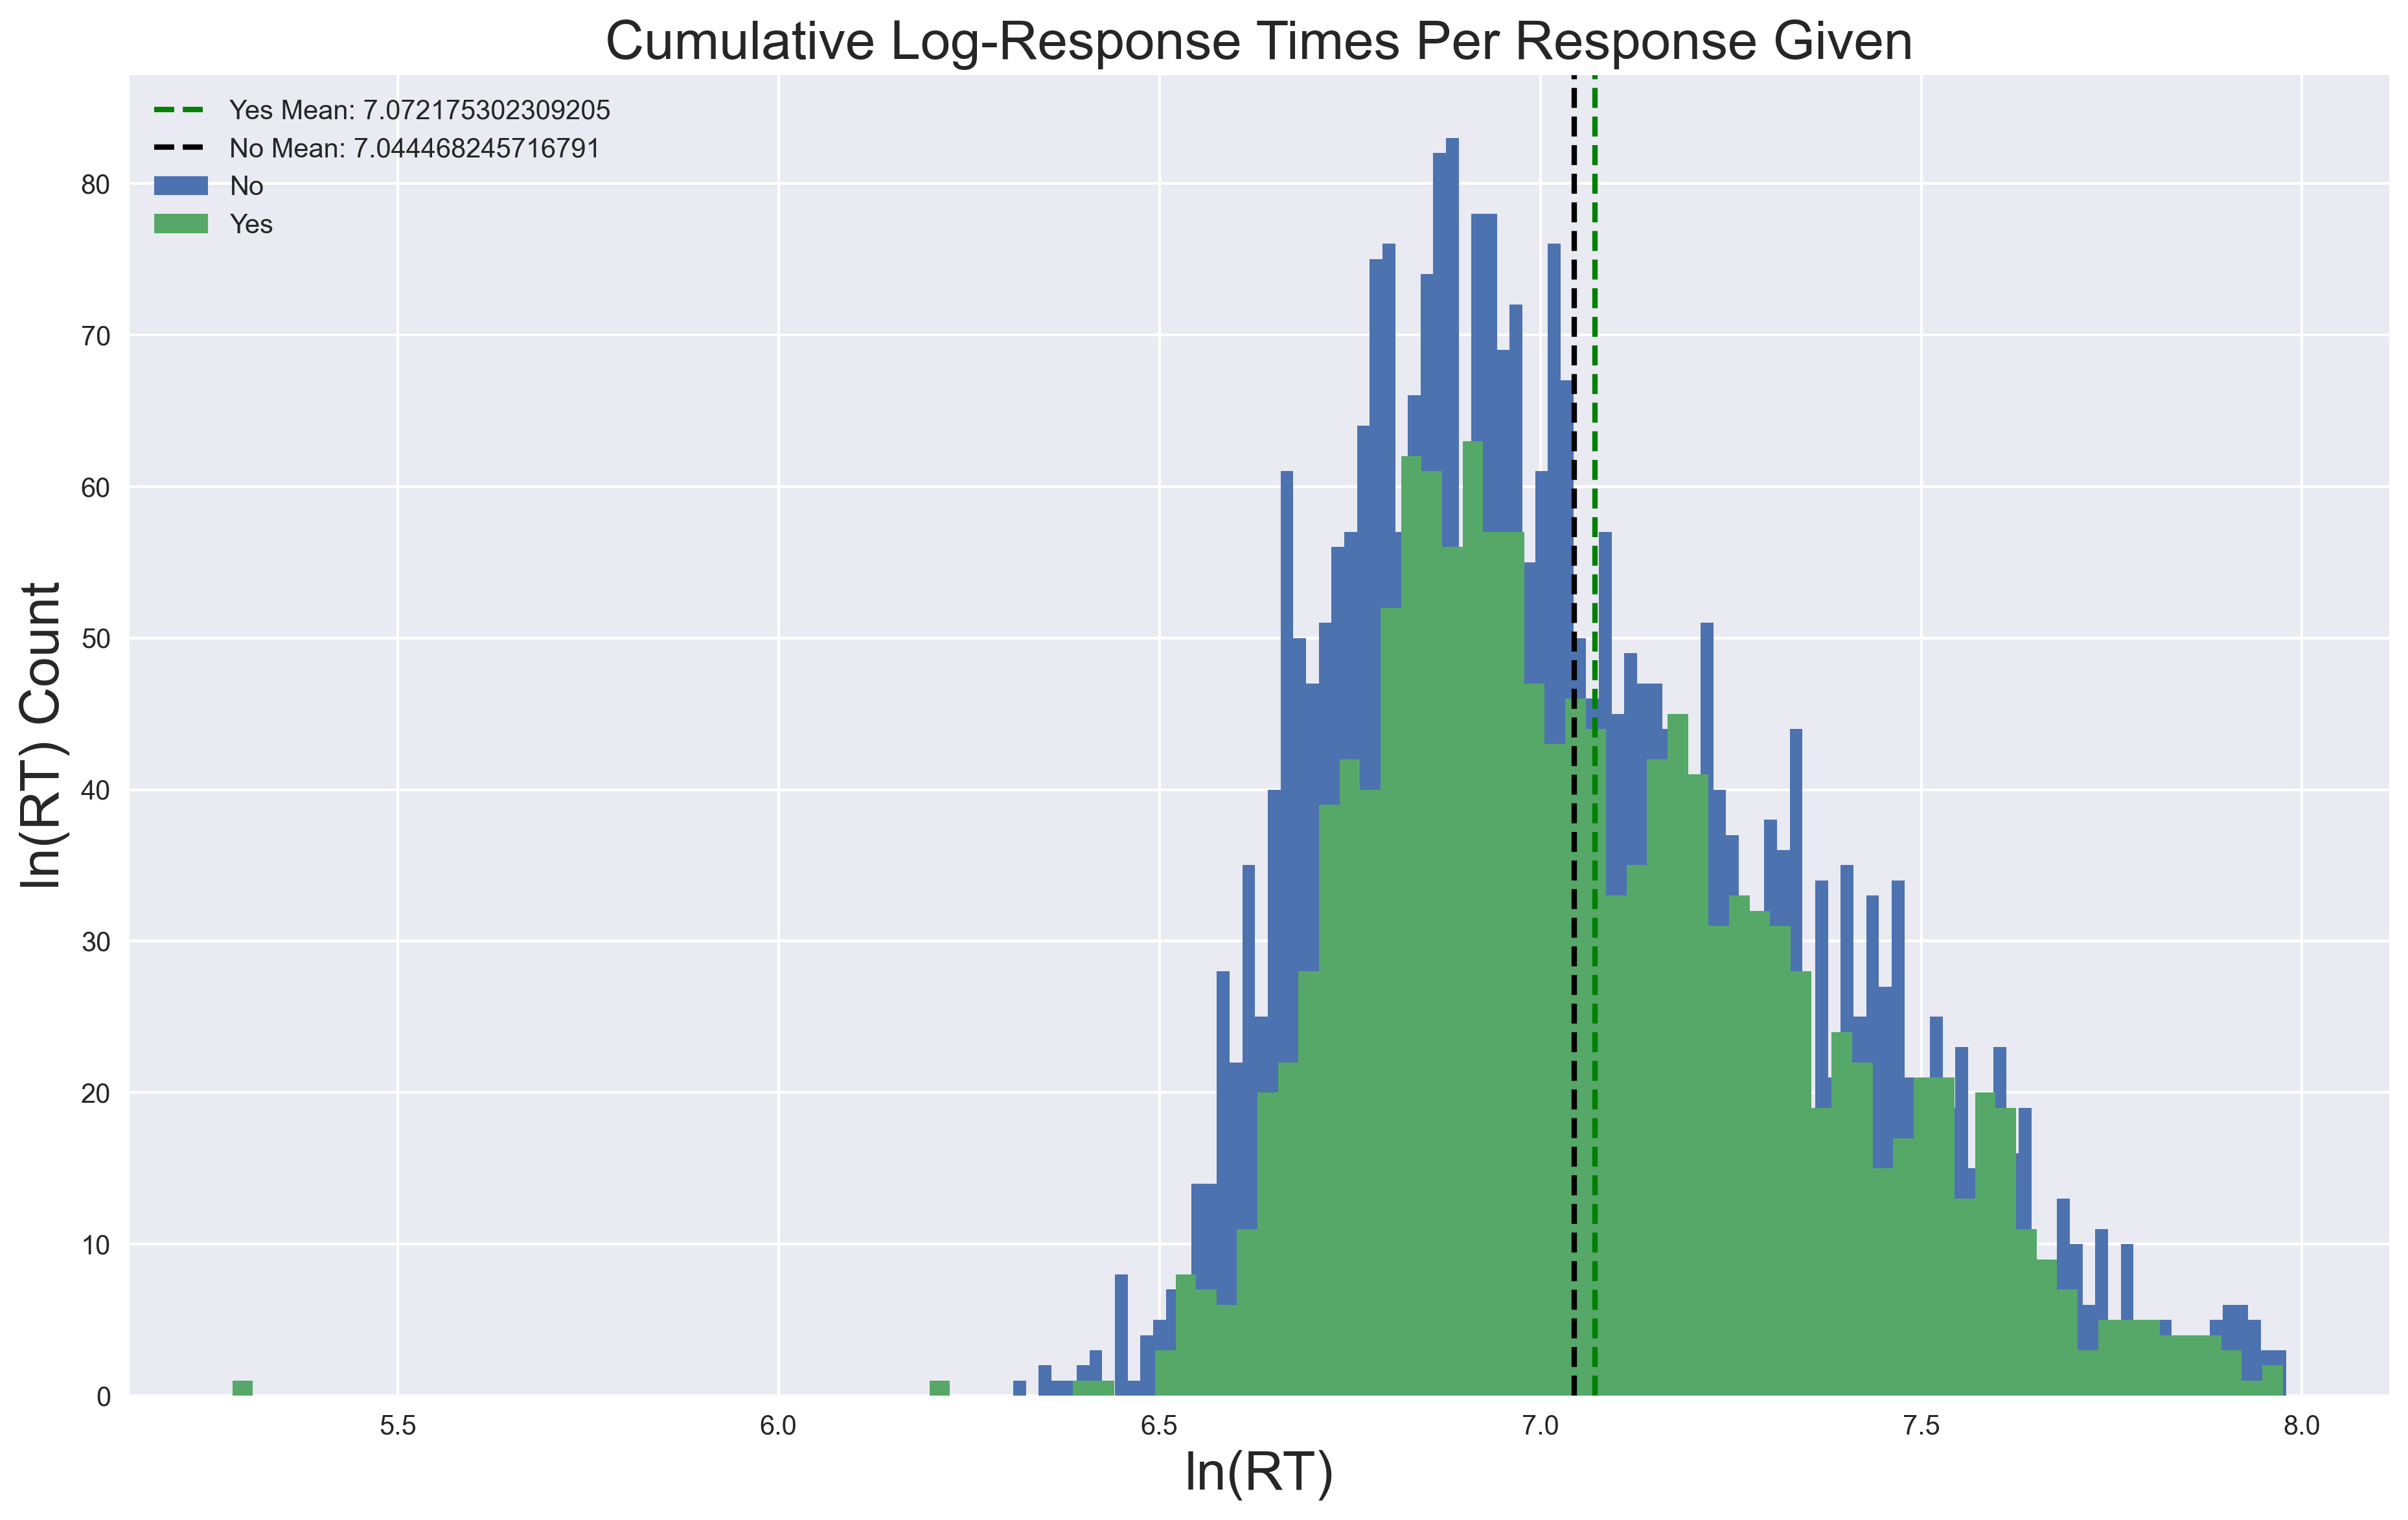

In [74]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses[responses.response=="No"].log_rt, bins=100, label="No");
plt.hist(responses[responses.response=="Yes"].log_rt, bins=100, label="Yes");
plt.title("Cumulative Log-Response Times Per Response Given",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("ln(RT) Count",fontsize=20);
plt.axvline(responses[responses.response=="Yes"].log_rt.mean(),color="green",linestyle='dashed', linewidth=2, label="Yes Mean: "+str(responses[responses.response=="Yes"].log_rt.mean()))
plt.axvline(responses[responses.response=="No"].log_rt.mean(),color="black",linestyle='dashed', linewidth=2, label="No Mean: "+str(responses[responses.response=="No"].log_rt.mean()))
plt.legend(loc="upper left")

In [55]:
yes_rr = responses[responses.response == responses.condition]
no_rr = responses[responses.response != responses.condition]

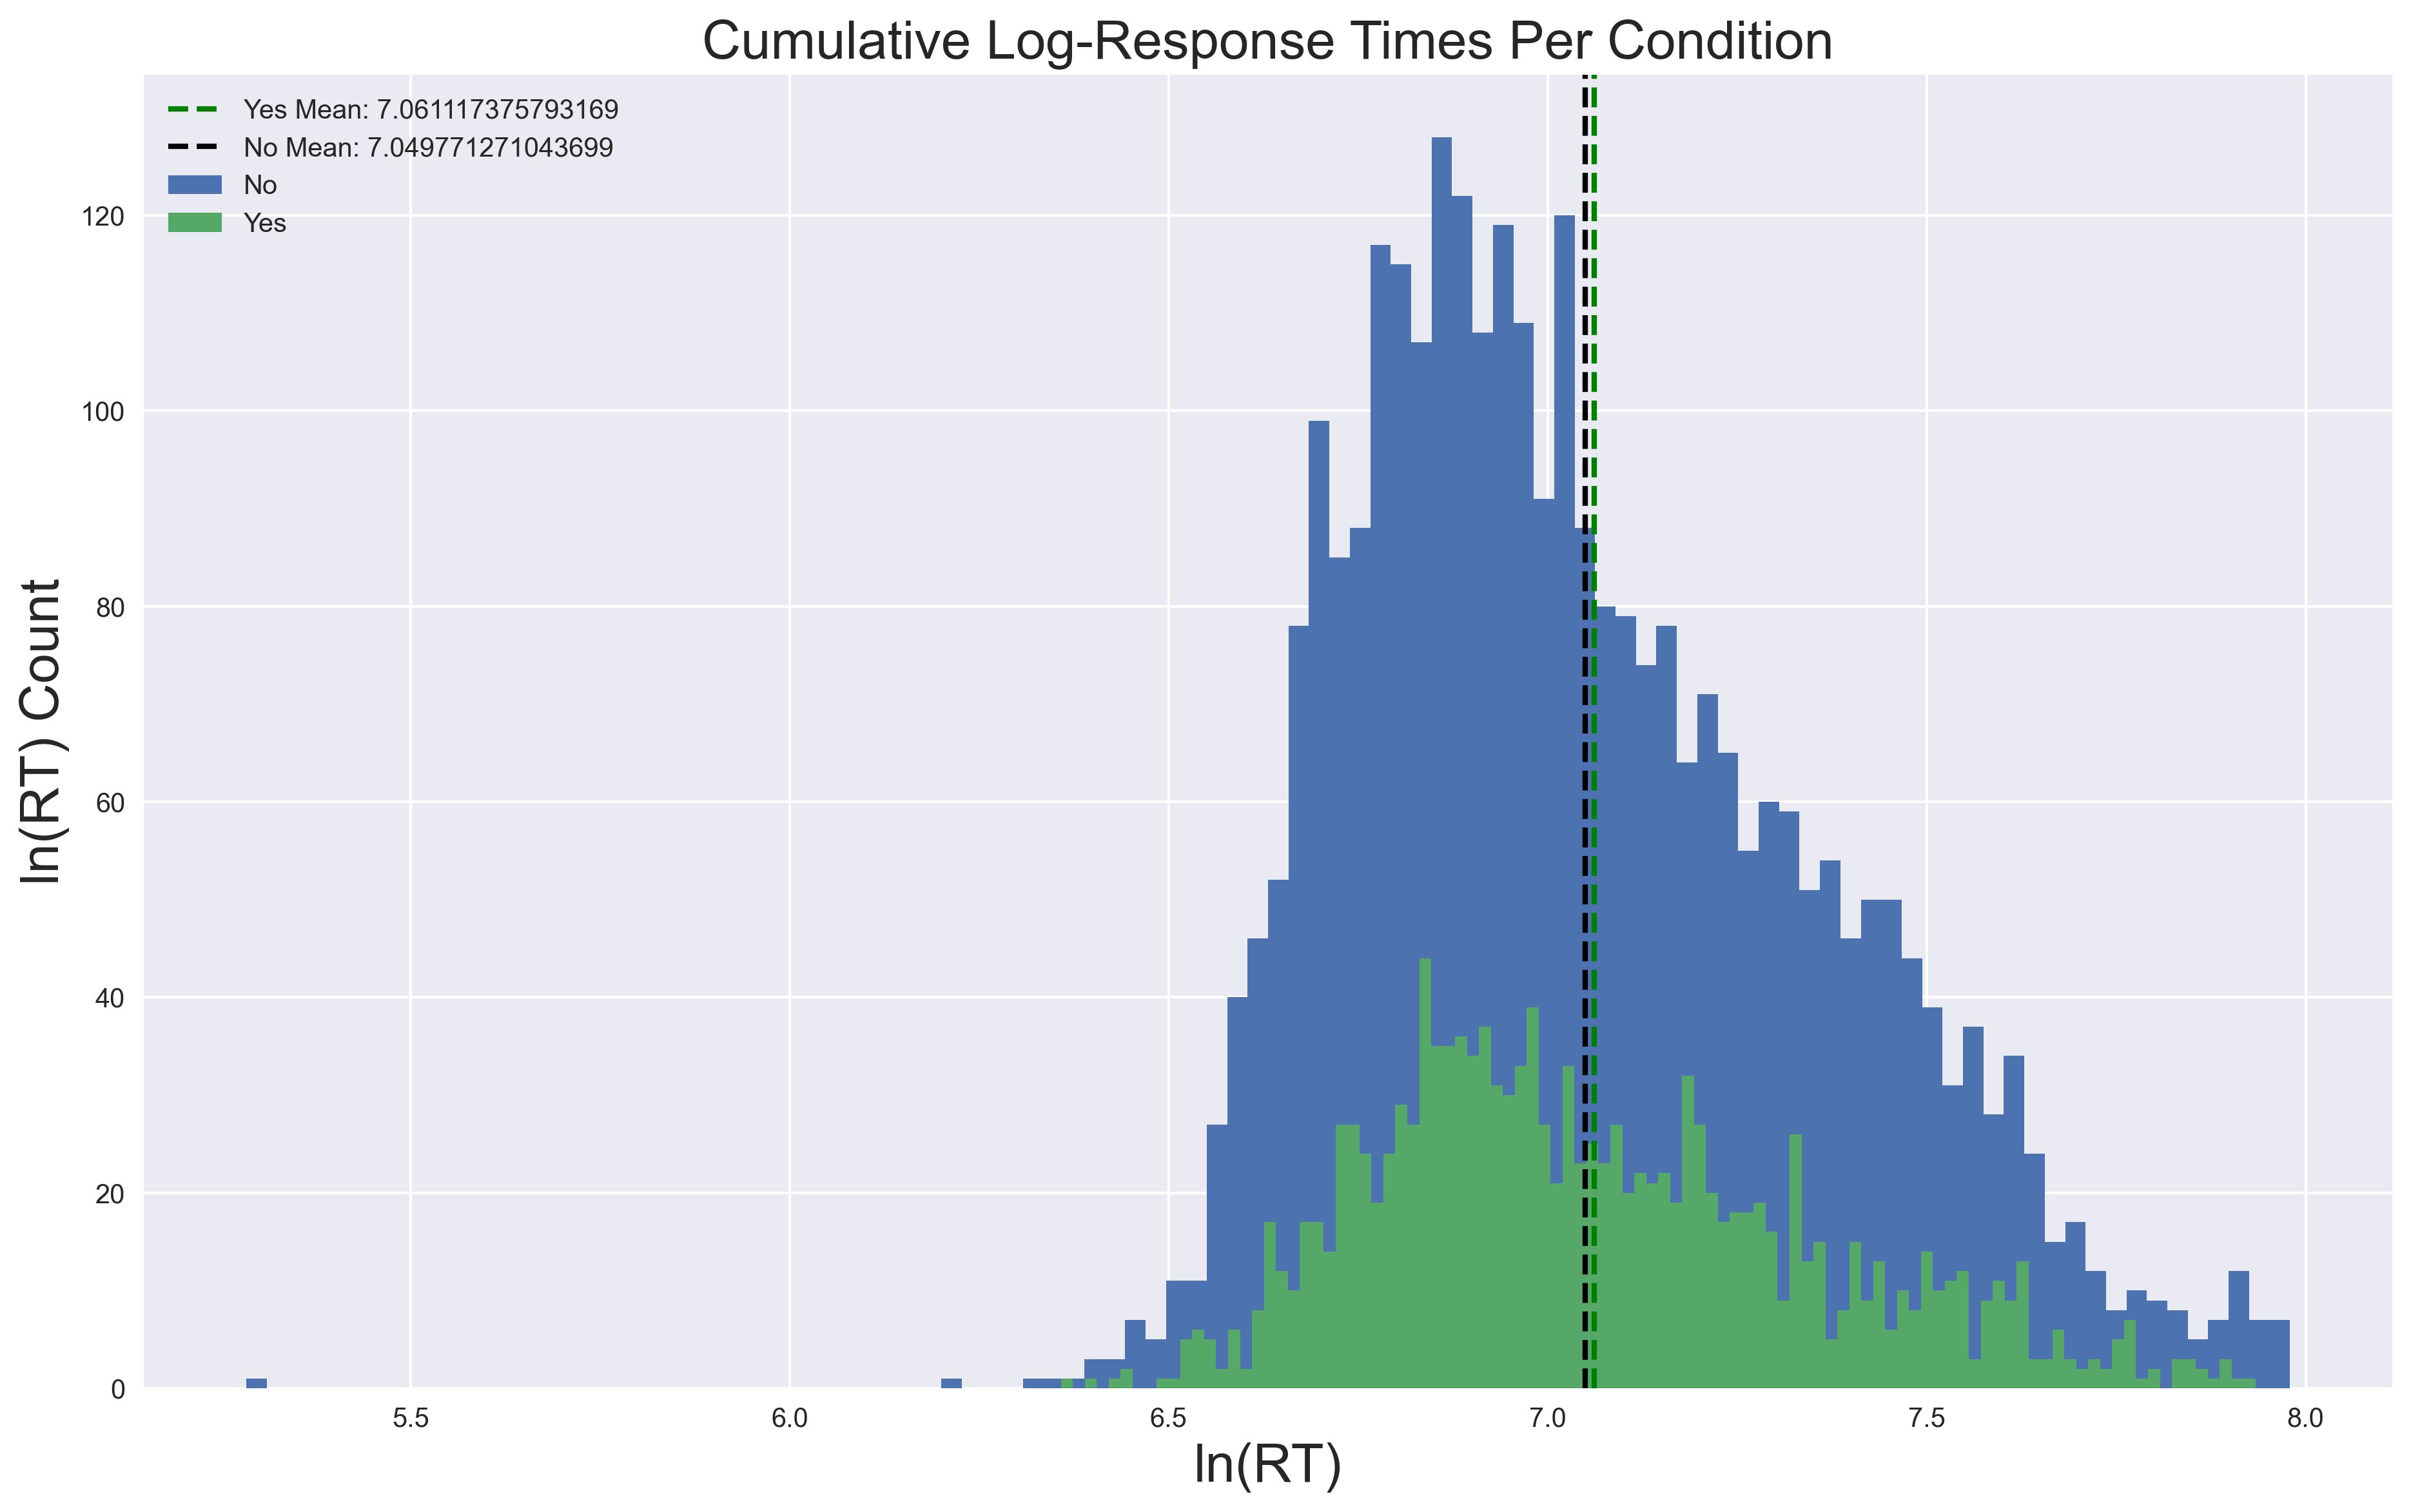

In [75]:
figure(figsize=(15, 9), dpi=300)
plt.hist(responses[responses.trial_condition=="No"].log_rt, bins=100, label="No");
plt.hist(responses[responses.trial_condition=="Yes"].log_rt, bins=100, label="Yes");
plt.title("Cumulative Log-Response Times Per Condition",fontsize=20)
plt.xlabel("ln(RT)",fontsize=20)
plt.ylabel("ln(RT) Count",fontsize=20);
plt.axvline(responses[responses.trial_condition=="Yes"].log_rt.mean(),color="green",linestyle='dashed', linewidth=2, label="Yes Mean: "+str(responses[responses.trial_condition=="Yes"].log_rt.mean()))
plt.axvline(responses[responses.trial_condition=="No"].log_rt.mean(),color="black",linestyle='dashed', linewidth=2, label="No Mean: "+str(responses[responses.trial_condition=="No"].log_rt.mean()))
plt.legend(loc="upper left")